In [1]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
%matplotlib inline

Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam()
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 50121
SL_VALIDATION_SIZE = 12531
EPOCHS = 10
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_1_model.json"
WEIGHTS_PATH = "./binary_classifier/net_1_weights.h5"

In [95]:
def transform_image(img):
    # trasformazioni da implementare rotate, flip, shift, zoom
    sel = [0, 1]
    offset_1 = 72
    offset_2 = 72
    t_img = np.array(img)
    bound = (72 - 48) / 2
    if rand.choice(sel):
        # rotate
        angle = rand.uniform(0, 360)
        t_img = rotate(t_img, angle, mode='edge')
    if rand.choice(sel):
        # flip
        if rand.choice(sel):
            t_img = np.flipud(t_img)
        if rand.choice(sel):
            t_img = np.fliplr(t_img)
    if rand.choice(sel):
        # shift
        tform = SimilarityTransform(translation=(int(rand.uniform(-bound, bound)), int(rand.uniform(-bound, bound))))
        t_img = warp(t_img, tform)
    if rand.choice(sel):
        # zoom
        z = int(rand.uniform(-bound, bound))
        t_img = resize(t_img[offset_1-48-z:offset_1+48+z, offset_2-48-z:offset_2+48+z, :], (96, 96))
        return t_img.tolist()
    # Cut 96x96 patch
    t_img = t_img[offset_1-48:offset_1+48, offset_2-48:offset_2+48, :]
    return t_img.tolist()

/Users/vincenzoscotti/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


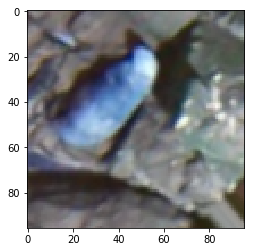

In [14]:
img = cv2.imread(TRAIN_PATH + 'sea_lions/13.jpg')
offset_1 = 72
offset_2 = 72
t_img = np.array(img)
bound = (72 - 48) / 2
# rotate
angle = rand.uniform(0, 360)
t_img = rotate(t_img, angle, mode='edge')
# flip
t_img = np.flipud(t_img)
# flip
t_img = np.fliplr(t_img)
# shift
tform = SimilarityTransform(translation=(int(rand.uniform(-bound, bound)), int(rand.uniform(-bound, bound))))
t_img = warp(t_img, tform)
# zoom
z = int(rand.uniform(-bound, bound))
t_img = resize(t_img[offset_1-48-z:offset_1+48+z, offset_2-48-z:offset_2+48+z, :], (96, 96))
plt.imshow(t_img.tolist())


In [100]:
# Sea lions patches extractor
def extract_sea_lion_patch(path, epoch, n_epochs):
    img = cv2.imread(path)
    if rand.uniform(0.0, 1.0) < (epoch/n_epochs):
        # Perform transformation
        return transform_image(img)
    patch = img[72-48:72+48, 72-48:72+48, :]
    return patch

In [5]:
def train_generator(epoch_tot, batch_size):
    sl_lst_tmp = os.listdir(TRAIN_PATH + 'sea_lions')
    sl_lst = []
    for elem in sl_lst_tmp:
        sl_lst.append(list((elem, 'sea_lion')))
    bkg_lst_tmp = os.listdir(TRAIN_PATH + 'background')
    for curr_epoch in range(epoch_tot):
        bkg_lst = []
        for elem in rand.sample(bkg_lst_tmp, SL_TRAIN_SIZE):
            bkg_lst.append(list((elem, 'background')))
        lst = sl_lst + bkg_lst
        rand.shuffle(lst)
        patches = []
        classes = []
        curr_batch_size = 0
        for elem in lst:
            if elem[1] == 'background':
                img = cv2.imread(TRAIN_PATH + 'background/' + elem[0])
                patches.append(img)
                classes.append([0, 1])
            else:
                patches.append(extract_sea_lion_patch(TRAIN_PATH + 'sea_lions/' + elem[0], curr_epoch, epoch_tot))
                classes.append([1, 0])
            curr_batch_size += 1
            if curr_batch_size == batch_size:
                X_train = np.array(patches)
                X_train = X_train.astype('float32')
                X_train /= 255
                Y_train = np.array(classes)
                curr_batch_size = 0
                patches = []
                classes = []
                yield X_train, Y_train
        if len(patches) > 0:
            X_train = np.array(patches)
            X_train = X_train.astype('float32')
            X_train /= 255
            Y_train = np.array(classes)
            yield X_train, Y_train
        print("end epoch" + str(curr_epoch + 1))

In [6]:
X_validation = []
Y_validation = []
validation_set = []
lst = os.listdir(VALIDATION_PATH + 'sea_lions')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'sea_lions/' + elem), 'sea_lion')))
lst = os.listdir(VALIDATION_PATH + 'background')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'background/' + elem), 'background')))
rand.shuffle(validation_set)
for data in validation_set:
    X_validation.append(data[0])
    if data[1] == 'sea_lion':
        Y_validation.append([1, 0])
    else:
        Y_validation.append([0, 1])
X_validation = np.array(X_validation, copy=False)
Y_validation = np.array(Y_validation, copy=False)

# Free memory
lst = []
validation_set = []

# Convert data types and normalize values
X_validation = X_validation.astype('float32')
X_validation /= 255


FileNotFoundError: [Errno 2] No such file or directory: './data_set/validation/sea_lions'

In [7]:
# Build parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [8]:
# Train (multi gpu)

# Fit model on training data
history = parallel_model.fit_generator( 
    train_generator(EPOCHS, BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_validation, Y_validation),
    validation_steps=VALIDATION_STEPS_PER_EPOCH,
    workers=8,
    max_queue_size=50)

Epoch 1/10


   1/2005 [..............................] - ETA: 1:34:32 - loss: 0.7070 - acc: 0.4000

   4/2005 [..............................] - ETA: 24:08 - loss: 0.6962 - acc: 0.4800  

   6/2005 [..............................] - ETA: 17:11 - loss: 0.6962 - acc: 0.4733

   7/2005 [..............................] - ETA: 16:03 - loss: 0.6928 - acc: 0.4971

   8/2005 [..............................] - ETA: 15:12 - loss: 0.6912 - acc: 0.5075

   9/2005 [..............................] - ETA: 14:37 - loss: 0.6905 - acc: 0.5133

  10/2005 [..............................] - ETA: 14:39 - loss: 0.6936 - acc: 0.4980

  11/2005 [..............................] - ETA: 14:09 - loss: 0.6916 - acc: 0.5055

  12/2005 [..............................] - ETA: 13:56 - loss: 0.6915 - acc: 0.5033

  13/2005 [..............................] - ETA: 13:33 - loss: 0.6907 - acc: 0.5046

  14/2005 [..............................] - ETA: 13:27 - loss: 0.6917 - acc: 0.5014

  15/2005 [..............................] - ETA: 13:06 - loss: 0.6903 - acc: 0.5080

  16/2005 [..............................] - ETA: 12:57 - loss: 0.6898 - acc: 0.5062

  17/2005 [..............................] - ETA: 12:46 - loss: 0.6892 - acc: 0.5071

  18/2005 [..............................] - ETA: 12:42 - loss: 0.6894 - acc: 0.5044

  19/2005 [..............................] - ETA: 12:44 - loss: 0.6897 - acc: 0.5011

  20/2005 [..............................] - ETA: 12:30 - loss: 0.6878 - acc: 0.5070

  21/2005 [..............................] - ETA: 12:32 - loss: 0.6874 - acc: 0.5067

  22/2005 [..............................] - ETA: 12:27 - loss: 0.6868 - acc: 0.5073

  23/2005 [..............................] - ETA: 12:24 - loss: 0.6874 - acc: 0.5061

  24/2005 [..............................] - ETA: 12:14 - loss: 0.6870 - acc: 0.5075

  25/2005 [..............................] - ETA: 12:10 - loss: 0.6864 - acc: 0.5096

  26/2005 [..............................] - ETA: 12:07 - loss: 0.6863 - acc: 0.5092

  27/2005 [..............................] - ETA: 11:55 - loss: 0.6848 - acc: 0.5141

  28/2005 [..............................] - ETA: 11:50 - loss: 0.6843 - acc: 0.5150

  29/2005 [..............................] - ETA: 11:49 - loss: 0.6847 - acc: 0.5124

  30/2005 [..............................] - ETA: 11:47 - loss: 0.6850 - acc: 0.5107

  31/2005 [..............................] - ETA: 11:44 - loss: 0.6843 - acc: 0.5110

  32/2005 [..............................] - ETA: 11:40 - loss: 0.6834 - acc: 0.5125

  33/2005 [..............................] - ETA: 11:35 - loss: 0.6824 - acc: 0.5139

  34/2005 [..............................] - ETA: 11:32 - loss: 0.6817 - acc: 0.5141

  35/2005 [..............................] - ETA: 11:30 - loss: 0.6816 - acc: 0.5120

  36/2005 [..............................] - ETA: 11:28 - loss: 0.6816 - acc: 0.5106

  37/2005 [..............................] - ETA: 11:30 - loss: 0.6814 - acc: 0.5086

  38/2005 [..............................] - ETA: 11:31 - loss: 0.6810 - acc: 0.5084

  39/2005 [..............................] - ETA: 11:28 - loss: 0.6807 - acc: 0.5082

  40/2005 [..............................] - ETA: 11:25 - loss: 0.6799 - acc: 0.5105

  41/2005 [..............................] - ETA: 11:25 - loss: 0.6794 - acc: 0.5107

  42/2005 [..............................] - ETA: 11:23 - loss: 0.6787 - acc: 0.5124

  43/2005 [..............................] - ETA: 11:22 - loss: 0.6785 - acc: 0.5116

  44/2005 [..............................] - ETA: 11:20 - loss: 0.6774 - acc: 0.5123

  45/2005 [..............................] - ETA: 11:14 - loss: 0.6758 - acc: 0.5164

  46/2005 [..............................] - ETA: 11:13 - loss: 0.6742 - acc: 0.5187

  47/2005 [..............................] - ETA: 11:11 - loss: 0.6734 - acc: 0.5191

  48/2005 [..............................] - ETA: 11:13 - loss: 0.6740 - acc: 0.5183

  49/2005 [..............................] - ETA: 11:10 - loss: 0.6730 - acc: 0.5196

  50/2005 [..............................] - ETA: 11:06 - loss: 0.6717 - acc: 0.5256

  51/2005 [..............................] - ETA: 11:04 - loss: 0.6701 - acc: 0.5341

  52/2005 [..............................] - ETA: 11:05 - loss: 0.6692 - acc: 0.5381

  53/2005 [..............................] - ETA: 11:00 - loss: 0.6668 - acc: 0.5442

  54/2005 [..............................] - ETA: 10:58 - loss: 0.6650 - acc: 0.5463

  55/2005 [..............................] - ETA: 10:56 - loss: 0.6641 - acc: 0.5476

  56/2005 [..............................] - ETA: 10:54 - loss: 0.6631 - acc: 0.5493

  57/2005 [..............................] - ETA: 10:52 - loss: 0.6617 - acc: 0.5509

  58/2005 [..............................] - ETA: 10:51 - loss: 0.6604 - acc: 0.5524

  59/2005 [..............................] - ETA: 10:52 - loss: 0.6592 - acc: 0.5583

  60/2005 [..............................] - ETA: 10:49 - loss: 0.6584 - acc: 0.5613

  61/2005 [..............................] - ETA: 10:48 - loss: 0.6574 - acc: 0.5666

  62/2005 [..............................] - ETA: 10:45 - loss: 0.6557 - acc: 0.5716

  63/2005 [..............................] - ETA: 10:41 - loss: 0.6534 - acc: 0.5752

  64/2005 [..............................] - ETA: 10:40 - loss: 0.6513 - acc: 0.5778

  65/2005 [..............................] - ETA: 10:40 - loss: 0.6494 - acc: 0.5800

  66/2005 [..............................] - ETA: 10:40 - loss: 0.6493 - acc: 0.5812

  67/2005 [>.............................] - ETA: 10:38 - loss: 0.6468 - acc: 0.5839

  68/2005 [>.............................] - ETA: 10:36 - loss: 0.6448 - acc: 0.5865

  69/2005 [>.............................] - ETA: 10:35 - loss: 0.6432 - acc: 0.5901

  70/2005 [>.............................] - ETA: 10:34 - loss: 0.6418 - acc: 0.5934

  71/2005 [>.............................] - ETA: 10:32 - loss: 0.6401 - acc: 0.5977

  72/2005 [>.............................] - ETA: 10:31 - loss: 0.6383 - acc: 0.6019

  73/2005 [>.............................] - ETA: 10:30 - loss: 0.6370 - acc: 0.6038

  74/2005 [>.............................] - ETA: 10:29 - loss: 0.6343 - acc: 0.6068

  75/2005 [>.............................] - ETA: 10:30 - loss: 0.6325 - acc: 0.6088

  76/2005 [>.............................] - ETA: 10:29 - loss: 0.6297 - acc: 0.6126

  77/2005 [>.............................] - ETA: 10:30 - loss: 0.6276 - acc: 0.6151

  78/2005 [>.............................] - ETA: 10:29 - loss: 0.6247 - acc: 0.6190

  79/2005 [>.............................] - ETA: 10:30 - loss: 0.6228 - acc: 0.6228

  80/2005 [>.............................] - ETA: 10:28 - loss: 0.6213 - acc: 0.6257

  81/2005 [>.............................] - ETA: 10:27 - loss: 0.6199 - acc: 0.6284

  82/2005 [>.............................] - ETA: 10:26 - loss: 0.6174 - acc: 0.6305

  83/2005 [>.............................] - ETA: 10:28 - loss: 0.6163 - acc: 0.6323

  84/2005 [>.............................] - ETA: 10:28 - loss: 0.6136 - acc: 0.6350

  85/2005 [>.............................] - ETA: 10:28 - loss: 0.6109 - acc: 0.6379

  86/2005 [>.............................] - ETA: 10:27 - loss: 0.6085 - acc: 0.6409

  87/2005 [>.............................] - ETA: 10:26 - loss: 0.6062 - acc: 0.6441

  88/2005 [>.............................] - ETA: 10:26 - loss: 0.6038 - acc: 0.6466

  89/2005 [>.............................] - ETA: 10:28 - loss: 0.6021 - acc: 0.6485

  90/2005 [>.............................] - ETA: 10:28 - loss: 0.6000 - acc: 0.6504

  91/2005 [>.............................] - ETA: 10:26 - loss: 0.5979 - acc: 0.6525

  92/2005 [>.............................] - ETA: 10:25 - loss: 0.5950 - acc: 0.6550

  93/2005 [>.............................] - ETA: 10:25 - loss: 0.5927 - acc: 0.6574

  94/2005 [>.............................] - ETA: 10:24 - loss: 0.5905 - acc: 0.6598

  95/2005 [>.............................] - ETA: 10:23 - loss: 0.5896 - acc: 0.6613

  96/2005 [>.............................] - ETA: 10:23 - loss: 0.5874 - acc: 0.6633

  97/2005 [>.............................] - ETA: 10:23 - loss: 0.5854 - acc: 0.6652

  98/2005 [>.............................] - ETA: 10:22 - loss: 0.5832 - acc: 0.6671

  99/2005 [>.............................] - ETA: 10:23 - loss: 0.5817 - acc: 0.6685

 100/2005 [>.............................] - ETA: 10:24 - loss: 0.5796 - acc: 0.6704

 101/2005 [>.............................] - ETA: 10:23 - loss: 0.5774 - acc: 0.6723

 102/2005 [>.............................] - ETA: 10:21 - loss: 0.5745 - acc: 0.6745

 103/2005 [>.............................] - ETA: 10:20 - loss: 0.5722 - acc: 0.6765

 104/2005 [>.............................] - ETA: 10:19 - loss: 0.5701 - acc: 0.6787

 105/2005 [>.............................] - ETA: 10:18 - loss: 0.5680 - acc: 0.6806

 106/2005 [>.............................] - ETA: 10:18 - loss: 0.5658 - acc: 0.6823

 107/2005 [>.............................] - ETA: 10:20 - loss: 0.5655 - acc: 0.6828

 108/2005 [>.............................] - ETA: 10:18 - loss: 0.5628 - acc: 0.6846

 109/2005 [>.............................] - ETA: 10:19 - loss: 0.5616 - acc: 0.6857

 110/2005 [>.............................] - ETA: 10:19 - loss: 0.5607 - acc: 0.6869

 111/2005 [>.............................] - ETA: 10:19 - loss: 0.5595 - acc: 0.6877

 112/2005 [>.............................] - ETA: 10:19 - loss: 0.5582 - acc: 0.6891

 113/2005 [>.............................] - ETA: 10:19 - loss: 0.5584 - acc: 0.6897

 114/2005 [>.............................] - ETA: 10:18 - loss: 0.5560 - acc: 0.6911

 115/2005 [>.............................] - ETA: 10:18 - loss: 0.5548 - acc: 0.6922

 116/2005 [>.............................] - ETA: 10:19 - loss: 0.5532 - acc: 0.6933

 117/2005 [>.............................] - ETA: 10:18 - loss: 0.5517 - acc: 0.6947

 118/2005 [>.............................] - ETA: 10:18 - loss: 0.5496 - acc: 0.6961

 119/2005 [>.............................] - ETA: 10:17 - loss: 0.5468 - acc: 0.6978

 120/2005 [>.............................] - ETA: 10:18 - loss: 0.5459 - acc: 0.6990

 121/2005 [>.............................] - ETA: 10:17 - loss: 0.5443 - acc: 0.7005

 122/2005 [>.............................] - ETA: 10:17 - loss: 0.5419 - acc: 0.7026

 123/2005 [>.............................] - ETA: 10:17 - loss: 0.5409 - acc: 0.7036

 124/2005 [>.............................] - ETA: 10:16 - loss: 0.5395 - acc: 0.7044

 125/2005 [>.............................] - ETA: 10:15 - loss: 0.5386 - acc: 0.7058

 126/2005 [>.............................] - ETA: 10:15 - loss: 0.5362 - acc: 0.7076

 127/2005 [>.............................] - ETA: 10:15 - loss: 0.5355 - acc: 0.7083

 128/2005 [>.............................] - ETA: 10:14 - loss: 0.5343 - acc: 0.7094

 129/2005 [>.............................] - ETA: 10:12 - loss: 0.5325 - acc: 0.7107

 130/2005 [>.............................] - ETA: 10:12 - loss: 0.5319 - acc: 0.7114

 131/2005 [>.............................] - ETA: 10:12 - loss: 0.5302 - acc: 0.7124

 132/2005 [>.............................] - ETA: 10:11 - loss: 0.5286 - acc: 0.7138

 133/2005 [>.............................] - ETA: 10:12 - loss: 0.5269 - acc: 0.7155

 134/2005 [=>............................] - ETA: 10:12 - loss: 0.5251 - acc: 0.7170

 135/2005 [=>............................] - ETA: 10:12 - loss: 0.5233 - acc: 0.7181

 136/2005 [=>............................] - ETA: 10:12 - loss: 0.5213 - acc: 0.7193

 137/2005 [=>............................] - ETA: 10:11 - loss: 0.5196 - acc: 0.7207

 138/2005 [=>............................] - ETA: 10:10 - loss: 0.5177 - acc: 0.7223

 139/2005 [=>............................] - ETA: 10:09 - loss: 0.5161 - acc: 0.7235

 140/2005 [=>............................] - ETA: 10:08 - loss: 0.5149 - acc: 0.7240

 141/2005 [=>............................] - ETA: 10:08 - loss: 0.5134 - acc: 0.7251

 142/2005 [=>............................] - ETA: 10:07 - loss: 0.5116 - acc: 0.7262

 143/2005 [=>............................] - ETA: 10:07 - loss: 0.5105 - acc: 0.7271

 144/2005 [=>............................] - ETA: 10:07 - loss: 0.5092 - acc: 0.7282

 145/2005 [=>............................] - ETA: 10:07 - loss: 0.5076 - acc: 0.7294

 146/2005 [=>............................] - ETA: 10:08 - loss: 0.5076 - acc: 0.7299

 147/2005 [=>............................] - ETA: 10:09 - loss: 0.5056 - acc: 0.7314

 148/2005 [=>............................] - ETA: 10:08 - loss: 0.5042 - acc: 0.7324

 149/2005 [=>............................] - ETA: 10:08 - loss: 0.5035 - acc: 0.7332

 150/2005 [=>............................] - ETA: 10:07 - loss: 0.5017 - acc: 0.7344

 151/2005 [=>............................] - ETA: 10:06 - loss: 0.5009 - acc: 0.7351

 152/2005 [=>............................] - ETA: 10:06 - loss: 0.4994 - acc: 0.7361

 153/2005 [=>............................] - ETA: 10:05 - loss: 0.4984 - acc: 0.7370

 154/2005 [=>............................] - ETA: 10:05 - loss: 0.4962 - acc: 0.7384

 155/2005 [=>............................] - ETA: 10:04 - loss: 0.4943 - acc: 0.7396

 156/2005 [=>............................] - ETA: 10:04 - loss: 0.4922 - acc: 0.7410

 157/2005 [=>............................] - ETA: 10:05 - loss: 0.4916 - acc: 0.7419

 158/2005 [=>............................] - ETA: 10:05 - loss: 0.4901 - acc: 0.7432

 159/2005 [=>............................] - ETA: 10:05 - loss: 0.4897 - acc: 0.7438

 160/2005 [=>............................] - ETA: 10:04 - loss: 0.4888 - acc: 0.7445

 161/2005 [=>............................] - ETA: 10:05 - loss: 0.4879 - acc: 0.7455

 162/2005 [=>............................] - ETA: 10:04 - loss: 0.4867 - acc: 0.7463

 163/2005 [=>............................] - ETA: 10:04 - loss: 0.4857 - acc: 0.7470

 164/2005 [=>............................] - ETA: 10:03 - loss: 0.4849 - acc: 0.7478

 165/2005 [=>............................] - ETA: 10:04 - loss: 0.4841 - acc: 0.7485

 166/2005 [=>............................] - ETA: 10:03 - loss: 0.4827 - acc: 0.7494

 167/2005 [=>............................] - ETA: 10:02 - loss: 0.4838 - acc: 0.7493

 168/2005 [=>............................] - ETA: 10:02 - loss: 0.4833 - acc: 0.7500

 169/2005 [=>............................] - ETA: 10:03 - loss: 0.4823 - acc: 0.7509

 170/2005 [=>............................] - ETA: 10:02 - loss: 0.4820 - acc: 0.7511

 171/2005 [=>............................] - ETA: 10:01 - loss: 0.4811 - acc: 0.7519

 172/2005 [=>............................] - ETA: 10:01 - loss: 0.4801 - acc: 0.7524

 173/2005 [=>............................] - ETA: 10:00 - loss: 0.4789 - acc: 0.7533

 174/2005 [=>............................] - ETA: 9:59 - loss: 0.4777 - acc: 0.7539 

 175/2005 [=>............................] - ETA: 9:59 - loss: 0.4759 - acc: 0.7551

 176/2005 [=>............................] - ETA: 9:59 - loss: 0.4752 - acc: 0.7557

 177/2005 [=>............................] - ETA: 9:59 - loss: 0.4746 - acc: 0.7558

 178/2005 [=>............................] - ETA: 9:59 - loss: 0.4736 - acc: 0.7566

 179/2005 [=>............................] - ETA: 9:58 - loss: 0.4728 - acc: 0.7573

 180/2005 [=>............................] - ETA: 9:59 - loss: 0.4714 - acc: 0.7584

 181/2005 [=>............................] - ETA: 9:58 - loss: 0.4702 - acc: 0.7593

 182/2005 [=>............................] - ETA: 9:58 - loss: 0.4694 - acc: 0.7599

 183/2005 [=>............................] - ETA: 9:58 - loss: 0.4685 - acc: 0.7604

 184/2005 [=>............................] - ETA: 9:57 - loss: 0.4684 - acc: 0.7605

 185/2005 [=>............................] - ETA: 9:57 - loss: 0.4670 - acc: 0.7617

 186/2005 [=>............................] - ETA: 9:56 - loss: 0.4658 - acc: 0.7625

 187/2005 [=>............................] - ETA: 9:56 - loss: 0.4653 - acc: 0.7631

 188/2005 [=>............................] - ETA: 9:55 - loss: 0.4650 - acc: 0.7632

 189/2005 [=>............................] - ETA: 9:55 - loss: 0.4638 - acc: 0.7641

 190/2005 [=>............................] - ETA: 9:53 - loss: 0.4632 - acc: 0.7646

 191/2005 [=>............................] - ETA: 9:52 - loss: 0.4630 - acc: 0.7650

 192/2005 [=>............................] - ETA: 9:52 - loss: 0.4620 - acc: 0.7658

 193/2005 [=>............................] - ETA: 9:51 - loss: 0.4619 - acc: 0.7662

 194/2005 [=>............................] - ETA: 9:51 - loss: 0.4613 - acc: 0.7665

 195/2005 [=>............................] - ETA: 9:51 - loss: 0.4605 - acc: 0.7670

 196/2005 [=>............................] - ETA: 9:50 - loss: 0.4597 - acc: 0.7678

 197/2005 [=>............................] - ETA: 9:49 - loss: 0.4588 - acc: 0.7683

 198/2005 [=>............................] - ETA: 9:49 - loss: 0.4573 - acc: 0.7693

 199/2005 [=>............................] - ETA: 9:49 - loss: 0.4563 - acc: 0.7699

 200/2005 [=>............................] - ETA: 9:48 - loss: 0.4552 - acc: 0.7706

 201/2005 [==>...........................] - ETA: 9:47 - loss: 0.4546 - acc: 0.7711

 202/2005 [==>...........................] - ETA: 9:46 - loss: 0.4534 - acc: 0.7719

 203/2005 [==>...........................] - ETA: 9:46 - loss: 0.4522 - acc: 0.7726

 204/2005 [==>...........................] - ETA: 9:46 - loss: 0.4512 - acc: 0.7730

 205/2005 [==>...........................] - ETA: 9:45 - loss: 0.4507 - acc: 0.7733

 206/2005 [==>...........................] - ETA: 9:44 - loss: 0.4505 - acc: 0.7735

 207/2005 [==>...........................] - ETA: 9:44 - loss: 0.4501 - acc: 0.7738

 208/2005 [==>...........................] - ETA: 9:45 - loss: 0.4504 - acc: 0.7739

 209/2005 [==>...........................] - ETA: 9:44 - loss: 0.4497 - acc: 0.7744

 210/2005 [==>...........................] - ETA: 9:44 - loss: 0.4487 - acc: 0.7752

 211/2005 [==>...........................] - ETA: 9:44 - loss: 0.4484 - acc: 0.7757

 212/2005 [==>...........................] - ETA: 9:44 - loss: 0.4479 - acc: 0.7761

 213/2005 [==>...........................] - ETA: 9:43 - loss: 0.4473 - acc: 0.7765

 214/2005 [==>...........................] - ETA: 9:43 - loss: 0.4464 - acc: 0.7769

 215/2005 [==>...........................] - ETA: 9:43 - loss: 0.4461 - acc: 0.7772

 216/2005 [==>...........................] - ETA: 9:42 - loss: 0.4455 - acc: 0.7777

 217/2005 [==>...........................] - ETA: 9:41 - loss: 0.4446 - acc: 0.7780

 218/2005 [==>...........................] - ETA: 9:41 - loss: 0.4439 - acc: 0.7783

 219/2005 [==>...........................] - ETA: 9:40 - loss: 0.4433 - acc: 0.7787

 220/2005 [==>...........................] - ETA: 9:39 - loss: 0.4428 - acc: 0.7790

 221/2005 [==>...........................] - ETA: 9:38 - loss: 0.4425 - acc: 0.7795

 222/2005 [==>...........................] - ETA: 9:37 - loss: 0.4424 - acc: 0.7797

 223/2005 [==>...........................] - ETA: 9:37 - loss: 0.4414 - acc: 0.7803

 224/2005 [==>...........................] - ETA: 9:36 - loss: 0.4406 - acc: 0.7807

 225/2005 [==>...........................] - ETA: 9:35 - loss: 0.4407 - acc: 0.7812

 226/2005 [==>...........................] - ETA: 9:35 - loss: 0.4406 - acc: 0.7815

 227/2005 [==>...........................] - ETA: 9:35 - loss: 0.4395 - acc: 0.7822

 228/2005 [==>...........................] - ETA: 9:35 - loss: 0.4386 - acc: 0.7828

 229/2005 [==>...........................] - ETA: 9:35 - loss: 0.4391 - acc: 0.7826

 230/2005 [==>...........................] - ETA: 9:34 - loss: 0.4391 - acc: 0.7824

 231/2005 [==>...........................] - ETA: 9:34 - loss: 0.4385 - acc: 0.7829

 232/2005 [==>...........................] - ETA: 9:33 - loss: 0.4382 - acc: 0.7832

 233/2005 [==>...........................] - ETA: 9:33 - loss: 0.4379 - acc: 0.7836

 234/2005 [==>...........................] - ETA: 9:32 - loss: 0.4382 - acc: 0.7838

 235/2005 [==>...........................] - ETA: 9:32 - loss: 0.4379 - acc: 0.7841

 236/2005 [==>...........................] - ETA: 9:31 - loss: 0.4376 - acc: 0.7843

 237/2005 [==>...........................] - ETA: 9:31 - loss: 0.4367 - acc: 0.7847

 238/2005 [==>...........................] - ETA: 9:30 - loss: 0.4365 - acc: 0.7850

 239/2005 [==>...........................] - ETA: 9:30 - loss: 0.4363 - acc: 0.7849

 240/2005 [==>...........................] - ETA: 9:30 - loss: 0.4364 - acc: 0.7849

 241/2005 [==>...........................] - ETA: 9:30 - loss: 0.4358 - acc: 0.7853

 242/2005 [==>...........................] - ETA: 9:29 - loss: 0.4354 - acc: 0.7856

 243/2005 [==>...........................] - ETA: 9:30 - loss: 0.4354 - acc: 0.7858

 244/2005 [==>...........................] - ETA: 9:29 - loss: 0.4345 - acc: 0.7861

 245/2005 [==>...........................] - ETA: 9:29 - loss: 0.4345 - acc: 0.7863

 246/2005 [==>...........................] - ETA: 9:30 - loss: 0.4337 - acc: 0.7868

 247/2005 [==>...........................] - ETA: 9:30 - loss: 0.4332 - acc: 0.7869

 248/2005 [==>...........................] - ETA: 9:29 - loss: 0.4331 - acc: 0.7870

 249/2005 [==>...........................] - ETA: 9:29 - loss: 0.4327 - acc: 0.7874

 250/2005 [==>...........................] - ETA: 9:29 - loss: 0.4320 - acc: 0.7878

 251/2005 [==>...........................] - ETA: 9:29 - loss: 0.4314 - acc: 0.7882

 252/2005 [==>...........................] - ETA: 9:28 - loss: 0.4315 - acc: 0.7883

 253/2005 [==>...........................] - ETA: 9:28 - loss: 0.4313 - acc: 0.7886

 254/2005 [==>...........................] - ETA: 9:28 - loss: 0.4310 - acc: 0.7887

 255/2005 [==>...........................] - ETA: 9:27 - loss: 0.4300 - acc: 0.7893

 256/2005 [==>...........................] - ETA: 9:27 - loss: 0.4297 - acc: 0.7895

 257/2005 [==>...........................] - ETA: 9:26 - loss: 0.4298 - acc: 0.7896

 258/2005 [==>...........................] - ETA: 9:26 - loss: 0.4295 - acc: 0.7899

 259/2005 [==>...........................] - ETA: 9:26 - loss: 0.4295 - acc: 0.7898

 260/2005 [==>...........................] - ETA: 9:26 - loss: 0.4285 - acc: 0.7904

 261/2005 [==>...........................] - ETA: 9:26 - loss: 0.4280 - acc: 0.7907

 262/2005 [==>...........................] - ETA: 9:26 - loss: 0.4275 - acc: 0.7910

 263/2005 [==>...........................] - ETA: 9:25 - loss: 0.4274 - acc: 0.7911

 264/2005 [==>...........................] - ETA: 9:25 - loss: 0.4273 - acc: 0.7911

 265/2005 [==>...........................] - ETA: 9:25 - loss: 0.4268 - acc: 0.7912

 266/2005 [==>...........................] - ETA: 9:24 - loss: 0.4263 - acc: 0.7917

 267/2005 [==>...........................] - ETA: 9:24 - loss: 0.4258 - acc: 0.7918

 268/2005 [===>..........................] - ETA: 9:23 - loss: 0.4256 - acc: 0.7923

 269/2005 [===>..........................] - ETA: 9:23 - loss: 0.4251 - acc: 0.7926

 270/2005 [===>..........................] - ETA: 9:23 - loss: 0.4246 - acc: 0.7930

 271/2005 [===>..........................] - ETA: 9:23 - loss: 0.4240 - acc: 0.7935

 272/2005 [===>..........................] - ETA: 9:23 - loss: 0.4237 - acc: 0.7936

 273/2005 [===>..........................] - ETA: 9:23 - loss: 0.4233 - acc: 0.7939

 274/2005 [===>..........................] - ETA: 9:23 - loss: 0.4227 - acc: 0.7942

 275/2005 [===>..........................] - ETA: 9:22 - loss: 0.4222 - acc: 0.7945

 276/2005 [===>..........................] - ETA: 9:22 - loss: 0.4221 - acc: 0.7943

 277/2005 [===>..........................] - ETA: 9:22 - loss: 0.4217 - acc: 0.7947

 278/2005 [===>..........................] - ETA: 9:22 - loss: 0.4213 - acc: 0.7950

 279/2005 [===>..........................] - ETA: 9:22 - loss: 0.4208 - acc: 0.7954

 280/2005 [===>..........................] - ETA: 9:21 - loss: 0.4200 - acc: 0.7958

 281/2005 [===>..........................] - ETA: 9:21 - loss: 0.4198 - acc: 0.7961

 282/2005 [===>..........................] - ETA: 9:20 - loss: 0.4197 - acc: 0.7960

 283/2005 [===>..........................] - ETA: 9:20 - loss: 0.4190 - acc: 0.7965

 284/2005 [===>..........................] - ETA: 9:20 - loss: 0.4182 - acc: 0.7968

 285/2005 [===>..........................] - ETA: 9:19 - loss: 0.4173 - acc: 0.7974

 286/2005 [===>..........................] - ETA: 9:18 - loss: 0.4171 - acc: 0.7976

 287/2005 [===>..........................] - ETA: 9:18 - loss: 0.4170 - acc: 0.7978

 288/2005 [===>..........................] - ETA: 9:18 - loss: 0.4167 - acc: 0.7981

 289/2005 [===>..........................] - ETA: 9:17 - loss: 0.4161 - acc: 0.7986

 290/2005 [===>..........................] - ETA: 9:16 - loss: 0.4163 - acc: 0.7987

 291/2005 [===>..........................] - ETA: 9:16 - loss: 0.4165 - acc: 0.7986

 292/2005 [===>..........................] - ETA: 9:15 - loss: 0.4164 - acc: 0.7988

 293/2005 [===>..........................] - ETA: 9:15 - loss: 0.4165 - acc: 0.7988

 294/2005 [===>..........................] - ETA: 9:14 - loss: 0.4162 - acc: 0.7989

 295/2005 [===>..........................] - ETA: 9:13 - loss: 0.4158 - acc: 0.7991

 296/2005 [===>..........................] - ETA: 9:13 - loss: 0.4156 - acc: 0.7993

 297/2005 [===>..........................] - ETA: 9:12 - loss: 0.4149 - acc: 0.7996

 298/2005 [===>..........................] - ETA: 9:11 - loss: 0.4144 - acc: 0.7999

 299/2005 [===>..........................] - ETA: 9:11 - loss: 0.4143 - acc: 0.8001

 300/2005 [===>..........................] - ETA: 9:11 - loss: 0.4140 - acc: 0.8003

 301/2005 [===>..........................] - ETA: 9:11 - loss: 0.4138 - acc: 0.8005

 302/2005 [===>..........................] - ETA: 9:11 - loss: 0.4131 - acc: 0.8009

 303/2005 [===>..........................] - ETA: 9:11 - loss: 0.4128 - acc: 0.8011

 304/2005 [===>..........................] - ETA: 9:10 - loss: 0.4120 - acc: 0.8018

 305/2005 [===>..........................] - ETA: 9:10 - loss: 0.4116 - acc: 0.8019

 306/2005 [===>..........................] - ETA: 9:10 - loss: 0.4117 - acc: 0.8019

 307/2005 [===>..........................] - ETA: 9:10 - loss: 0.4116 - acc: 0.8020

 308/2005 [===>..........................] - ETA: 9:09 - loss: 0.4111 - acc: 0.8024

 309/2005 [===>..........................] - ETA: 9:09 - loss: 0.4107 - acc: 0.8028

 310/2005 [===>..........................] - ETA: 9:09 - loss: 0.4109 - acc: 0.8028

 311/2005 [===>..........................] - ETA: 9:08 - loss: 0.4110 - acc: 0.8029

 312/2005 [===>..........................] - ETA: 9:08 - loss: 0.4104 - acc: 0.8034

 313/2005 [===>..........................] - ETA: 9:07 - loss: 0.4102 - acc: 0.8037

 314/2005 [===>..........................] - ETA: 9:07 - loss: 0.4098 - acc: 0.8039

 315/2005 [===>..........................] - ETA: 9:07 - loss: 0.4093 - acc: 0.8043

 316/2005 [===>..........................] - ETA: 9:07 - loss: 0.4087 - acc: 0.8047

 317/2005 [===>..........................] - ETA: 9:06 - loss: 0.4091 - acc: 0.8047

 318/2005 [===>..........................] - ETA: 9:06 - loss: 0.4089 - acc: 0.8049

 319/2005 [===>..........................] - ETA: 9:05 - loss: 0.4087 - acc: 0.8051

 320/2005 [===>..........................] - ETA: 9:05 - loss: 0.4081 - acc: 0.8055

 321/2005 [===>..........................] - ETA: 9:04 - loss: 0.4077 - acc: 0.8059

 322/2005 [===>..........................] - ETA: 9:04 - loss: 0.4070 - acc: 0.8063

 323/2005 [===>..........................] - ETA: 9:04 - loss: 0.4067 - acc: 0.8064

 324/2005 [===>..........................] - ETA: 9:04 - loss: 0.4063 - acc: 0.8067

 325/2005 [===>..........................] - ETA: 9:03 - loss: 0.4058 - acc: 0.8069

 326/2005 [===>..........................] - ETA: 9:03 - loss: 0.4052 - acc: 0.8073

 327/2005 [===>..........................] - ETA: 9:03 - loss: 0.4049 - acc: 0.8076

 328/2005 [===>..........................] - ETA: 9:03 - loss: 0.4046 - acc: 0.8079

 329/2005 [===>..........................] - ETA: 9:02 - loss: 0.4047 - acc: 0.8080

 330/2005 [===>..........................] - ETA: 9:02 - loss: 0.4044 - acc: 0.8082

 331/2005 [===>..........................] - ETA: 9:02 - loss: 0.4042 - acc: 0.8082

 332/2005 [===>..........................] - ETA: 9:02 - loss: 0.4042 - acc: 0.8082

 333/2005 [===>..........................] - ETA: 9:01 - loss: 0.4039 - acc: 0.8082

 334/2005 [===>..........................] - ETA: 9:01 - loss: 0.4037 - acc: 0.8081

 335/2005 [====>.........................] - ETA: 9:01 - loss: 0.4037 - acc: 0.8083

 336/2005 [====>.........................] - ETA: 9:01 - loss: 0.4035 - acc: 0.8084

 337/2005 [====>.........................] - ETA: 9:00 - loss: 0.4034 - acc: 0.8085

 338/2005 [====>.........................] - ETA: 9:00 - loss: 0.4033 - acc: 0.8087

 339/2005 [====>.........................] - ETA: 9:00 - loss: 0.4028 - acc: 0.8090

 340/2005 [====>.........................] - ETA: 8:59 - loss: 0.4025 - acc: 0.8092

 341/2005 [====>.........................] - ETA: 8:59 - loss: 0.4026 - acc: 0.8091

 342/2005 [====>.........................] - ETA: 8:59 - loss: 0.4021 - acc: 0.8095

 343/2005 [====>.........................] - ETA: 8:58 - loss: 0.4017 - acc: 0.8098

 344/2005 [====>.........................] - ETA: 8:58 - loss: 0.4012 - acc: 0.8100

 345/2005 [====>.........................] - ETA: 8:58 - loss: 0.4009 - acc: 0.8102

 346/2005 [====>.........................] - ETA: 8:58 - loss: 0.4005 - acc: 0.8105

 347/2005 [====>.........................] - ETA: 8:58 - loss: 0.4000 - acc: 0.8107

 348/2005 [====>.........................] - ETA: 8:57 - loss: 0.3997 - acc: 0.8109

 349/2005 [====>.........................] - ETA: 8:57 - loss: 0.3995 - acc: 0.8111

 350/2005 [====>.........................] - ETA: 8:57 - loss: 0.3990 - acc: 0.8113

 351/2005 [====>.........................] - ETA: 8:56 - loss: 0.3986 - acc: 0.8117

 352/2005 [====>.........................] - ETA: 8:56 - loss: 0.3982 - acc: 0.8119

 353/2005 [====>.........................] - ETA: 8:56 - loss: 0.3982 - acc: 0.8121

 354/2005 [====>.........................] - ETA: 8:55 - loss: 0.3978 - acc: 0.8123

 355/2005 [====>.........................] - ETA: 8:55 - loss: 0.3980 - acc: 0.8122

 356/2005 [====>.........................] - ETA: 8:55 - loss: 0.3975 - acc: 0.8123

 357/2005 [====>.........................] - ETA: 8:55 - loss: 0.3976 - acc: 0.8124

 358/2005 [====>.........................] - ETA: 8:55 - loss: 0.3973 - acc: 0.8126

 359/2005 [====>.........................] - ETA: 8:54 - loss: 0.3973 - acc: 0.8124

 360/2005 [====>.........................] - ETA: 8:54 - loss: 0.3967 - acc: 0.8127

 361/2005 [====>.........................] - ETA: 8:54 - loss: 0.3968 - acc: 0.8128

 362/2005 [====>.........................] - ETA: 8:53 - loss: 0.3965 - acc: 0.8130

 363/2005 [====>.........................] - ETA: 8:53 - loss: 0.3963 - acc: 0.8132

 364/2005 [====>.........................] - ETA: 8:53 - loss: 0.3959 - acc: 0.8134

 365/2005 [====>.........................] - ETA: 8:52 - loss: 0.3952 - acc: 0.8136

 366/2005 [====>.........................] - ETA: 8:52 - loss: 0.3950 - acc: 0.8137

 367/2005 [====>.........................] - ETA: 8:51 - loss: 0.3947 - acc: 0.8140

 368/2005 [====>.........................] - ETA: 8:51 - loss: 0.3944 - acc: 0.8141

 369/2005 [====>.........................] - ETA: 8:51 - loss: 0.3941 - acc: 0.8144

 370/2005 [====>.........................] - ETA: 8:50 - loss: 0.3940 - acc: 0.8145

 371/2005 [====>.........................] - ETA: 8:50 - loss: 0.3940 - acc: 0.8145

 372/2005 [====>.........................] - ETA: 8:49 - loss: 0.3936 - acc: 0.8147

 373/2005 [====>.........................] - ETA: 8:49 - loss: 0.3933 - acc: 0.8149

 374/2005 [====>.........................] - ETA: 8:48 - loss: 0.3932 - acc: 0.8149

 375/2005 [====>.........................] - ETA: 8:48 - loss: 0.3929 - acc: 0.8150

 376/2005 [====>.........................] - ETA: 8:48 - loss: 0.3924 - acc: 0.8153

 377/2005 [====>.........................] - ETA: 8:48 - loss: 0.3922 - acc: 0.8155

 378/2005 [====>.........................] - ETA: 8:47 - loss: 0.3919 - acc: 0.8157

 379/2005 [====>.........................] - ETA: 8:47 - loss: 0.3918 - acc: 0.8158

 380/2005 [====>.........................] - ETA: 8:47 - loss: 0.3913 - acc: 0.8161

 381/2005 [====>.........................] - ETA: 8:47 - loss: 0.3909 - acc: 0.8163

 382/2005 [====>.........................] - ETA: 8:46 - loss: 0.3910 - acc: 0.8163

 383/2005 [====>.........................] - ETA: 8:46 - loss: 0.3912 - acc: 0.8163

 384/2005 [====>.........................] - ETA: 8:46 - loss: 0.3912 - acc: 0.8163

 385/2005 [====>.........................] - ETA: 8:46 - loss: 0.3910 - acc: 0.8165

 386/2005 [====>.........................] - ETA: 8:45 - loss: 0.3911 - acc: 0.8166

 387/2005 [====>.........................] - ETA: 8:45 - loss: 0.3909 - acc: 0.8168

 388/2005 [====>.........................] - ETA: 8:45 - loss: 0.3906 - acc: 0.8170

 389/2005 [====>.........................] - ETA: 8:45 - loss: 0.3905 - acc: 0.8170

 390/2005 [====>.........................] - ETA: 8:45 - loss: 0.3904 - acc: 0.8170

 391/2005 [====>.........................] - ETA: 8:44 - loss: 0.3904 - acc: 0.8170

 392/2005 [====>.........................] - ETA: 8:44 - loss: 0.3899 - acc: 0.8172

 393/2005 [====>.........................] - ETA: 8:44 - loss: 0.3897 - acc: 0.8173

 394/2005 [====>.........................] - ETA: 8:44 - loss: 0.3894 - acc: 0.8174

 395/2005 [====>.........................] - ETA: 8:44 - loss: 0.3891 - acc: 0.8176

 396/2005 [====>.........................] - ETA: 8:43 - loss: 0.3886 - acc: 0.8179

 397/2005 [====>.........................] - ETA: 8:42 - loss: 0.3884 - acc: 0.8180

 398/2005 [====>.........................] - ETA: 8:42 - loss: 0.3883 - acc: 0.8180

 399/2005 [====>.........................] - ETA: 8:42 - loss: 0.3880 - acc: 0.8182

 400/2005 [====>.........................] - ETA: 8:42 - loss: 0.3877 - acc: 0.8184

 401/2005 [=====>........................] - ETA: 8:41 - loss: 0.3873 - acc: 0.8188

 402/2005 [=====>........................] - ETA: 8:41 - loss: 0.3869 - acc: 0.8191

 403/2005 [=====>........................] - ETA: 8:41 - loss: 0.3868 - acc: 0.8191

 404/2005 [=====>........................] - ETA: 8:41 - loss: 0.3866 - acc: 0.8192

 405/2005 [=====>........................] - ETA: 8:41 - loss: 0.3864 - acc: 0.8193

 406/2005 [=====>........................] - ETA: 8:41 - loss: 0.3863 - acc: 0.8195

 407/2005 [=====>........................] - ETA: 8:40 - loss: 0.3860 - acc: 0.8196

 408/2005 [=====>........................] - ETA: 8:40 - loss: 0.3858 - acc: 0.8198

 409/2005 [=====>........................] - ETA: 8:40 - loss: 0.3856 - acc: 0.8200

 410/2005 [=====>........................] - ETA: 8:39 - loss: 0.3852 - acc: 0.8202

 411/2005 [=====>........................] - ETA: 8:40 - loss: 0.3850 - acc: 0.8203

 412/2005 [=====>........................] - ETA: 8:40 - loss: 0.3847 - acc: 0.8204

 413/2005 [=====>........................] - ETA: 8:40 - loss: 0.3841 - acc: 0.8208

 414/2005 [=====>........................] - ETA: 8:39 - loss: 0.3837 - acc: 0.8211

 415/2005 [=====>........................] - ETA: 8:39 - loss: 0.3837 - acc: 0.8212

 416/2005 [=====>........................] - ETA: 8:38 - loss: 0.3835 - acc: 0.8213

 417/2005 [=====>........................] - ETA: 8:38 - loss: 0.3832 - acc: 0.8214

 418/2005 [=====>........................] - ETA: 8:38 - loss: 0.3829 - acc: 0.8216

 419/2005 [=====>........................] - ETA: 8:37 - loss: 0.3826 - acc: 0.8218

 420/2005 [=====>........................] - ETA: 8:37 - loss: 0.3826 - acc: 0.8217

 421/2005 [=====>........................] - ETA: 8:37 - loss: 0.3824 - acc: 0.8219

 422/2005 [=====>........................] - ETA: 8:37 - loss: 0.3823 - acc: 0.8220

 423/2005 [=====>........................] - ETA: 8:36 - loss: 0.3823 - acc: 0.8219

 424/2005 [=====>........................] - ETA: 8:36 - loss: 0.3818 - acc: 0.8222

 425/2005 [=====>........................] - ETA: 8:35 - loss: 0.3815 - acc: 0.8224

 426/2005 [=====>........................] - ETA: 8:35 - loss: 0.3813 - acc: 0.8225

 427/2005 [=====>........................] - ETA: 8:35 - loss: 0.3815 - acc: 0.8226

 428/2005 [=====>........................] - ETA: 8:34 - loss: 0.3812 - acc: 0.8228

 429/2005 [=====>........................] - ETA: 8:34 - loss: 0.3809 - acc: 0.8230

 430/2005 [=====>........................] - ETA: 8:34 - loss: 0.3809 - acc: 0.8230

 431/2005 [=====>........................] - ETA: 8:34 - loss: 0.3810 - acc: 0.8230

 432/2005 [=====>........................] - ETA: 8:34 - loss: 0.3807 - acc: 0.8232

 433/2005 [=====>........................] - ETA: 8:33 - loss: 0.3807 - acc: 0.8232

 434/2005 [=====>........................] - ETA: 8:33 - loss: 0.3803 - acc: 0.8234

 435/2005 [=====>........................] - ETA: 8:33 - loss: 0.3801 - acc: 0.8236

 436/2005 [=====>........................] - ETA: 8:32 - loss: 0.3797 - acc: 0.8238

 437/2005 [=====>........................] - ETA: 8:32 - loss: 0.3796 - acc: 0.8239

 438/2005 [=====>........................] - ETA: 8:31 - loss: 0.3796 - acc: 0.8239

 439/2005 [=====>........................] - ETA: 8:31 - loss: 0.3795 - acc: 0.8241

 440/2005 [=====>........................] - ETA: 8:31 - loss: 0.3796 - acc: 0.8241

 441/2005 [=====>........................] - ETA: 8:30 - loss: 0.3793 - acc: 0.8242

 442/2005 [=====>........................] - ETA: 8:30 - loss: 0.3792 - acc: 0.8243

 443/2005 [=====>........................] - ETA: 8:29 - loss: 0.3790 - acc: 0.8245

 444/2005 [=====>........................] - ETA: 8:29 - loss: 0.3786 - acc: 0.8247

 445/2005 [=====>........................] - ETA: 8:29 - loss: 0.3783 - acc: 0.8249

 446/2005 [=====>........................] - ETA: 8:29 - loss: 0.3780 - acc: 0.8251

 447/2005 [=====>........................] - ETA: 8:28 - loss: 0.3777 - acc: 0.8251

 448/2005 [=====>........................] - ETA: 8:28 - loss: 0.3776 - acc: 0.8253

 449/2005 [=====>........................] - ETA: 8:28 - loss: 0.3772 - acc: 0.8255

 450/2005 [=====>........................] - ETA: 8:28 - loss: 0.3768 - acc: 0.8258

 451/2005 [=====>........................] - ETA: 8:27 - loss: 0.3766 - acc: 0.8259

 452/2005 [=====>........................] - ETA: 8:27 - loss: 0.3766 - acc: 0.8260

 453/2005 [=====>........................] - ETA: 8:27 - loss: 0.3765 - acc: 0.8261

 454/2005 [=====>........................] - ETA: 8:27 - loss: 0.3762 - acc: 0.8262

 455/2005 [=====>........................] - ETA: 8:26 - loss: 0.3761 - acc: 0.8263

 456/2005 [=====>........................] - ETA: 8:26 - loss: 0.3758 - acc: 0.8265

 457/2005 [=====>........................] - ETA: 8:25 - loss: 0.3755 - acc: 0.8268

 458/2005 [=====>........................] - ETA: 8:25 - loss: 0.3750 - acc: 0.8269

 459/2005 [=====>........................] - ETA: 8:25 - loss: 0.3751 - acc: 0.8269

 460/2005 [=====>........................] - ETA: 8:24 - loss: 0.3750 - acc: 0.8271

 461/2005 [=====>........................] - ETA: 8:24 - loss: 0.3747 - acc: 0.8272

 462/2005 [=====>........................] - ETA: 8:24 - loss: 0.3745 - acc: 0.8274

 463/2005 [=====>........................] - ETA: 8:23 - loss: 0.3745 - acc: 0.8274

 464/2005 [=====>........................] - ETA: 8:23 - loss: 0.3743 - acc: 0.8273

 465/2005 [=====>........................] - ETA: 8:23 - loss: 0.3743 - acc: 0.8274

 466/2005 [=====>........................] - ETA: 8:22 - loss: 0.3742 - acc: 0.8275

 467/2005 [=====>........................] - ETA: 8:22 - loss: 0.3739 - acc: 0.8275

 468/2005 [======>.......................] - ETA: 8:22 - loss: 0.3734 - acc: 0.8279

 469/2005 [======>.......................] - ETA: 8:21 - loss: 0.3736 - acc: 0.8280

 470/2005 [======>.......................] - ETA: 8:21 - loss: 0.3733 - acc: 0.8282

 471/2005 [======>.......................] - ETA: 8:21 - loss: 0.3732 - acc: 0.8283

 472/2005 [======>.......................] - ETA: 8:21 - loss: 0.3729 - acc: 0.8285

 473/2005 [======>.......................] - ETA: 8:20 - loss: 0.3727 - acc: 0.8285

 474/2005 [======>.......................] - ETA: 8:20 - loss: 0.3728 - acc: 0.8285

 475/2005 [======>.......................] - ETA: 8:20 - loss: 0.3724 - acc: 0.8287

 476/2005 [======>.......................] - ETA: 8:19 - loss: 0.3722 - acc: 0.8288

 477/2005 [======>.......................] - ETA: 8:19 - loss: 0.3718 - acc: 0.8290

 478/2005 [======>.......................] - ETA: 8:19 - loss: 0.3718 - acc: 0.8291

 479/2005 [======>.......................] - ETA: 8:18 - loss: 0.3717 - acc: 0.8291

 480/2005 [======>.......................] - ETA: 8:18 - loss: 0.3717 - acc: 0.8292

 481/2005 [======>.......................] - ETA: 8:18 - loss: 0.3717 - acc: 0.8292

 482/2005 [======>.......................] - ETA: 8:17 - loss: 0.3718 - acc: 0.8291

 483/2005 [======>.......................] - ETA: 8:17 - loss: 0.3717 - acc: 0.8292

 484/2005 [======>.......................] - ETA: 8:17 - loss: 0.3713 - acc: 0.8295

 485/2005 [======>.......................] - ETA: 8:16 - loss: 0.3710 - acc: 0.8297

 486/2005 [======>.......................] - ETA: 8:16 - loss: 0.3705 - acc: 0.8300

 487/2005 [======>.......................] - ETA: 8:16 - loss: 0.3703 - acc: 0.8301

 488/2005 [======>.......................] - ETA: 8:15 - loss: 0.3703 - acc: 0.8301

 489/2005 [======>.......................] - ETA: 8:15 - loss: 0.3699 - acc: 0.8303

 490/2005 [======>.......................] - ETA: 8:15 - loss: 0.3696 - acc: 0.8304

 491/2005 [======>.......................] - ETA: 8:15 - loss: 0.3695 - acc: 0.8305

 492/2005 [======>.......................] - ETA: 8:14 - loss: 0.3695 - acc: 0.8307

 493/2005 [======>.......................] - ETA: 8:13 - loss: 0.3694 - acc: 0.8306

 494/2005 [======>.......................] - ETA: 8:13 - loss: 0.3693 - acc: 0.8308

 495/2005 [======>.......................] - ETA: 8:13 - loss: 0.3692 - acc: 0.8309

 496/2005 [======>.......................] - ETA: 8:12 - loss: 0.3688 - acc: 0.8311

 497/2005 [======>.......................] - ETA: 8:12 - loss: 0.3685 - acc: 0.8313

 498/2005 [======>.......................] - ETA: 8:12 - loss: 0.3682 - acc: 0.8315

 499/2005 [======>.......................] - ETA: 8:11 - loss: 0.3678 - acc: 0.8318

 500/2005 [======>.......................] - ETA: 8:11 - loss: 0.3675 - acc: 0.8320

 501/2005 [======>.......................] - ETA: 8:10 - loss: 0.3674 - acc: 0.8321

 502/2005 [======>.......................] - ETA: 8:10 - loss: 0.3670 - acc: 0.8323

 503/2005 [======>.......................] - ETA: 8:10 - loss: 0.3668 - acc: 0.8324

 504/2005 [======>.......................] - ETA: 8:09 - loss: 0.3667 - acc: 0.8325

 505/2005 [======>.......................] - ETA: 8:09 - loss: 0.3664 - acc: 0.8327

 506/2005 [======>.......................] - ETA: 8:08 - loss: 0.3663 - acc: 0.8327

 507/2005 [======>.......................] - ETA: 8:08 - loss: 0.3659 - acc: 0.8329

 508/2005 [======>.......................] - ETA: 8:08 - loss: 0.3658 - acc: 0.8330

 509/2005 [======>.......................] - ETA: 8:08 - loss: 0.3656 - acc: 0.8331

 510/2005 [======>.......................] - ETA: 8:07 - loss: 0.3654 - acc: 0.8332

 511/2005 [======>.......................] - ETA: 8:07 - loss: 0.3652 - acc: 0.8333

 512/2005 [======>.......................] - ETA: 8:07 - loss: 0.3647 - acc: 0.8335

 513/2005 [======>.......................] - ETA: 8:06 - loss: 0.3647 - acc: 0.8335

 514/2005 [======>.......................] - ETA: 8:06 - loss: 0.3646 - acc: 0.8336

 515/2005 [======>.......................] - ETA: 8:06 - loss: 0.3642 - acc: 0.8337

 516/2005 [======>.......................] - ETA: 8:05 - loss: 0.3643 - acc: 0.8337

 517/2005 [======>.......................] - ETA: 8:05 - loss: 0.3644 - acc: 0.8338

 518/2005 [======>.......................] - ETA: 8:05 - loss: 0.3641 - acc: 0.8340

 519/2005 [======>.......................] - ETA: 8:05 - loss: 0.3639 - acc: 0.8341

 520/2005 [======>.......................] - ETA: 8:04 - loss: 0.3635 - acc: 0.8343

 521/2005 [======>.......................] - ETA: 8:04 - loss: 0.3634 - acc: 0.8343

 522/2005 [======>.......................] - ETA: 8:04 - loss: 0.3631 - acc: 0.8345

 523/2005 [======>.......................] - ETA: 8:03 - loss: 0.3628 - acc: 0.8347

 524/2005 [======>.......................] - ETA: 8:03 - loss: 0.3623 - acc: 0.8350

 525/2005 [======>.......................] - ETA: 8:03 - loss: 0.3620 - acc: 0.8350

 526/2005 [======>.......................] - ETA: 8:02 - loss: 0.3621 - acc: 0.8350

 527/2005 [======>.......................] - ETA: 8:02 - loss: 0.3617 - acc: 0.8352

 528/2005 [======>.......................] - ETA: 8:02 - loss: 0.3617 - acc: 0.8352

 529/2005 [======>.......................] - ETA: 8:01 - loss: 0.3616 - acc: 0.8353

 530/2005 [======>.......................] - ETA: 8:01 - loss: 0.3617 - acc: 0.8353

 531/2005 [======>.......................] - ETA: 8:01 - loss: 0.3616 - acc: 0.8353

 532/2005 [======>.......................] - ETA: 8:00 - loss: 0.3615 - acc: 0.8354

 533/2005 [======>.......................] - ETA: 8:00 - loss: 0.3613 - acc: 0.8356

 534/2005 [======>.......................] - ETA: 8:00 - loss: 0.3612 - acc: 0.8357

 535/2005 [=======>......................] - ETA: 8:00 - loss: 0.3609 - acc: 0.8359

 536/2005 [=======>......................] - ETA: 7:59 - loss: 0.3609 - acc: 0.8359

 537/2005 [=======>......................] - ETA: 7:59 - loss: 0.3607 - acc: 0.8360

 538/2005 [=======>......................] - ETA: 7:59 - loss: 0.3602 - acc: 0.8362

 539/2005 [=======>......................] - ETA: 7:59 - loss: 0.3603 - acc: 0.8363

 540/2005 [=======>......................] - ETA: 7:58 - loss: 0.3604 - acc: 0.8362

 541/2005 [=======>......................] - ETA: 7:58 - loss: 0.3602 - acc: 0.8363

 542/2005 [=======>......................] - ETA: 7:58 - loss: 0.3598 - acc: 0.8365

 543/2005 [=======>......................] - ETA: 7:57 - loss: 0.3597 - acc: 0.8365

 544/2005 [=======>......................] - ETA: 7:57 - loss: 0.3597 - acc: 0.8364

 545/2005 [=======>......................] - ETA: 7:56 - loss: 0.3594 - acc: 0.8366

 546/2005 [=======>......................] - ETA: 7:56 - loss: 0.3593 - acc: 0.8367

 547/2005 [=======>......................] - ETA: 7:56 - loss: 0.3591 - acc: 0.8368

 548/2005 [=======>......................] - ETA: 7:56 - loss: 0.3589 - acc: 0.8370

 549/2005 [=======>......................] - ETA: 7:55 - loss: 0.3587 - acc: 0.8371

 550/2005 [=======>......................] - ETA: 7:55 - loss: 0.3587 - acc: 0.8371

 551/2005 [=======>......................] - ETA: 7:55 - loss: 0.3585 - acc: 0.8372

 552/2005 [=======>......................] - ETA: 7:54 - loss: 0.3583 - acc: 0.8373

 553/2005 [=======>......................] - ETA: 7:54 - loss: 0.3582 - acc: 0.8373

 554/2005 [=======>......................] - ETA: 7:53 - loss: 0.3579 - acc: 0.8375

 555/2005 [=======>......................] - ETA: 7:53 - loss: 0.3579 - acc: 0.8374

 556/2005 [=======>......................] - ETA: 7:53 - loss: 0.3575 - acc: 0.8377

 557/2005 [=======>......................] - ETA: 7:53 - loss: 0.3574 - acc: 0.8378

 558/2005 [=======>......................] - ETA: 7:52 - loss: 0.3570 - acc: 0.8381

 559/2005 [=======>......................] - ETA: 7:52 - loss: 0.3567 - acc: 0.8382

 560/2005 [=======>......................] - ETA: 7:52 - loss: 0.3567 - acc: 0.8381

 561/2005 [=======>......................] - ETA: 7:52 - loss: 0.3566 - acc: 0.8381

 562/2005 [=======>......................] - ETA: 7:51 - loss: 0.3564 - acc: 0.8382

 563/2005 [=======>......................] - ETA: 7:51 - loss: 0.3564 - acc: 0.8383

 564/2005 [=======>......................] - ETA: 7:50 - loss: 0.3564 - acc: 0.8383

 565/2005 [=======>......................] - ETA: 7:50 - loss: 0.3562 - acc: 0.8384

 566/2005 [=======>......................] - ETA: 7:50 - loss: 0.3561 - acc: 0.8385

 567/2005 [=======>......................] - ETA: 7:49 - loss: 0.3559 - acc: 0.8386

 568/2005 [=======>......................] - ETA: 7:49 - loss: 0.3560 - acc: 0.8385

 569/2005 [=======>......................] - ETA: 7:49 - loss: 0.3559 - acc: 0.8386

 570/2005 [=======>......................] - ETA: 7:48 - loss: 0.3557 - acc: 0.8386

 571/2005 [=======>......................] - ETA: 7:48 - loss: 0.3554 - acc: 0.8387

 572/2005 [=======>......................] - ETA: 7:47 - loss: 0.3552 - acc: 0.8388

 573/2005 [=======>......................] - ETA: 7:47 - loss: 0.3551 - acc: 0.8389

 574/2005 [=======>......................] - ETA: 7:47 - loss: 0.3550 - acc: 0.8390

 575/2005 [=======>......................] - ETA: 7:46 - loss: 0.3547 - acc: 0.8391

 576/2005 [=======>......................] - ETA: 7:46 - loss: 0.3546 - acc: 0.8391

 577/2005 [=======>......................] - ETA: 7:46 - loss: 0.3544 - acc: 0.8393

 578/2005 [=======>......................] - ETA: 7:45 - loss: 0.3542 - acc: 0.8394

 579/2005 [=======>......................] - ETA: 7:45 - loss: 0.3542 - acc: 0.8395

 580/2005 [=======>......................] - ETA: 7:44 - loss: 0.3541 - acc: 0.8396

 581/2005 [=======>......................] - ETA: 7:44 - loss: 0.3539 - acc: 0.8397

 582/2005 [=======>......................] - ETA: 7:44 - loss: 0.3539 - acc: 0.8398

 583/2005 [=======>......................] - ETA: 7:43 - loss: 0.3538 - acc: 0.8398

 584/2005 [=======>......................] - ETA: 7:43 - loss: 0.3536 - acc: 0.8399

 585/2005 [=======>......................] - ETA: 7:43 - loss: 0.3536 - acc: 0.8399

 586/2005 [=======>......................] - ETA: 7:42 - loss: 0.3535 - acc: 0.8400

 587/2005 [=======>......................] - ETA: 7:42 - loss: 0.3534 - acc: 0.8400

 588/2005 [=======>......................] - ETA: 7:42 - loss: 0.3532 - acc: 0.8401

 589/2005 [=======>......................] - ETA: 7:41 - loss: 0.3532 - acc: 0.8402

 590/2005 [=======>......................] - ETA: 7:41 - loss: 0.3530 - acc: 0.8403

 591/2005 [=======>......................] - ETA: 7:40 - loss: 0.3532 - acc: 0.8404

 592/2005 [=======>......................] - ETA: 7:40 - loss: 0.3530 - acc: 0.8405

 593/2005 [=======>......................] - ETA: 7:40 - loss: 0.3528 - acc: 0.8406

 594/2005 [=======>......................] - ETA: 7:39 - loss: 0.3528 - acc: 0.8405

 595/2005 [=======>......................] - ETA: 7:39 - loss: 0.3528 - acc: 0.8406

 596/2005 [=======>......................] - ETA: 7:39 - loss: 0.3527 - acc: 0.8406

 597/2005 [=======>......................] - ETA: 7:38 - loss: 0.3526 - acc: 0.8407

 598/2005 [=======>......................] - ETA: 7:38 - loss: 0.3524 - acc: 0.8408

 599/2005 [=======>......................] - ETA: 7:38 - loss: 0.3525 - acc: 0.8407

 600/2005 [=======>......................] - ETA: 7:37 - loss: 0.3526 - acc: 0.8407

 601/2005 [=======>......................] - ETA: 7:37 - loss: 0.3525 - acc: 0.8408

 602/2005 [========>.....................] - ETA: 7:36 - loss: 0.3525 - acc: 0.8409

 603/2005 [========>.....................] - ETA: 7:36 - loss: 0.3523 - acc: 0.8411

 604/2005 [========>.....................] - ETA: 7:36 - loss: 0.3520 - acc: 0.8412

 605/2005 [========>.....................] - ETA: 7:35 - loss: 0.3521 - acc: 0.8412

 606/2005 [========>.....................] - ETA: 7:35 - loss: 0.3518 - acc: 0.8413

 607/2005 [========>.....................] - ETA: 7:34 - loss: 0.3516 - acc: 0.8414

 608/2005 [========>.....................] - ETA: 7:34 - loss: 0.3516 - acc: 0.8414

 609/2005 [========>.....................] - ETA: 7:34 - loss: 0.3516 - acc: 0.8413

 610/2005 [========>.....................] - ETA: 7:33 - loss: 0.3514 - acc: 0.8414

 611/2005 [========>.....................] - ETA: 7:33 - loss: 0.3514 - acc: 0.8414

 612/2005 [========>.....................] - ETA: 7:33 - loss: 0.3514 - acc: 0.8415

 613/2005 [========>.....................] - ETA: 7:33 - loss: 0.3513 - acc: 0.8415

 614/2005 [========>.....................] - ETA: 7:32 - loss: 0.3513 - acc: 0.8416

 615/2005 [========>.....................] - ETA: 7:32 - loss: 0.3512 - acc: 0.8417

 616/2005 [========>.....................] - ETA: 7:31 - loss: 0.3510 - acc: 0.8418

 617/2005 [========>.....................] - ETA: 7:31 - loss: 0.3509 - acc: 0.8418

 618/2005 [========>.....................] - ETA: 7:31 - loss: 0.3507 - acc: 0.8419

 619/2005 [========>.....................] - ETA: 7:31 - loss: 0.3506 - acc: 0.8420

 620/2005 [========>.....................] - ETA: 7:30 - loss: 0.3505 - acc: 0.8421

 621/2005 [========>.....................] - ETA: 7:30 - loss: 0.3503 - acc: 0.8422

 622/2005 [========>.....................] - ETA: 7:29 - loss: 0.3503 - acc: 0.8423

 623/2005 [========>.....................] - ETA: 7:29 - loss: 0.3502 - acc: 0.8423

 624/2005 [========>.....................] - ETA: 7:29 - loss: 0.3500 - acc: 0.8424

 625/2005 [========>.....................] - ETA: 7:28 - loss: 0.3498 - acc: 0.8426

 626/2005 [========>.....................] - ETA: 7:28 - loss: 0.3495 - acc: 0.8428

 627/2005 [========>.....................] - ETA: 7:28 - loss: 0.3494 - acc: 0.8429

 628/2005 [========>.....................] - ETA: 7:28 - loss: 0.3493 - acc: 0.8429

 629/2005 [========>.....................] - ETA: 7:27 - loss: 0.3490 - acc: 0.8431

 630/2005 [========>.....................] - ETA: 7:27 - loss: 0.3490 - acc: 0.8430

 631/2005 [========>.....................] - ETA: 7:27 - loss: 0.3489 - acc: 0.8430

 632/2005 [========>.....................] - ETA: 7:27 - loss: 0.3489 - acc: 0.8431

 633/2005 [========>.....................] - ETA: 7:26 - loss: 0.3487 - acc: 0.8432

 634/2005 [========>.....................] - ETA: 7:26 - loss: 0.3484 - acc: 0.8434

 635/2005 [========>.....................] - ETA: 7:25 - loss: 0.3483 - acc: 0.8435

 636/2005 [========>.....................] - ETA: 7:25 - loss: 0.3481 - acc: 0.8436

 637/2005 [========>.....................] - ETA: 7:25 - loss: 0.3483 - acc: 0.8435

 638/2005 [========>.....................] - ETA: 7:24 - loss: 0.3484 - acc: 0.8435

 639/2005 [========>.....................] - ETA: 7:24 - loss: 0.3482 - acc: 0.8436

 640/2005 [========>.....................] - ETA: 7:23 - loss: 0.3481 - acc: 0.8437

 641/2005 [========>.....................] - ETA: 7:23 - loss: 0.3479 - acc: 0.8438

 642/2005 [========>.....................] - ETA: 7:23 - loss: 0.3479 - acc: 0.8438

 643/2005 [========>.....................] - ETA: 7:23 - loss: 0.3478 - acc: 0.8439

 644/2005 [========>.....................] - ETA: 7:22 - loss: 0.3478 - acc: 0.8439

 645/2005 [========>.....................] - ETA: 7:22 - loss: 0.3478 - acc: 0.8439

 646/2005 [========>.....................] - ETA: 7:22 - loss: 0.3475 - acc: 0.8440

 647/2005 [========>.....................] - ETA: 7:21 - loss: 0.3473 - acc: 0.8441

 648/2005 [========>.....................] - ETA: 7:21 - loss: 0.3473 - acc: 0.8441

 649/2005 [========>.....................] - ETA: 7:21 - loss: 0.3472 - acc: 0.8443

 650/2005 [========>.....................] - ETA: 7:21 - loss: 0.3470 - acc: 0.8444

 651/2005 [========>.....................] - ETA: 7:20 - loss: 0.3469 - acc: 0.8444

 652/2005 [========>.....................] - ETA: 7:20 - loss: 0.3471 - acc: 0.8444

 653/2005 [========>.....................] - ETA: 7:20 - loss: 0.3469 - acc: 0.8444

 654/2005 [========>.....................] - ETA: 7:19 - loss: 0.3468 - acc: 0.8445

 655/2005 [========>.....................] - ETA: 7:19 - loss: 0.3468 - acc: 0.8445

 656/2005 [========>.....................] - ETA: 7:19 - loss: 0.3469 - acc: 0.8444

 657/2005 [========>.....................] - ETA: 7:18 - loss: 0.3467 - acc: 0.8445

 658/2005 [========>.....................] - ETA: 7:18 - loss: 0.3465 - acc: 0.8446

 659/2005 [========>.....................] - ETA: 7:17 - loss: 0.3465 - acc: 0.8446

 660/2005 [========>.....................] - ETA: 7:17 - loss: 0.3464 - acc: 0.8447

 661/2005 [========>.....................] - ETA: 7:17 - loss: 0.3463 - acc: 0.8447

 662/2005 [========>.....................] - ETA: 7:16 - loss: 0.3464 - acc: 0.8447

 663/2005 [========>.....................] - ETA: 7:16 - loss: 0.3461 - acc: 0.8449

 664/2005 [========>.....................] - ETA: 7:16 - loss: 0.3459 - acc: 0.8449

 665/2005 [========>.....................] - ETA: 7:16 - loss: 0.3456 - acc: 0.8451

 666/2005 [========>.....................] - ETA: 7:15 - loss: 0.3453 - acc: 0.8452

 667/2005 [========>.....................] - ETA: 7:15 - loss: 0.3451 - acc: 0.8453

 668/2005 [========>.....................] - ETA: 7:14 - loss: 0.3451 - acc: 0.8454

 669/2005 [=========>....................] - ETA: 7:14 - loss: 0.3452 - acc: 0.8453

 670/2005 [=========>....................] - ETA: 7:14 - loss: 0.3451 - acc: 0.8454

 671/2005 [=========>....................] - ETA: 7:13 - loss: 0.3449 - acc: 0.8455

 672/2005 [=========>....................] - ETA: 7:13 - loss: 0.3448 - acc: 0.8456

 673/2005 [=========>....................] - ETA: 7:13 - loss: 0.3447 - acc: 0.8456

 674/2005 [=========>....................] - ETA: 7:12 - loss: 0.3445 - acc: 0.8457

 675/2005 [=========>....................] - ETA: 7:12 - loss: 0.3446 - acc: 0.8457

 676/2005 [=========>....................] - ETA: 7:12 - loss: 0.3444 - acc: 0.8459

 677/2005 [=========>....................] - ETA: 7:11 - loss: 0.3441 - acc: 0.8461

 678/2005 [=========>....................] - ETA: 7:11 - loss: 0.3439 - acc: 0.8462

 679/2005 [=========>....................] - ETA: 7:11 - loss: 0.3439 - acc: 0.8462

 680/2005 [=========>....................] - ETA: 7:10 - loss: 0.3437 - acc: 0.8463

 681/2005 [=========>....................] - ETA: 7:10 - loss: 0.3436 - acc: 0.8464

 682/2005 [=========>....................] - ETA: 7:10 - loss: 0.3436 - acc: 0.8464

 683/2005 [=========>....................] - ETA: 7:09 - loss: 0.3433 - acc: 0.8465

 684/2005 [=========>....................] - ETA: 7:09 - loss: 0.3432 - acc: 0.8465

 685/2005 [=========>....................] - ETA: 7:09 - loss: 0.3434 - acc: 0.8465

 686/2005 [=========>....................] - ETA: 7:08 - loss: 0.3434 - acc: 0.8465

 687/2005 [=========>....................] - ETA: 7:08 - loss: 0.3432 - acc: 0.8466

 688/2005 [=========>....................] - ETA: 7:08 - loss: 0.3431 - acc: 0.8467

 689/2005 [=========>....................] - ETA: 7:08 - loss: 0.3431 - acc: 0.8467

 690/2005 [=========>....................] - ETA: 7:07 - loss: 0.3429 - acc: 0.8468

 691/2005 [=========>....................] - ETA: 7:07 - loss: 0.3430 - acc: 0.8469

 692/2005 [=========>....................] - ETA: 7:07 - loss: 0.3427 - acc: 0.8470

 693/2005 [=========>....................] - ETA: 7:06 - loss: 0.3426 - acc: 0.8470

 694/2005 [=========>....................] - ETA: 7:06 - loss: 0.3426 - acc: 0.8470

 695/2005 [=========>....................] - ETA: 7:06 - loss: 0.3426 - acc: 0.8470

 696/2005 [=========>....................] - ETA: 7:05 - loss: 0.3426 - acc: 0.8471

 697/2005 [=========>....................] - ETA: 7:05 - loss: 0.3424 - acc: 0.8472

 698/2005 [=========>....................] - ETA: 7:05 - loss: 0.3423 - acc: 0.8473

 699/2005 [=========>....................] - ETA: 7:04 - loss: 0.3422 - acc: 0.8474

 700/2005 [=========>....................] - ETA: 7:04 - loss: 0.3422 - acc: 0.8473

 701/2005 [=========>....................] - ETA: 7:03 - loss: 0.3421 - acc: 0.8474

 702/2005 [=========>....................] - ETA: 7:03 - loss: 0.3420 - acc: 0.8475

 703/2005 [=========>....................] - ETA: 7:03 - loss: 0.3419 - acc: 0.8476

 704/2005 [=========>....................] - ETA: 7:02 - loss: 0.3418 - acc: 0.8476

 705/2005 [=========>....................] - ETA: 7:02 - loss: 0.3418 - acc: 0.8476

 706/2005 [=========>....................] - ETA: 7:02 - loss: 0.3417 - acc: 0.8476

 707/2005 [=========>....................] - ETA: 7:01 - loss: 0.3416 - acc: 0.8477

 708/2005 [=========>....................] - ETA: 7:01 - loss: 0.3416 - acc: 0.8477

 709/2005 [=========>....................] - ETA: 7:00 - loss: 0.3414 - acc: 0.8477

 710/2005 [=========>....................] - ETA: 7:00 - loss: 0.3413 - acc: 0.8478

 711/2005 [=========>....................] - ETA: 7:00 - loss: 0.3412 - acc: 0.8479

 712/2005 [=========>....................] - ETA: 6:59 - loss: 0.3412 - acc: 0.8479

 713/2005 [=========>....................] - ETA: 6:59 - loss: 0.3413 - acc: 0.8479

 714/2005 [=========>....................] - ETA: 6:59 - loss: 0.3413 - acc: 0.8478

 715/2005 [=========>....................] - ETA: 6:58 - loss: 0.3411 - acc: 0.8479

 716/2005 [=========>....................] - ETA: 6:58 - loss: 0.3410 - acc: 0.8480

 717/2005 [=========>....................] - ETA: 6:58 - loss: 0.3412 - acc: 0.8479

 718/2005 [=========>....................] - ETA: 6:58 - loss: 0.3410 - acc: 0.8479

 719/2005 [=========>....................] - ETA: 6:57 - loss: 0.3410 - acc: 0.8480

 720/2005 [=========>....................] - ETA: 6:57 - loss: 0.3408 - acc: 0.8481

 721/2005 [=========>....................] - ETA: 6:57 - loss: 0.3405 - acc: 0.8482

 722/2005 [=========>....................] - ETA: 6:56 - loss: 0.3404 - acc: 0.8483

 723/2005 [=========>....................] - ETA: 6:56 - loss: 0.3403 - acc: 0.8483

 724/2005 [=========>....................] - ETA: 6:55 - loss: 0.3402 - acc: 0.8483

 725/2005 [=========>....................] - ETA: 6:55 - loss: 0.3400 - acc: 0.8484

 726/2005 [=========>....................] - ETA: 6:54 - loss: 0.3399 - acc: 0.8484

 727/2005 [=========>....................] - ETA: 6:54 - loss: 0.3398 - acc: 0.8484

 728/2005 [=========>....................] - ETA: 6:54 - loss: 0.3399 - acc: 0.8485

 729/2005 [=========>....................] - ETA: 6:53 - loss: 0.3397 - acc: 0.8486

 730/2005 [=========>....................] - ETA: 6:53 - loss: 0.3396 - acc: 0.8487

 731/2005 [=========>....................] - ETA: 6:53 - loss: 0.3394 - acc: 0.8488

 732/2005 [=========>....................] - ETA: 6:52 - loss: 0.3392 - acc: 0.8489

 733/2005 [=========>....................] - ETA: 6:52 - loss: 0.3393 - acc: 0.8489

 734/2005 [=========>....................] - ETA: 6:52 - loss: 0.3392 - acc: 0.8489

 735/2005 [=========>....................] - ETA: 6:52 - loss: 0.3390 - acc: 0.8490

 736/2005 [==========>...................] - ETA: 6:51 - loss: 0.3391 - acc: 0.8490

 737/2005 [==========>...................] - ETA: 6:51 - loss: 0.3389 - acc: 0.8490

 738/2005 [==========>...................] - ETA: 6:51 - loss: 0.3387 - acc: 0.8491

 739/2005 [==========>...................] - ETA: 6:50 - loss: 0.3386 - acc: 0.8491

 740/2005 [==========>...................] - ETA: 6:50 - loss: 0.3384 - acc: 0.8493

 741/2005 [==========>...................] - ETA: 6:50 - loss: 0.3383 - acc: 0.8493

 742/2005 [==========>...................] - ETA: 6:49 - loss: 0.3384 - acc: 0.8494

 743/2005 [==========>...................] - ETA: 6:49 - loss: 0.3382 - acc: 0.8494

 744/2005 [==========>...................] - ETA: 6:49 - loss: 0.3381 - acc: 0.8494

 745/2005 [==========>...................] - ETA: 6:48 - loss: 0.3380 - acc: 0.8494

 746/2005 [==========>...................] - ETA: 6:48 - loss: 0.3378 - acc: 0.8495

 747/2005 [==========>...................] - ETA: 6:47 - loss: 0.3378 - acc: 0.8496

 748/2005 [==========>...................] - ETA: 6:47 - loss: 0.3378 - acc: 0.8496

 749/2005 [==========>...................] - ETA: 6:47 - loss: 0.3379 - acc: 0.8496

 750/2005 [==========>...................] - ETA: 6:46 - loss: 0.3378 - acc: 0.8497

 751/2005 [==========>...................] - ETA: 6:46 - loss: 0.3380 - acc: 0.8496

 752/2005 [==========>...................] - ETA: 6:46 - loss: 0.3378 - acc: 0.8497

 753/2005 [==========>...................] - ETA: 6:45 - loss: 0.3376 - acc: 0.8498

 754/2005 [==========>...................] - ETA: 6:45 - loss: 0.3377 - acc: 0.8497

 755/2005 [==========>...................] - ETA: 6:45 - loss: 0.3376 - acc: 0.8498

 756/2005 [==========>...................] - ETA: 6:44 - loss: 0.3377 - acc: 0.8497

 757/2005 [==========>...................] - ETA: 6:44 - loss: 0.3375 - acc: 0.8498

 758/2005 [==========>...................] - ETA: 6:44 - loss: 0.3375 - acc: 0.8498

 759/2005 [==========>...................] - ETA: 6:43 - loss: 0.3374 - acc: 0.8499

 760/2005 [==========>...................] - ETA: 6:43 - loss: 0.3373 - acc: 0.8499

 761/2005 [==========>...................] - ETA: 6:43 - loss: 0.3373 - acc: 0.8499

 762/2005 [==========>...................] - ETA: 6:42 - loss: 0.3372 - acc: 0.8499

 763/2005 [==========>...................] - ETA: 6:42 - loss: 0.3370 - acc: 0.8500

 764/2005 [==========>...................] - ETA: 6:42 - loss: 0.3370 - acc: 0.8500

 765/2005 [==========>...................] - ETA: 6:41 - loss: 0.3369 - acc: 0.8500

 766/2005 [==========>...................] - ETA: 6:41 - loss: 0.3366 - acc: 0.8501

 767/2005 [==========>...................] - ETA: 6:41 - loss: 0.3365 - acc: 0.8502

 768/2005 [==========>...................] - ETA: 6:41 - loss: 0.3363 - acc: 0.8503

 769/2005 [==========>...................] - ETA: 6:40 - loss: 0.3364 - acc: 0.8502

 770/2005 [==========>...................] - ETA: 6:40 - loss: 0.3364 - acc: 0.8502

 771/2005 [==========>...................] - ETA: 6:39 - loss: 0.3363 - acc: 0.8502

 772/2005 [==========>...................] - ETA: 6:39 - loss: 0.3363 - acc: 0.8502

 773/2005 [==========>...................] - ETA: 6:39 - loss: 0.3363 - acc: 0.8503

 774/2005 [==========>...................] - ETA: 6:38 - loss: 0.3361 - acc: 0.8504

 775/2005 [==========>...................] - ETA: 6:38 - loss: 0.3359 - acc: 0.8506

 776/2005 [==========>...................] - ETA: 6:38 - loss: 0.3360 - acc: 0.8506

 777/2005 [==========>...................] - ETA: 6:38 - loss: 0.3358 - acc: 0.8507

 778/2005 [==========>...................] - ETA: 6:37 - loss: 0.3356 - acc: 0.8508

 779/2005 [==========>...................] - ETA: 6:37 - loss: 0.3354 - acc: 0.8509

 780/2005 [==========>...................] - ETA: 6:37 - loss: 0.3352 - acc: 0.8510

 781/2005 [==========>...................] - ETA: 6:37 - loss: 0.3351 - acc: 0.8510

 782/2005 [==========>...................] - ETA: 6:36 - loss: 0.3350 - acc: 0.8511

 783/2005 [==========>...................] - ETA: 6:36 - loss: 0.3349 - acc: 0.8512

 784/2005 [==========>...................] - ETA: 6:36 - loss: 0.3349 - acc: 0.8512

 785/2005 [==========>...................] - ETA: 6:35 - loss: 0.3349 - acc: 0.8512

 786/2005 [==========>...................] - ETA: 6:35 - loss: 0.3348 - acc: 0.8512

 787/2005 [==========>...................] - ETA: 6:34 - loss: 0.3349 - acc: 0.8512

 788/2005 [==========>...................] - ETA: 6:34 - loss: 0.3347 - acc: 0.8512

 789/2005 [==========>...................] - ETA: 6:34 - loss: 0.3349 - acc: 0.8512

 790/2005 [==========>...................] - ETA: 6:33 - loss: 0.3350 - acc: 0.8511

 791/2005 [==========>...................] - ETA: 6:33 - loss: 0.3349 - acc: 0.8512

 792/2005 [==========>...................] - ETA: 6:32 - loss: 0.3347 - acc: 0.8512

 793/2005 [==========>...................] - ETA: 6:32 - loss: 0.3347 - acc: 0.8513

 794/2005 [==========>...................] - ETA: 6:32 - loss: 0.3345 - acc: 0.8514

 795/2005 [==========>...................] - ETA: 6:31 - loss: 0.3346 - acc: 0.8514

 796/2005 [==========>...................] - ETA: 6:31 - loss: 0.3344 - acc: 0.8515

 797/2005 [==========>...................] - ETA: 6:31 - loss: 0.3344 - acc: 0.8515

 798/2005 [==========>...................] - ETA: 6:30 - loss: 0.3343 - acc: 0.8515

 799/2005 [==========>...................] - ETA: 6:30 - loss: 0.3343 - acc: 0.8516

 800/2005 [==========>...................] - ETA: 6:30 - loss: 0.3343 - acc: 0.8516

 801/2005 [==========>...................] - ETA: 6:29 - loss: 0.3341 - acc: 0.8517

 802/2005 [===========>..................] - ETA: 6:29 - loss: 0.3341 - acc: 0.8517

 803/2005 [===========>..................] - ETA: 6:29 - loss: 0.3342 - acc: 0.8517

 804/2005 [===========>..................] - ETA: 6:28 - loss: 0.3340 - acc: 0.8518

 805/2005 [===========>..................] - ETA: 6:28 - loss: 0.3339 - acc: 0.8519

 806/2005 [===========>..................] - ETA: 6:27 - loss: 0.3340 - acc: 0.8518

 807/2005 [===========>..................] - ETA: 6:27 - loss: 0.3338 - acc: 0.8518

 808/2005 [===========>..................] - ETA: 6:27 - loss: 0.3336 - acc: 0.8520

 809/2005 [===========>..................] - ETA: 6:26 - loss: 0.3336 - acc: 0.8519

 810/2005 [===========>..................] - ETA: 6:26 - loss: 0.3336 - acc: 0.8520

 811/2005 [===========>..................] - ETA: 6:26 - loss: 0.3334 - acc: 0.8521

 812/2005 [===========>..................] - ETA: 6:26 - loss: 0.3333 - acc: 0.8521

 813/2005 [===========>..................] - ETA: 6:25 - loss: 0.3334 - acc: 0.8521

 814/2005 [===========>..................] - ETA: 6:25 - loss: 0.3335 - acc: 0.8521

 815/2005 [===========>..................] - ETA: 6:25 - loss: 0.3335 - acc: 0.8520

 816/2005 [===========>..................] - ETA: 6:24 - loss: 0.3337 - acc: 0.8519

 817/2005 [===========>..................] - ETA: 6:24 - loss: 0.3337 - acc: 0.8519

 818/2005 [===========>..................] - ETA: 6:24 - loss: 0.3336 - acc: 0.8520

 819/2005 [===========>..................] - ETA: 6:23 - loss: 0.3335 - acc: 0.8520

 820/2005 [===========>..................] - ETA: 6:23 - loss: 0.3333 - acc: 0.8521

 821/2005 [===========>..................] - ETA: 6:23 - loss: 0.3332 - acc: 0.8522

 822/2005 [===========>..................] - ETA: 6:22 - loss: 0.3331 - acc: 0.8523

 823/2005 [===========>..................] - ETA: 6:22 - loss: 0.3329 - acc: 0.8524

 824/2005 [===========>..................] - ETA: 6:22 - loss: 0.3328 - acc: 0.8524

 825/2005 [===========>..................] - ETA: 6:22 - loss: 0.3326 - acc: 0.8524

 826/2005 [===========>..................] - ETA: 6:21 - loss: 0.3327 - acc: 0.8524

 827/2005 [===========>..................] - ETA: 6:21 - loss: 0.3325 - acc: 0.8525

 828/2005 [===========>..................] - ETA: 6:21 - loss: 0.3323 - acc: 0.8526

 829/2005 [===========>..................] - ETA: 6:20 - loss: 0.3322 - acc: 0.8526

 830/2005 [===========>..................] - ETA: 6:20 - loss: 0.3322 - acc: 0.8526

 831/2005 [===========>..................] - ETA: 6:20 - loss: 0.3323 - acc: 0.8526

 832/2005 [===========>..................] - ETA: 6:19 - loss: 0.3323 - acc: 0.8527

 833/2005 [===========>..................] - ETA: 6:19 - loss: 0.3322 - acc: 0.8527

 834/2005 [===========>..................] - ETA: 6:19 - loss: 0.3320 - acc: 0.8528

 835/2005 [===========>..................] - ETA: 6:18 - loss: 0.3321 - acc: 0.8528

 836/2005 [===========>..................] - ETA: 6:18 - loss: 0.3321 - acc: 0.8528

 837/2005 [===========>..................] - ETA: 6:18 - loss: 0.3319 - acc: 0.8528

 838/2005 [===========>..................] - ETA: 6:17 - loss: 0.3319 - acc: 0.8529

 839/2005 [===========>..................] - ETA: 6:17 - loss: 0.3318 - acc: 0.8529

 840/2005 [===========>..................] - ETA: 6:17 - loss: 0.3318 - acc: 0.8530

 841/2005 [===========>..................] - ETA: 6:16 - loss: 0.3319 - acc: 0.8529

 842/2005 [===========>..................] - ETA: 6:16 - loss: 0.3319 - acc: 0.8530

 843/2005 [===========>..................] - ETA: 6:16 - loss: 0.3317 - acc: 0.8531

 844/2005 [===========>..................] - ETA: 6:15 - loss: 0.3317 - acc: 0.8531

 845/2005 [===========>..................] - ETA: 6:15 - loss: 0.3316 - acc: 0.8532

 846/2005 [===========>..................] - ETA: 6:15 - loss: 0.3315 - acc: 0.8533

 847/2005 [===========>..................] - ETA: 6:14 - loss: 0.3313 - acc: 0.8533

 848/2005 [===========>..................] - ETA: 6:14 - loss: 0.3312 - acc: 0.8534

 849/2005 [===========>..................] - ETA: 6:14 - loss: 0.3311 - acc: 0.8534

 850/2005 [===========>..................] - ETA: 6:13 - loss: 0.3310 - acc: 0.8534

 851/2005 [===========>..................] - ETA: 6:13 - loss: 0.3309 - acc: 0.8535

 852/2005 [===========>..................] - ETA: 6:13 - loss: 0.3308 - acc: 0.8535

 853/2005 [===========>..................] - ETA: 6:12 - loss: 0.3308 - acc: 0.8535

 854/2005 [===========>..................] - ETA: 6:12 - loss: 0.3309 - acc: 0.8535

 855/2005 [===========>..................] - ETA: 6:12 - loss: 0.3307 - acc: 0.8536

 856/2005 [===========>..................] - ETA: 6:11 - loss: 0.3307 - acc: 0.8536

 857/2005 [===========>..................] - ETA: 6:11 - loss: 0.3307 - acc: 0.8535

 858/2005 [===========>..................] - ETA: 6:11 - loss: 0.3307 - acc: 0.8535

 859/2005 [===========>..................] - ETA: 6:11 - loss: 0.3305 - acc: 0.8537

 860/2005 [===========>..................] - ETA: 6:10 - loss: 0.3304 - acc: 0.8537

 861/2005 [===========>..................] - ETA: 6:10 - loss: 0.3304 - acc: 0.8538

 862/2005 [===========>..................] - ETA: 6:10 - loss: 0.3305 - acc: 0.8538

 863/2005 [===========>..................] - ETA: 6:09 - loss: 0.3303 - acc: 0.8539

 864/2005 [===========>..................] - ETA: 6:09 - loss: 0.3302 - acc: 0.8539

 865/2005 [===========>..................] - ETA: 6:08 - loss: 0.3304 - acc: 0.8539

 866/2005 [===========>..................] - ETA: 6:08 - loss: 0.3302 - acc: 0.8540

 867/2005 [===========>..................] - ETA: 6:08 - loss: 0.3300 - acc: 0.8541

 868/2005 [===========>..................] - ETA: 6:08 - loss: 0.3298 - acc: 0.8541

 869/2005 [============>.................] - ETA: 6:07 - loss: 0.3296 - acc: 0.8542

 870/2005 [============>.................] - ETA: 6:07 - loss: 0.3295 - acc: 0.8543

 871/2005 [============>.................] - ETA: 6:07 - loss: 0.3294 - acc: 0.8544

 872/2005 [============>.................] - ETA: 6:06 - loss: 0.3293 - acc: 0.8544

 873/2005 [============>.................] - ETA: 6:06 - loss: 0.3294 - acc: 0.8545

 874/2005 [============>.................] - ETA: 6:06 - loss: 0.3291 - acc: 0.8546

 875/2005 [============>.................] - ETA: 6:05 - loss: 0.3290 - acc: 0.8546

 876/2005 [============>.................] - ETA: 6:05 - loss: 0.3290 - acc: 0.8546

 877/2005 [============>.................] - ETA: 6:05 - loss: 0.3288 - acc: 0.8547

 878/2005 [============>.................] - ETA: 6:04 - loss: 0.3288 - acc: 0.8547

 879/2005 [============>.................] - ETA: 6:04 - loss: 0.3286 - acc: 0.8548

 880/2005 [============>.................] - ETA: 6:04 - loss: 0.3286 - acc: 0.8548

 881/2005 [============>.................] - ETA: 6:03 - loss: 0.3286 - acc: 0.8548

 882/2005 [============>.................] - ETA: 6:03 - loss: 0.3285 - acc: 0.8548

 883/2005 [============>.................] - ETA: 6:03 - loss: 0.3283 - acc: 0.8548

 884/2005 [============>.................] - ETA: 6:02 - loss: 0.3281 - acc: 0.8549

 885/2005 [============>.................] - ETA: 6:02 - loss: 0.3281 - acc: 0.8550

 886/2005 [============>.................] - ETA: 6:02 - loss: 0.3280 - acc: 0.8550

 887/2005 [============>.................] - ETA: 6:02 - loss: 0.3279 - acc: 0.8550

 888/2005 [============>.................] - ETA: 6:01 - loss: 0.3277 - acc: 0.8552

 889/2005 [============>.................] - ETA: 6:01 - loss: 0.3277 - acc: 0.8552

 890/2005 [============>.................] - ETA: 6:00 - loss: 0.3274 - acc: 0.8553

 891/2005 [============>.................] - ETA: 6:00 - loss: 0.3274 - acc: 0.8553

 892/2005 [============>.................] - ETA: 6:00 - loss: 0.3274 - acc: 0.8553

 893/2005 [============>.................] - ETA: 6:00 - loss: 0.3272 - acc: 0.8553

 894/2005 [============>.................] - ETA: 5:59 - loss: 0.3272 - acc: 0.8553

 895/2005 [============>.................] - ETA: 5:59 - loss: 0.3271 - acc: 0.8554

 896/2005 [============>.................] - ETA: 5:59 - loss: 0.3270 - acc: 0.8554

 897/2005 [============>.................] - ETA: 5:58 - loss: 0.3269 - acc: 0.8555

 898/2005 [============>.................] - ETA: 5:58 - loss: 0.3268 - acc: 0.8555

 899/2005 [============>.................] - ETA: 5:58 - loss: 0.3268 - acc: 0.8555

 900/2005 [============>.................] - ETA: 5:57 - loss: 0.3268 - acc: 0.8555

 901/2005 [============>.................] - ETA: 5:57 - loss: 0.3266 - acc: 0.8556

 902/2005 [============>.................] - ETA: 5:57 - loss: 0.3264 - acc: 0.8557

 903/2005 [============>.................] - ETA: 5:56 - loss: 0.3263 - acc: 0.8557

 904/2005 [============>.................] - ETA: 5:56 - loss: 0.3265 - acc: 0.8557

 905/2005 [============>.................] - ETA: 5:56 - loss: 0.3265 - acc: 0.8556

 906/2005 [============>.................] - ETA: 5:55 - loss: 0.3264 - acc: 0.8557

 907/2005 [============>.................] - ETA: 5:55 - loss: 0.3262 - acc: 0.8558

 908/2005 [============>.................] - ETA: 5:54 - loss: 0.3262 - acc: 0.8558

 909/2005 [============>.................] - ETA: 5:54 - loss: 0.3261 - acc: 0.8558

 910/2005 [============>.................] - ETA: 5:54 - loss: 0.3261 - acc: 0.8559

 911/2005 [============>.................] - ETA: 5:53 - loss: 0.3259 - acc: 0.8560

 912/2005 [============>.................] - ETA: 5:53 - loss: 0.3259 - acc: 0.8560

 913/2005 [============>.................] - ETA: 5:53 - loss: 0.3259 - acc: 0.8561

 914/2005 [============>.................] - ETA: 5:52 - loss: 0.3259 - acc: 0.8561

 915/2005 [============>.................] - ETA: 5:52 - loss: 0.3259 - acc: 0.8561

 916/2005 [============>.................] - ETA: 5:52 - loss: 0.3259 - acc: 0.8561

 917/2005 [============>.................] - ETA: 5:51 - loss: 0.3259 - acc: 0.8561

 918/2005 [============>.................] - ETA: 5:51 - loss: 0.3258 - acc: 0.8561

 919/2005 [============>.................] - ETA: 5:51 - loss: 0.3258 - acc: 0.8561

 920/2005 [============>.................] - ETA: 5:50 - loss: 0.3257 - acc: 0.8562

 921/2005 [============>.................] - ETA: 5:50 - loss: 0.3257 - acc: 0.8562

 922/2005 [============>.................] - ETA: 5:50 - loss: 0.3257 - acc: 0.8562

 923/2005 [============>.................] - ETA: 5:49 - loss: 0.3257 - acc: 0.8562

 924/2005 [============>.................] - ETA: 5:49 - loss: 0.3257 - acc: 0.8562

 925/2005 [============>.................] - ETA: 5:48 - loss: 0.3257 - acc: 0.8562

 926/2005 [============>.................] - ETA: 5:48 - loss: 0.3257 - acc: 0.8562

 927/2005 [============>.................] - ETA: 5:47 - loss: 0.3256 - acc: 0.8563

 928/2005 [============>.................] - ETA: 5:47 - loss: 0.3258 - acc: 0.8562

 929/2005 [============>.................] - ETA: 5:47 - loss: 0.3257 - acc: 0.8563

 930/2005 [============>.................] - ETA: 5:46 - loss: 0.3257 - acc: 0.8563

 931/2005 [============>.................] - ETA: 5:46 - loss: 0.3258 - acc: 0.8562

 932/2005 [============>.................] - ETA: 5:46 - loss: 0.3257 - acc: 0.8563

 933/2005 [============>.................] - ETA: 5:45 - loss: 0.3255 - acc: 0.8564

 934/2005 [============>.................] - ETA: 5:45 - loss: 0.3256 - acc: 0.8564

 935/2005 [============>.................] - ETA: 5:45 - loss: 0.3255 - acc: 0.8565

 936/2005 [=============>................] - ETA: 5:44 - loss: 0.3254 - acc: 0.8565

 937/2005 [=============>................] - ETA: 5:44 - loss: 0.3253 - acc: 0.8566

 938/2005 [=============>................] - ETA: 5:44 - loss: 0.3252 - acc: 0.8567

 939/2005 [=============>................] - ETA: 5:43 - loss: 0.3251 - acc: 0.8567

 940/2005 [=============>................] - ETA: 5:43 - loss: 0.3250 - acc: 0.8568

 941/2005 [=============>................] - ETA: 5:43 - loss: 0.3250 - acc: 0.8567

 942/2005 [=============>................] - ETA: 5:42 - loss: 0.3250 - acc: 0.8568

 943/2005 [=============>................] - ETA: 5:42 - loss: 0.3248 - acc: 0.8569

 944/2005 [=============>................] - ETA: 5:42 - loss: 0.3247 - acc: 0.8569

 945/2005 [=============>................] - ETA: 5:42 - loss: 0.3246 - acc: 0.8570

 946/2005 [=============>................] - ETA: 5:41 - loss: 0.3245 - acc: 0.8570

 947/2005 [=============>................] - ETA: 5:41 - loss: 0.3245 - acc: 0.8570

 948/2005 [=============>................] - ETA: 5:40 - loss: 0.3244 - acc: 0.8570

 949/2005 [=============>................] - ETA: 5:40 - loss: 0.3244 - acc: 0.8570

 950/2005 [=============>................] - ETA: 5:40 - loss: 0.3243 - acc: 0.8571

 951/2005 [=============>................] - ETA: 5:39 - loss: 0.3241 - acc: 0.8572

 952/2005 [=============>................] - ETA: 5:39 - loss: 0.3239 - acc: 0.8573

 953/2005 [=============>................] - ETA: 5:39 - loss: 0.3239 - acc: 0.8573

 954/2005 [=============>................] - ETA: 5:38 - loss: 0.3238 - acc: 0.8573

 955/2005 [=============>................] - ETA: 5:38 - loss: 0.3238 - acc: 0.8574

 956/2005 [=============>................] - ETA: 5:37 - loss: 0.3236 - acc: 0.8574

 957/2005 [=============>................] - ETA: 5:37 - loss: 0.3236 - acc: 0.8575

 958/2005 [=============>................] - ETA: 5:37 - loss: 0.3235 - acc: 0.8576

 959/2005 [=============>................] - ETA: 5:37 - loss: 0.3234 - acc: 0.8576

 960/2005 [=============>................] - ETA: 5:36 - loss: 0.3234 - acc: 0.8576

 961/2005 [=============>................] - ETA: 5:36 - loss: 0.3234 - acc: 0.8577

 962/2005 [=============>................] - ETA: 5:36 - loss: 0.3233 - acc: 0.8578

 963/2005 [=============>................] - ETA: 5:35 - loss: 0.3233 - acc: 0.8577

 964/2005 [=============>................] - ETA: 5:35 - loss: 0.3233 - acc: 0.8577

 965/2005 [=============>................] - ETA: 5:35 - loss: 0.3232 - acc: 0.8578

 966/2005 [=============>................] - ETA: 5:34 - loss: 0.3231 - acc: 0.8578

 967/2005 [=============>................] - ETA: 5:34 - loss: 0.3232 - acc: 0.8577

 968/2005 [=============>................] - ETA: 5:34 - loss: 0.3232 - acc: 0.8577

 969/2005 [=============>................] - ETA: 5:34 - loss: 0.3231 - acc: 0.8577

 970/2005 [=============>................] - ETA: 5:33 - loss: 0.3230 - acc: 0.8578

 971/2005 [=============>................] - ETA: 5:33 - loss: 0.3230 - acc: 0.8578

 972/2005 [=============>................] - ETA: 5:33 - loss: 0.3230 - acc: 0.8578

 973/2005 [=============>................] - ETA: 5:32 - loss: 0.3229 - acc: 0.8579

 974/2005 [=============>................] - ETA: 5:32 - loss: 0.3228 - acc: 0.8580

 975/2005 [=============>................] - ETA: 5:32 - loss: 0.3227 - acc: 0.8580

 976/2005 [=============>................] - ETA: 5:31 - loss: 0.3225 - acc: 0.8581

 977/2005 [=============>................] - ETA: 5:31 - loss: 0.3225 - acc: 0.8581

 978/2005 [=============>................] - ETA: 5:31 - loss: 0.3225 - acc: 0.8580

 979/2005 [=============>................] - ETA: 5:30 - loss: 0.3225 - acc: 0.8580

 980/2005 [=============>................] - ETA: 5:30 - loss: 0.3224 - acc: 0.8580

 981/2005 [=============>................] - ETA: 5:30 - loss: 0.3224 - acc: 0.8580

 982/2005 [=============>................] - ETA: 5:29 - loss: 0.3223 - acc: 0.8581

 983/2005 [=============>................] - ETA: 5:29 - loss: 0.3223 - acc: 0.8581

 984/2005 [=============>................] - ETA: 5:29 - loss: 0.3223 - acc: 0.8580

 985/2005 [=============>................] - ETA: 5:28 - loss: 0.3222 - acc: 0.8581

 986/2005 [=============>................] - ETA: 5:28 - loss: 0.3221 - acc: 0.8581

 987/2005 [=============>................] - ETA: 5:28 - loss: 0.3220 - acc: 0.8582

 988/2005 [=============>................] - ETA: 5:27 - loss: 0.3221 - acc: 0.8582

 989/2005 [=============>................] - ETA: 5:27 - loss: 0.3220 - acc: 0.8583

 990/2005 [=============>................] - ETA: 5:27 - loss: 0.3220 - acc: 0.8583

 991/2005 [=============>................] - ETA: 5:26 - loss: 0.3219 - acc: 0.8583

 992/2005 [=============>................] - ETA: 5:26 - loss: 0.3219 - acc: 0.8583

 993/2005 [=============>................] - ETA: 5:26 - loss: 0.3217 - acc: 0.8584

 994/2005 [=============>................] - ETA: 5:25 - loss: 0.3218 - acc: 0.8584

 995/2005 [=============>................] - ETA: 5:25 - loss: 0.3218 - acc: 0.8584

 996/2005 [=============>................] - ETA: 5:25 - loss: 0.3217 - acc: 0.8585

 997/2005 [=============>................] - ETA: 5:24 - loss: 0.3216 - acc: 0.8586

 998/2005 [=============>................] - ETA: 5:24 - loss: 0.3216 - acc: 0.8585

 999/2005 [=============>................] - ETA: 5:24 - loss: 0.3214 - acc: 0.8585

1000/2005 [=============>................] - ETA: 5:23 - loss: 0.3214 - acc: 0.8585

1001/2005 [=============>................] - ETA: 5:23 - loss: 0.3214 - acc: 0.8585

1002/2005 [=============>................] - ETA: 5:23 - loss: 0.3213 - acc: 0.8585

1003/2005 [==============>...............] - ETA: 5:22 - loss: 0.3213 - acc: 0.8585

1004/2005 [==============>...............] - ETA: 5:22 - loss: 0.3212 - acc: 0.8586

1005/2005 [==============>...............] - ETA: 5:22 - loss: 0.3211 - acc: 0.8586

1006/2005 [==============>...............] - ETA: 5:21 - loss: 0.3209 - acc: 0.8587

1007/2005 [==============>...............] - ETA: 5:21 - loss: 0.3208 - acc: 0.8588

1008/2005 [==============>...............] - ETA: 5:21 - loss: 0.3208 - acc: 0.8588

1009/2005 [==============>...............] - ETA: 5:20 - loss: 0.3209 - acc: 0.8588

1010/2005 [==============>...............] - ETA: 5:20 - loss: 0.3207 - acc: 0.8589

1011/2005 [==============>...............] - ETA: 5:20 - loss: 0.3208 - acc: 0.8589

1012/2005 [==============>...............] - ETA: 5:19 - loss: 0.3206 - acc: 0.8590

1013/2005 [==============>...............] - ETA: 5:19 - loss: 0.3206 - acc: 0.8589

1014/2005 [==============>...............] - ETA: 5:19 - loss: 0.3205 - acc: 0.8590

1015/2005 [==============>...............] - ETA: 5:18 - loss: 0.3204 - acc: 0.8591

1016/2005 [==============>...............] - ETA: 5:18 - loss: 0.3204 - acc: 0.8590

1017/2005 [==============>...............] - ETA: 5:18 - loss: 0.3203 - acc: 0.8591

1018/2005 [==============>...............] - ETA: 5:18 - loss: 0.3202 - acc: 0.8591

1019/2005 [==============>...............] - ETA: 5:17 - loss: 0.3202 - acc: 0.8592

1020/2005 [==============>...............] - ETA: 5:17 - loss: 0.3202 - acc: 0.8592

1021/2005 [==============>...............] - ETA: 5:17 - loss: 0.3202 - acc: 0.8592

1022/2005 [==============>...............] - ETA: 5:16 - loss: 0.3202 - acc: 0.8592

1023/2005 [==============>...............] - ETA: 5:16 - loss: 0.3203 - acc: 0.8591

1024/2005 [==============>...............] - ETA: 5:16 - loss: 0.3204 - acc: 0.8591

1025/2005 [==============>...............] - ETA: 5:15 - loss: 0.3203 - acc: 0.8591

1026/2005 [==============>...............] - ETA: 5:15 - loss: 0.3202 - acc: 0.8592

1027/2005 [==============>...............] - ETA: 5:14 - loss: 0.3202 - acc: 0.8592

1028/2005 [==============>...............] - ETA: 5:14 - loss: 0.3201 - acc: 0.8593

1029/2005 [==============>...............] - ETA: 5:14 - loss: 0.3200 - acc: 0.8593

1030/2005 [==============>...............] - ETA: 5:14 - loss: 0.3200 - acc: 0.8593

1031/2005 [==============>...............] - ETA: 5:13 - loss: 0.3200 - acc: 0.8594

1032/2005 [==============>...............] - ETA: 5:13 - loss: 0.3199 - acc: 0.8594

1033/2005 [==============>...............] - ETA: 5:13 - loss: 0.3198 - acc: 0.8594

1034/2005 [==============>...............] - ETA: 5:12 - loss: 0.3197 - acc: 0.8595

1035/2005 [==============>...............] - ETA: 5:12 - loss: 0.3196 - acc: 0.8596

1036/2005 [==============>...............] - ETA: 5:12 - loss: 0.3195 - acc: 0.8596

1037/2005 [==============>...............] - ETA: 5:11 - loss: 0.3195 - acc: 0.8596

1038/2005 [==============>...............] - ETA: 5:11 - loss: 0.3194 - acc: 0.8596

1039/2005 [==============>...............] - ETA: 5:11 - loss: 0.3193 - acc: 0.8597

1040/2005 [==============>...............] - ETA: 5:10 - loss: 0.3193 - acc: 0.8598

1041/2005 [==============>...............] - ETA: 5:10 - loss: 0.3193 - acc: 0.8598

1042/2005 [==============>...............] - ETA: 5:10 - loss: 0.3193 - acc: 0.8598

1043/2005 [==============>...............] - ETA: 5:09 - loss: 0.3191 - acc: 0.8599

1044/2005 [==============>...............] - ETA: 5:09 - loss: 0.3190 - acc: 0.8600

1045/2005 [==============>...............] - ETA: 5:09 - loss: 0.3189 - acc: 0.8600

1046/2005 [==============>...............] - ETA: 5:08 - loss: 0.3189 - acc: 0.8600

1047/2005 [==============>...............] - ETA: 5:08 - loss: 0.3188 - acc: 0.8602

1048/2005 [==============>...............] - ETA: 5:08 - loss: 0.3188 - acc: 0.8601

1049/2005 [==============>...............] - ETA: 5:07 - loss: 0.3186 - acc: 0.8602

1050/2005 [==============>...............] - ETA: 5:07 - loss: 0.3186 - acc: 0.8602

1051/2005 [==============>...............] - ETA: 5:07 - loss: 0.3185 - acc: 0.8602

1052/2005 [==============>...............] - ETA: 5:06 - loss: 0.3186 - acc: 0.8602

1053/2005 [==============>...............] - ETA: 5:06 - loss: 0.3185 - acc: 0.8602

1054/2005 [==============>...............] - ETA: 5:06 - loss: 0.3184 - acc: 0.8603

1055/2005 [==============>...............] - ETA: 5:05 - loss: 0.3183 - acc: 0.8603

1056/2005 [==============>...............] - ETA: 5:05 - loss: 0.3182 - acc: 0.8605

1057/2005 [==============>...............] - ETA: 5:05 - loss: 0.3183 - acc: 0.8605

1058/2005 [==============>...............] - ETA: 5:04 - loss: 0.3183 - acc: 0.8605

1059/2005 [==============>...............] - ETA: 5:04 - loss: 0.3182 - acc: 0.8605

1060/2005 [==============>...............] - ETA: 5:04 - loss: 0.3182 - acc: 0.8605

1061/2005 [==============>...............] - ETA: 5:04 - loss: 0.3182 - acc: 0.8605

1062/2005 [==============>...............] - ETA: 5:03 - loss: 0.3182 - acc: 0.8605

1063/2005 [==============>...............] - ETA: 5:03 - loss: 0.3181 - acc: 0.8605

1064/2005 [==============>...............] - ETA: 5:03 - loss: 0.3179 - acc: 0.8606

1065/2005 [==============>...............] - ETA: 5:02 - loss: 0.3179 - acc: 0.8607

1066/2005 [==============>...............] - ETA: 5:02 - loss: 0.3178 - acc: 0.8607

1067/2005 [==============>...............] - ETA: 5:02 - loss: 0.3179 - acc: 0.8606

1068/2005 [==============>...............] - ETA: 5:01 - loss: 0.3179 - acc: 0.8606

1069/2005 [==============>...............] - ETA: 5:01 - loss: 0.3178 - acc: 0.8606

1070/2005 [===============>..............] - ETA: 5:01 - loss: 0.3176 - acc: 0.8607

1071/2005 [===============>..............] - ETA: 5:00 - loss: 0.3177 - acc: 0.8607

1072/2005 [===============>..............] - ETA: 5:00 - loss: 0.3176 - acc: 0.8608

1073/2005 [===============>..............] - ETA: 5:00 - loss: 0.3176 - acc: 0.8608

1074/2005 [===============>..............] - ETA: 4:59 - loss: 0.3174 - acc: 0.8609

1075/2005 [===============>..............] - ETA: 4:59 - loss: 0.3172 - acc: 0.8610

1076/2005 [===============>..............] - ETA: 4:59 - loss: 0.3172 - acc: 0.8610

1077/2005 [===============>..............] - ETA: 4:58 - loss: 0.3171 - acc: 0.8610

1078/2005 [===============>..............] - ETA: 4:58 - loss: 0.3171 - acc: 0.8611

1079/2005 [===============>..............] - ETA: 4:58 - loss: 0.3170 - acc: 0.8611

1080/2005 [===============>..............] - ETA: 4:57 - loss: 0.3169 - acc: 0.8612

1081/2005 [===============>..............] - ETA: 4:57 - loss: 0.3170 - acc: 0.8611

1082/2005 [===============>..............] - ETA: 4:57 - loss: 0.3169 - acc: 0.8612

1083/2005 [===============>..............] - ETA: 4:56 - loss: 0.3168 - acc: 0.8612

1084/2005 [===============>..............] - ETA: 4:56 - loss: 0.3167 - acc: 0.8613

1085/2005 [===============>..............] - ETA: 4:56 - loss: 0.3167 - acc: 0.8613

1086/2005 [===============>..............] - ETA: 4:55 - loss: 0.3167 - acc: 0.8613

1087/2005 [===============>..............] - ETA: 4:55 - loss: 0.3166 - acc: 0.8614

1088/2005 [===============>..............] - ETA: 4:55 - loss: 0.3167 - acc: 0.8614

1089/2005 [===============>..............] - ETA: 4:54 - loss: 0.3165 - acc: 0.8615

1090/2005 [===============>..............] - ETA: 4:54 - loss: 0.3165 - acc: 0.8615

1091/2005 [===============>..............] - ETA: 4:54 - loss: 0.3164 - acc: 0.8616

1092/2005 [===============>..............] - ETA: 4:53 - loss: 0.3163 - acc: 0.8616

1093/2005 [===============>..............] - ETA: 4:53 - loss: 0.3164 - acc: 0.8617

1094/2005 [===============>..............] - ETA: 4:53 - loss: 0.3163 - acc: 0.8617

1095/2005 [===============>..............] - ETA: 4:52 - loss: 0.3163 - acc: 0.8617

1096/2005 [===============>..............] - ETA: 4:52 - loss: 0.3164 - acc: 0.8617

1097/2005 [===============>..............] - ETA: 4:52 - loss: 0.3164 - acc: 0.8617

1098/2005 [===============>..............] - ETA: 4:52 - loss: 0.3164 - acc: 0.8617

1099/2005 [===============>..............] - ETA: 4:51 - loss: 0.3163 - acc: 0.8618

1100/2005 [===============>..............] - ETA: 4:51 - loss: 0.3162 - acc: 0.8619

1101/2005 [===============>..............] - ETA: 4:51 - loss: 0.3161 - acc: 0.8619

1102/2005 [===============>..............] - ETA: 4:50 - loss: 0.3160 - acc: 0.8619

1103/2005 [===============>..............] - ETA: 4:50 - loss: 0.3160 - acc: 0.8620

1104/2005 [===============>..............] - ETA: 4:50 - loss: 0.3160 - acc: 0.8620

1105/2005 [===============>..............] - ETA: 4:49 - loss: 0.3160 - acc: 0.8620

1106/2005 [===============>..............] - ETA: 4:49 - loss: 0.3160 - acc: 0.8620

1107/2005 [===============>..............] - ETA: 4:49 - loss: 0.3159 - acc: 0.8620

1108/2005 [===============>..............] - ETA: 4:48 - loss: 0.3157 - acc: 0.8621

1109/2005 [===============>..............] - ETA: 4:48 - loss: 0.3157 - acc: 0.8622

1110/2005 [===============>..............] - ETA: 4:48 - loss: 0.3156 - acc: 0.8623

1111/2005 [===============>..............] - ETA: 4:48 - loss: 0.3156 - acc: 0.8623

1112/2005 [===============>..............] - ETA: 4:47 - loss: 0.3154 - acc: 0.8623

1113/2005 [===============>..............] - ETA: 4:47 - loss: 0.3153 - acc: 0.8624

1114/2005 [===============>..............] - ETA: 4:46 - loss: 0.3152 - acc: 0.8625

1115/2005 [===============>..............] - ETA: 4:46 - loss: 0.3152 - acc: 0.8625

1116/2005 [===============>..............] - ETA: 4:46 - loss: 0.3151 - acc: 0.8625

1117/2005 [===============>..............] - ETA: 4:45 - loss: 0.3150 - acc: 0.8626

1118/2005 [===============>..............] - ETA: 4:45 - loss: 0.3149 - acc: 0.8626

1119/2005 [===============>..............] - ETA: 4:45 - loss: 0.3149 - acc: 0.8627

1120/2005 [===============>..............] - ETA: 4:44 - loss: 0.3148 - acc: 0.8627

1121/2005 [===============>..............] - ETA: 4:44 - loss: 0.3147 - acc: 0.8627

1122/2005 [===============>..............] - ETA: 4:44 - loss: 0.3147 - acc: 0.8628

1123/2005 [===============>..............] - ETA: 4:43 - loss: 0.3147 - acc: 0.8628

1124/2005 [===============>..............] - ETA: 4:43 - loss: 0.3146 - acc: 0.8628

1125/2005 [===============>..............] - ETA: 4:43 - loss: 0.3146 - acc: 0.8628

1126/2005 [===============>..............] - ETA: 4:42 - loss: 0.3144 - acc: 0.8629

1127/2005 [===============>..............] - ETA: 4:42 - loss: 0.3145 - acc: 0.8629

1128/2005 [===============>..............] - ETA: 4:42 - loss: 0.3146 - acc: 0.8629

1129/2005 [===============>..............] - ETA: 4:42 - loss: 0.3145 - acc: 0.8629

1130/2005 [===============>..............] - ETA: 4:41 - loss: 0.3145 - acc: 0.8630

1131/2005 [===============>..............] - ETA: 4:41 - loss: 0.3144 - acc: 0.8630

1132/2005 [===============>..............] - ETA: 4:41 - loss: 0.3143 - acc: 0.8630

1133/2005 [===============>..............] - ETA: 4:40 - loss: 0.3143 - acc: 0.8630

1134/2005 [===============>..............] - ETA: 4:40 - loss: 0.3141 - acc: 0.8631

1135/2005 [===============>..............] - ETA: 4:40 - loss: 0.3140 - acc: 0.8632

1136/2005 [===============>..............] - ETA: 4:39 - loss: 0.3140 - acc: 0.8632

1137/2005 [================>.............] - ETA: 4:39 - loss: 0.3139 - acc: 0.8632

1138/2005 [================>.............] - ETA: 4:39 - loss: 0.3140 - acc: 0.8632

1139/2005 [================>.............] - ETA: 4:38 - loss: 0.3138 - acc: 0.8632

1140/2005 [================>.............] - ETA: 4:38 - loss: 0.3139 - acc: 0.8632

1141/2005 [================>.............] - ETA: 4:38 - loss: 0.3139 - acc: 0.8632

1142/2005 [================>.............] - ETA: 4:38 - loss: 0.3138 - acc: 0.8633

1143/2005 [================>.............] - ETA: 4:37 - loss: 0.3137 - acc: 0.8633

1144/2005 [================>.............] - ETA: 4:37 - loss: 0.3136 - acc: 0.8634

1145/2005 [================>.............] - ETA: 4:36 - loss: 0.3135 - acc: 0.8634

1146/2005 [================>.............] - ETA: 4:36 - loss: 0.3134 - acc: 0.8634

1147/2005 [================>.............] - ETA: 4:36 - loss: 0.3134 - acc: 0.8635

1148/2005 [================>.............] - ETA: 4:35 - loss: 0.3132 - acc: 0.8636

1149/2005 [================>.............] - ETA: 4:35 - loss: 0.3131 - acc: 0.8636

1150/2005 [================>.............] - ETA: 4:35 - loss: 0.3130 - acc: 0.8637

1151/2005 [================>.............] - ETA: 4:34 - loss: 0.3129 - acc: 0.8637

1152/2005 [================>.............] - ETA: 4:34 - loss: 0.3129 - acc: 0.8637

1153/2005 [================>.............] - ETA: 4:34 - loss: 0.3129 - acc: 0.8637

1154/2005 [================>.............] - ETA: 4:33 - loss: 0.3128 - acc: 0.8638

1155/2005 [================>.............] - ETA: 4:33 - loss: 0.3129 - acc: 0.8637

1156/2005 [================>.............] - ETA: 4:33 - loss: 0.3128 - acc: 0.8638

1157/2005 [================>.............] - ETA: 4:32 - loss: 0.3128 - acc: 0.8638

1158/2005 [================>.............] - ETA: 4:32 - loss: 0.3127 - acc: 0.8639

1159/2005 [================>.............] - ETA: 4:32 - loss: 0.3127 - acc: 0.8638

1160/2005 [================>.............] - ETA: 4:31 - loss: 0.3127 - acc: 0.8639

1161/2005 [================>.............] - ETA: 4:31 - loss: 0.3128 - acc: 0.8638

1162/2005 [================>.............] - ETA: 4:31 - loss: 0.3129 - acc: 0.8638

1163/2005 [================>.............] - ETA: 4:30 - loss: 0.3129 - acc: 0.8638

1164/2005 [================>.............] - ETA: 4:30 - loss: 0.3128 - acc: 0.8639

1165/2005 [================>.............] - ETA: 4:30 - loss: 0.3126 - acc: 0.8639

1166/2005 [================>.............] - ETA: 4:30 - loss: 0.3126 - acc: 0.8639

1167/2005 [================>.............] - ETA: 4:29 - loss: 0.3127 - acc: 0.8639

1168/2005 [================>.............] - ETA: 4:29 - loss: 0.3127 - acc: 0.8639

1169/2005 [================>.............] - ETA: 4:29 - loss: 0.3127 - acc: 0.8640

1170/2005 [================>.............] - ETA: 4:28 - loss: 0.3126 - acc: 0.8640

1171/2005 [================>.............] - ETA: 4:28 - loss: 0.3126 - acc: 0.8640

1172/2005 [================>.............] - ETA: 4:28 - loss: 0.3126 - acc: 0.8641

1173/2005 [================>.............] - ETA: 4:27 - loss: 0.3126 - acc: 0.8641

1174/2005 [================>.............] - ETA: 4:27 - loss: 0.3125 - acc: 0.8642

1175/2005 [================>.............] - ETA: 4:27 - loss: 0.3124 - acc: 0.8642

1176/2005 [================>.............] - ETA: 4:26 - loss: 0.3124 - acc: 0.8643

1177/2005 [================>.............] - ETA: 4:26 - loss: 0.3122 - acc: 0.8643

1178/2005 [================>.............] - ETA: 4:26 - loss: 0.3121 - acc: 0.8643

1179/2005 [================>.............] - ETA: 4:26 - loss: 0.3122 - acc: 0.8644

1180/2005 [================>.............] - ETA: 4:25 - loss: 0.3122 - acc: 0.8644

1181/2005 [================>.............] - ETA: 4:25 - loss: 0.3122 - acc: 0.8644

1182/2005 [================>.............] - ETA: 4:25 - loss: 0.3121 - acc: 0.8644

1183/2005 [================>.............] - ETA: 4:24 - loss: 0.3119 - acc: 0.8645

1184/2005 [================>.............] - ETA: 4:24 - loss: 0.3120 - acc: 0.8645

1185/2005 [================>.............] - ETA: 4:24 - loss: 0.3120 - acc: 0.8645

1186/2005 [================>.............] - ETA: 4:23 - loss: 0.3119 - acc: 0.8645

1187/2005 [================>.............] - ETA: 4:23 - loss: 0.3119 - acc: 0.8645

1188/2005 [================>.............] - ETA: 4:23 - loss: 0.3117 - acc: 0.8646

1189/2005 [================>.............] - ETA: 4:22 - loss: 0.3118 - acc: 0.8646

1190/2005 [================>.............] - ETA: 4:22 - loss: 0.3116 - acc: 0.8647

1191/2005 [================>.............] - ETA: 4:22 - loss: 0.3116 - acc: 0.8647

1192/2005 [================>.............] - ETA: 4:21 - loss: 0.3114 - acc: 0.8648

1193/2005 [================>.............] - ETA: 4:21 - loss: 0.3115 - acc: 0.8648

1194/2005 [================>.............] - ETA: 4:21 - loss: 0.3113 - acc: 0.8648

1195/2005 [================>.............] - ETA: 4:20 - loss: 0.3113 - acc: 0.8649

1196/2005 [================>.............] - ETA: 4:20 - loss: 0.3112 - acc: 0.8649

1197/2005 [================>.............] - ETA: 4:20 - loss: 0.3111 - acc: 0.8650

1198/2005 [================>.............] - ETA: 4:19 - loss: 0.3110 - acc: 0.8650

1199/2005 [================>.............] - ETA: 4:19 - loss: 0.3110 - acc: 0.8651

1200/2005 [================>.............] - ETA: 4:19 - loss: 0.3110 - acc: 0.8651

1201/2005 [================>.............] - ETA: 4:18 - loss: 0.3109 - acc: 0.8651

1202/2005 [================>.............] - ETA: 4:18 - loss: 0.3107 - acc: 0.8652

1203/2005 [=================>............] - ETA: 4:18 - loss: 0.3106 - acc: 0.8652

1204/2005 [=================>............] - ETA: 4:17 - loss: 0.3106 - acc: 0.8653

1205/2005 [=================>............] - ETA: 4:17 - loss: 0.3104 - acc: 0.8654

1206/2005 [=================>............] - ETA: 4:17 - loss: 0.3104 - acc: 0.8654

1207/2005 [=================>............] - ETA: 4:17 - loss: 0.3102 - acc: 0.8655

1208/2005 [=================>............] - ETA: 4:16 - loss: 0.3101 - acc: 0.8655

1209/2005 [=================>............] - ETA: 4:16 - loss: 0.3101 - acc: 0.8655

1210/2005 [=================>............] - ETA: 4:16 - loss: 0.3100 - acc: 0.8656

1211/2005 [=================>............] - ETA: 4:15 - loss: 0.3100 - acc: 0.8656

1212/2005 [=================>............] - ETA: 4:15 - loss: 0.3100 - acc: 0.8656

1213/2005 [=================>............] - ETA: 4:15 - loss: 0.3099 - acc: 0.8656

1214/2005 [=================>............] - ETA: 4:14 - loss: 0.3100 - acc: 0.8656

1215/2005 [=================>............] - ETA: 4:14 - loss: 0.3099 - acc: 0.8656

1216/2005 [=================>............] - ETA: 4:13 - loss: 0.3098 - acc: 0.8656

1217/2005 [=================>............] - ETA: 4:13 - loss: 0.3098 - acc: 0.8656

1218/2005 [=================>............] - ETA: 4:13 - loss: 0.3097 - acc: 0.8656

1219/2005 [=================>............] - ETA: 4:13 - loss: 0.3097 - acc: 0.8657

1220/2005 [=================>............] - ETA: 4:12 - loss: 0.3097 - acc: 0.8657

1221/2005 [=================>............] - ETA: 4:12 - loss: 0.3096 - acc: 0.8657

1222/2005 [=================>............] - ETA: 4:12 - loss: 0.3096 - acc: 0.8656

1223/2005 [=================>............] - ETA: 4:11 - loss: 0.3096 - acc: 0.8657

1224/2005 [=================>............] - ETA: 4:11 - loss: 0.3096 - acc: 0.8657

1225/2005 [=================>............] - ETA: 4:11 - loss: 0.3095 - acc: 0.8657

1226/2005 [=================>............] - ETA: 4:10 - loss: 0.3094 - acc: 0.8658

1227/2005 [=================>............] - ETA: 4:10 - loss: 0.3094 - acc: 0.8658

1228/2005 [=================>............] - ETA: 4:10 - loss: 0.3093 - acc: 0.8659

1229/2005 [=================>............] - ETA: 4:09 - loss: 0.3093 - acc: 0.8659

1230/2005 [=================>............] - ETA: 4:09 - loss: 0.3091 - acc: 0.8659

1231/2005 [=================>............] - ETA: 4:09 - loss: 0.3091 - acc: 0.8659

1232/2005 [=================>............] - ETA: 4:08 - loss: 0.3091 - acc: 0.8660

1233/2005 [=================>............] - ETA: 4:08 - loss: 0.3090 - acc: 0.8660

1234/2005 [=================>............] - ETA: 4:08 - loss: 0.3090 - acc: 0.8660

1235/2005 [=================>............] - ETA: 4:07 - loss: 0.3089 - acc: 0.8660

1236/2005 [=================>............] - ETA: 4:07 - loss: 0.3089 - acc: 0.8661

1237/2005 [=================>............] - ETA: 4:07 - loss: 0.3089 - acc: 0.8661

1238/2005 [=================>............] - ETA: 4:06 - loss: 0.3088 - acc: 0.8661

1239/2005 [=================>............] - ETA: 4:06 - loss: 0.3087 - acc: 0.8661

1240/2005 [=================>............] - ETA: 4:06 - loss: 0.3087 - acc: 0.8662

1241/2005 [=================>............] - ETA: 4:05 - loss: 0.3085 - acc: 0.8663

1242/2005 [=================>............] - ETA: 4:05 - loss: 0.3085 - acc: 0.8663

1243/2005 [=================>............] - ETA: 4:05 - loss: 0.3083 - acc: 0.8663

1244/2005 [=================>............] - ETA: 4:04 - loss: 0.3083 - acc: 0.8663

1245/2005 [=================>............] - ETA: 4:04 - loss: 0.3083 - acc: 0.8664

1246/2005 [=================>............] - ETA: 4:04 - loss: 0.3082 - acc: 0.8664

1247/2005 [=================>............] - ETA: 4:03 - loss: 0.3081 - acc: 0.8664

1248/2005 [=================>............] - ETA: 4:03 - loss: 0.3081 - acc: 0.8665

1249/2005 [=================>............] - ETA: 4:03 - loss: 0.3081 - acc: 0.8664

1250/2005 [=================>............] - ETA: 4:02 - loss: 0.3081 - acc: 0.8664

1251/2005 [=================>............] - ETA: 4:02 - loss: 0.3080 - acc: 0.8665

1252/2005 [=================>............] - ETA: 4:02 - loss: 0.3079 - acc: 0.8665

1253/2005 [=================>............] - ETA: 4:01 - loss: 0.3079 - acc: 0.8665

1254/2005 [=================>............] - ETA: 4:01 - loss: 0.3079 - acc: 0.8665

1255/2005 [=================>............] - ETA: 4:01 - loss: 0.3078 - acc: 0.8665

1256/2005 [=================>............] - ETA: 4:01 - loss: 0.3079 - acc: 0.8665

1257/2005 [=================>............] - ETA: 4:00 - loss: 0.3078 - acc: 0.8665

1258/2005 [=================>............] - ETA: 4:00 - loss: 0.3077 - acc: 0.8666

1259/2005 [=================>............] - ETA: 4:00 - loss: 0.3076 - acc: 0.8666

1260/2005 [=================>............] - ETA: 3:59 - loss: 0.3076 - acc: 0.8665

1261/2005 [=================>............] - ETA: 3:59 - loss: 0.3076 - acc: 0.8666

1262/2005 [=================>............] - ETA: 3:59 - loss: 0.3076 - acc: 0.8665

1263/2005 [=================>............] - ETA: 3:59 - loss: 0.3076 - acc: 0.8665

1264/2005 [=================>............] - ETA: 3:58 - loss: 0.3076 - acc: 0.8665

1265/2005 [=================>............] - ETA: 3:58 - loss: 0.3075 - acc: 0.8666

1266/2005 [=================>............] - ETA: 3:58 - loss: 0.3075 - acc: 0.8666

1267/2005 [=================>............] - ETA: 3:57 - loss: 0.3075 - acc: 0.8666

1268/2005 [=================>............] - ETA: 3:57 - loss: 0.3075 - acc: 0.8666

1269/2005 [=================>............] - ETA: 3:57 - loss: 0.3074 - acc: 0.8666

1270/2005 [==================>...........] - ETA: 3:56 - loss: 0.3074 - acc: 0.8667

1271/2005 [==================>...........] - ETA: 3:56 - loss: 0.3072 - acc: 0.8667

1272/2005 [==================>...........] - ETA: 3:56 - loss: 0.3073 - acc: 0.8667

1273/2005 [==================>...........] - ETA: 3:55 - loss: 0.3072 - acc: 0.8667

1274/2005 [==================>...........] - ETA: 3:55 - loss: 0.3071 - acc: 0.8668

1275/2005 [==================>...........] - ETA: 3:55 - loss: 0.3071 - acc: 0.8668

1276/2005 [==================>...........] - ETA: 3:54 - loss: 0.3072 - acc: 0.8667

1277/2005 [==================>...........] - ETA: 3:54 - loss: 0.3071 - acc: 0.8667

1278/2005 [==================>...........] - ETA: 3:54 - loss: 0.3070 - acc: 0.8668

1279/2005 [==================>...........] - ETA: 3:53 - loss: 0.3068 - acc: 0.8669

1280/2005 [==================>...........] - ETA: 3:53 - loss: 0.3067 - acc: 0.8669

1281/2005 [==================>...........] - ETA: 3:53 - loss: 0.3067 - acc: 0.8669

1282/2005 [==================>...........] - ETA: 3:52 - loss: 0.3066 - acc: 0.8670

1283/2005 [==================>...........] - ETA: 3:52 - loss: 0.3067 - acc: 0.8669

1284/2005 [==================>...........] - ETA: 3:52 - loss: 0.3066 - acc: 0.8670

1285/2005 [==================>...........] - ETA: 3:51 - loss: 0.3067 - acc: 0.8669

1286/2005 [==================>...........] - ETA: 3:51 - loss: 0.3068 - acc: 0.8669

1287/2005 [==================>...........] - ETA: 3:51 - loss: 0.3068 - acc: 0.8669

1288/2005 [==================>...........] - ETA: 3:50 - loss: 0.3067 - acc: 0.8669

1289/2005 [==================>...........] - ETA: 3:50 - loss: 0.3066 - acc: 0.8669

1290/2005 [==================>...........] - ETA: 3:50 - loss: 0.3067 - acc: 0.8669

1291/2005 [==================>...........] - ETA: 3:49 - loss: 0.3067 - acc: 0.8668

1292/2005 [==================>...........] - ETA: 3:49 - loss: 0.3066 - acc: 0.8669

1293/2005 [==================>...........] - ETA: 3:49 - loss: 0.3066 - acc: 0.8669

1294/2005 [==================>...........] - ETA: 3:48 - loss: 0.3065 - acc: 0.8669

1295/2005 [==================>...........] - ETA: 3:48 - loss: 0.3064 - acc: 0.8669

1296/2005 [==================>...........] - ETA: 3:48 - loss: 0.3063 - acc: 0.8670

1297/2005 [==================>...........] - ETA: 3:47 - loss: 0.3062 - acc: 0.8670

1298/2005 [==================>...........] - ETA: 3:47 - loss: 0.3063 - acc: 0.8669

1299/2005 [==================>...........] - ETA: 3:47 - loss: 0.3062 - acc: 0.8670

1300/2005 [==================>...........] - ETA: 3:46 - loss: 0.3060 - acc: 0.8671

1301/2005 [==================>...........] - ETA: 3:46 - loss: 0.3060 - acc: 0.8671

1302/2005 [==================>...........] - ETA: 3:46 - loss: 0.3060 - acc: 0.8671

1303/2005 [==================>...........] - ETA: 3:46 - loss: 0.3060 - acc: 0.8671

1304/2005 [==================>...........] - ETA: 3:45 - loss: 0.3060 - acc: 0.8671

1305/2005 [==================>...........] - ETA: 3:45 - loss: 0.3060 - acc: 0.8671

1306/2005 [==================>...........] - ETA: 3:44 - loss: 0.3060 - acc: 0.8671

1307/2005 [==================>...........] - ETA: 3:44 - loss: 0.3060 - acc: 0.8671

1308/2005 [==================>...........] - ETA: 3:44 - loss: 0.3059 - acc: 0.8672

1309/2005 [==================>...........] - ETA: 3:43 - loss: 0.3058 - acc: 0.8672

1310/2005 [==================>...........] - ETA: 3:43 - loss: 0.3058 - acc: 0.8673

1311/2005 [==================>...........] - ETA: 3:43 - loss: 0.3057 - acc: 0.8673

1312/2005 [==================>...........] - ETA: 3:42 - loss: 0.3057 - acc: 0.8673

1313/2005 [==================>...........] - ETA: 3:42 - loss: 0.3057 - acc: 0.8673

1314/2005 [==================>...........] - ETA: 3:42 - loss: 0.3056 - acc: 0.8674

1315/2005 [==================>...........] - ETA: 3:42 - loss: 0.3056 - acc: 0.8674

1316/2005 [==================>...........] - ETA: 3:41 - loss: 0.3055 - acc: 0.8675

1317/2005 [==================>...........] - ETA: 3:41 - loss: 0.3054 - acc: 0.8675

1318/2005 [==================>...........] - ETA: 3:41 - loss: 0.3054 - acc: 0.8676

1319/2005 [==================>...........] - ETA: 3:40 - loss: 0.3054 - acc: 0.8676

1320/2005 [==================>...........] - ETA: 3:40 - loss: 0.3053 - acc: 0.8676

1321/2005 [==================>...........] - ETA: 3:40 - loss: 0.3051 - acc: 0.8677

1322/2005 [==================>...........] - ETA: 3:39 - loss: 0.3050 - acc: 0.8677

1323/2005 [==================>...........] - ETA: 3:39 - loss: 0.3051 - acc: 0.8677

1324/2005 [==================>...........] - ETA: 3:39 - loss: 0.3050 - acc: 0.8677

1325/2005 [==================>...........] - ETA: 3:38 - loss: 0.3049 - acc: 0.8678

1326/2005 [==================>...........] - ETA: 3:38 - loss: 0.3048 - acc: 0.8678

1327/2005 [==================>...........] - ETA: 3:38 - loss: 0.3048 - acc: 0.8678

1328/2005 [==================>...........] - ETA: 3:37 - loss: 0.3047 - acc: 0.8679

1329/2005 [==================>...........] - ETA: 3:37 - loss: 0.3047 - acc: 0.8679

1330/2005 [==================>...........] - ETA: 3:37 - loss: 0.3047 - acc: 0.8679

1331/2005 [==================>...........] - ETA: 3:36 - loss: 0.3047 - acc: 0.8679

1332/2005 [==================>...........] - ETA: 3:36 - loss: 0.3046 - acc: 0.8679

1333/2005 [==================>...........] - ETA: 3:36 - loss: 0.3045 - acc: 0.8679

1334/2005 [==================>...........] - ETA: 3:36 - loss: 0.3045 - acc: 0.8680

1335/2005 [==================>...........] - ETA: 3:35 - loss: 0.3044 - acc: 0.8680

1336/2005 [==================>...........] - ETA: 3:35 - loss: 0.3044 - acc: 0.8680

1337/2005 [===================>..........] - ETA: 3:35 - loss: 0.3044 - acc: 0.8680

1338/2005 [===================>..........] - ETA: 3:34 - loss: 0.3045 - acc: 0.8680

1339/2005 [===================>..........] - ETA: 3:34 - loss: 0.3045 - acc: 0.8680

1340/2005 [===================>..........] - ETA: 3:34 - loss: 0.3045 - acc: 0.8680

1341/2005 [===================>..........] - ETA: 3:33 - loss: 0.3044 - acc: 0.8681

1342/2005 [===================>..........] - ETA: 3:33 - loss: 0.3043 - acc: 0.8681

1343/2005 [===================>..........] - ETA: 3:33 - loss: 0.3042 - acc: 0.8682

1344/2005 [===================>..........] - ETA: 3:32 - loss: 0.3042 - acc: 0.8682

1345/2005 [===================>..........] - ETA: 3:32 - loss: 0.3042 - acc: 0.8682

1346/2005 [===================>..........] - ETA: 3:32 - loss: 0.3041 - acc: 0.8683

1347/2005 [===================>..........] - ETA: 3:31 - loss: 0.3041 - acc: 0.8683

1348/2005 [===================>..........] - ETA: 3:31 - loss: 0.3040 - acc: 0.8684

1349/2005 [===================>..........] - ETA: 3:31 - loss: 0.3039 - acc: 0.8684

1350/2005 [===================>..........] - ETA: 3:30 - loss: 0.3038 - acc: 0.8684

1351/2005 [===================>..........] - ETA: 3:30 - loss: 0.3039 - acc: 0.8684

1352/2005 [===================>..........] - ETA: 3:30 - loss: 0.3039 - acc: 0.8684

1353/2005 [===================>..........] - ETA: 3:29 - loss: 0.3039 - acc: 0.8684

1354/2005 [===================>..........] - ETA: 3:29 - loss: 0.3041 - acc: 0.8683

1355/2005 [===================>..........] - ETA: 3:29 - loss: 0.3041 - acc: 0.8683

1356/2005 [===================>..........] - ETA: 3:29 - loss: 0.3041 - acc: 0.8683

1357/2005 [===================>..........] - ETA: 3:28 - loss: 0.3041 - acc: 0.8683

1358/2005 [===================>..........] - ETA: 3:28 - loss: 0.3041 - acc: 0.8682

1359/2005 [===================>..........] - ETA: 3:28 - loss: 0.3042 - acc: 0.8683

1360/2005 [===================>..........] - ETA: 3:27 - loss: 0.3042 - acc: 0.8682

1361/2005 [===================>..........] - ETA: 3:27 - loss: 0.3041 - acc: 0.8683

1362/2005 [===================>..........] - ETA: 3:27 - loss: 0.3040 - acc: 0.8683

1363/2005 [===================>..........] - ETA: 3:26 - loss: 0.3039 - acc: 0.8683

1364/2005 [===================>..........] - ETA: 3:26 - loss: 0.3039 - acc: 0.8684

1365/2005 [===================>..........] - ETA: 3:26 - loss: 0.3039 - acc: 0.8684

1366/2005 [===================>..........] - ETA: 3:25 - loss: 0.3038 - acc: 0.8684

1367/2005 [===================>..........] - ETA: 3:25 - loss: 0.3038 - acc: 0.8684

1368/2005 [===================>..........] - ETA: 3:25 - loss: 0.3038 - acc: 0.8684

1369/2005 [===================>..........] - ETA: 3:24 - loss: 0.3038 - acc: 0.8684

1370/2005 [===================>..........] - ETA: 3:24 - loss: 0.3037 - acc: 0.8685

1371/2005 [===================>..........] - ETA: 3:24 - loss: 0.3037 - acc: 0.8685

1372/2005 [===================>..........] - ETA: 3:23 - loss: 0.3037 - acc: 0.8685

1373/2005 [===================>..........] - ETA: 3:23 - loss: 0.3037 - acc: 0.8685

1374/2005 [===================>..........] - ETA: 3:23 - loss: 0.3036 - acc: 0.8686

1375/2005 [===================>..........] - ETA: 3:23 - loss: 0.3035 - acc: 0.8686

1376/2005 [===================>..........] - ETA: 3:22 - loss: 0.3034 - acc: 0.8687

1377/2005 [===================>..........] - ETA: 3:22 - loss: 0.3035 - acc: 0.8687

1378/2005 [===================>..........] - ETA: 3:22 - loss: 0.3034 - acc: 0.8686

1379/2005 [===================>..........] - ETA: 3:21 - loss: 0.3035 - acc: 0.8686

1380/2005 [===================>..........] - ETA: 3:21 - loss: 0.3034 - acc: 0.8687

1381/2005 [===================>..........] - ETA: 3:21 - loss: 0.3033 - acc: 0.8687

1382/2005 [===================>..........] - ETA: 3:20 - loss: 0.3033 - acc: 0.8687

1383/2005 [===================>..........] - ETA: 3:20 - loss: 0.3033 - acc: 0.8687

1384/2005 [===================>..........] - ETA: 3:19 - loss: 0.3033 - acc: 0.8688

1385/2005 [===================>..........] - ETA: 3:19 - loss: 0.3034 - acc: 0.8688

1386/2005 [===================>..........] - ETA: 3:19 - loss: 0.3034 - acc: 0.8687

1387/2005 [===================>..........] - ETA: 3:19 - loss: 0.3033 - acc: 0.8688

1388/2005 [===================>..........] - ETA: 3:18 - loss: 0.3033 - acc: 0.8688

1389/2005 [===================>..........] - ETA: 3:18 - loss: 0.3032 - acc: 0.8689

1390/2005 [===================>..........] - ETA: 3:18 - loss: 0.3031 - acc: 0.8689

1391/2005 [===================>..........] - ETA: 3:17 - loss: 0.3031 - acc: 0.8689

1392/2005 [===================>..........] - ETA: 3:17 - loss: 0.3030 - acc: 0.8689

1393/2005 [===================>..........] - ETA: 3:17 - loss: 0.3030 - acc: 0.8689

1394/2005 [===================>..........] - ETA: 3:16 - loss: 0.3030 - acc: 0.8689

1395/2005 [===================>..........] - ETA: 3:16 - loss: 0.3030 - acc: 0.8689

1396/2005 [===================>..........] - ETA: 3:16 - loss: 0.3029 - acc: 0.8689

1397/2005 [===================>..........] - ETA: 3:15 - loss: 0.3029 - acc: 0.8689

1398/2005 [===================>..........] - ETA: 3:15 - loss: 0.3029 - acc: 0.8690

1399/2005 [===================>..........] - ETA: 3:15 - loss: 0.3028 - acc: 0.8690

1400/2005 [===================>..........] - ETA: 3:14 - loss: 0.3028 - acc: 0.8690

1401/2005 [===================>..........] - ETA: 3:14 - loss: 0.3028 - acc: 0.8691

1402/2005 [===================>..........] - ETA: 3:14 - loss: 0.3027 - acc: 0.8691

1403/2005 [===================>..........] - ETA: 3:13 - loss: 0.3026 - acc: 0.8692

1404/2005 [====================>.........] - ETA: 3:13 - loss: 0.3027 - acc: 0.8691

1405/2005 [====================>.........] - ETA: 3:13 - loss: 0.3026 - acc: 0.8692

1406/2005 [====================>.........] - ETA: 3:12 - loss: 0.3025 - acc: 0.8692

1407/2005 [====================>.........] - ETA: 3:12 - loss: 0.3026 - acc: 0.8692

1408/2005 [====================>.........] - ETA: 3:12 - loss: 0.3025 - acc: 0.8692

1409/2005 [====================>.........] - ETA: 3:11 - loss: 0.3024 - acc: 0.8693

1410/2005 [====================>.........] - ETA: 3:11 - loss: 0.3024 - acc: 0.8693

1411/2005 [====================>.........] - ETA: 3:11 - loss: 0.3024 - acc: 0.8693

1412/2005 [====================>.........] - ETA: 3:10 - loss: 0.3023 - acc: 0.8694

1413/2005 [====================>.........] - ETA: 3:10 - loss: 0.3023 - acc: 0.8694

1414/2005 [====================>.........] - ETA: 3:10 - loss: 0.3023 - acc: 0.8694

1415/2005 [====================>.........] - ETA: 3:09 - loss: 0.3023 - acc: 0.8694

1416/2005 [====================>.........] - ETA: 3:09 - loss: 0.3022 - acc: 0.8695

1417/2005 [====================>.........] - ETA: 3:09 - loss: 0.3022 - acc: 0.8695

1418/2005 [====================>.........] - ETA: 3:08 - loss: 0.3022 - acc: 0.8694

1419/2005 [====================>.........] - ETA: 3:08 - loss: 0.3021 - acc: 0.8694

1420/2005 [====================>.........] - ETA: 3:08 - loss: 0.3022 - acc: 0.8694

1421/2005 [====================>.........] - ETA: 3:07 - loss: 0.3021 - acc: 0.8695

1422/2005 [====================>.........] - ETA: 3:07 - loss: 0.3020 - acc: 0.8695

1423/2005 [====================>.........] - ETA: 3:07 - loss: 0.3020 - acc: 0.8696

1424/2005 [====================>.........] - ETA: 3:06 - loss: 0.3019 - acc: 0.8696

1425/2005 [====================>.........] - ETA: 3:06 - loss: 0.3018 - acc: 0.8697

1426/2005 [====================>.........] - ETA: 3:06 - loss: 0.3018 - acc: 0.8697

1427/2005 [====================>.........] - ETA: 3:05 - loss: 0.3016 - acc: 0.8697

1428/2005 [====================>.........] - ETA: 3:05 - loss: 0.3016 - acc: 0.8698

1429/2005 [====================>.........] - ETA: 3:05 - loss: 0.3016 - acc: 0.8698

1430/2005 [====================>.........] - ETA: 3:04 - loss: 0.3016 - acc: 0.8698

1431/2005 [====================>.........] - ETA: 3:04 - loss: 0.3015 - acc: 0.8698

1432/2005 [====================>.........] - ETA: 3:04 - loss: 0.3014 - acc: 0.8699

1433/2005 [====================>.........] - ETA: 3:04 - loss: 0.3013 - acc: 0.8699

1434/2005 [====================>.........] - ETA: 3:03 - loss: 0.3012 - acc: 0.8699

1435/2005 [====================>.........] - ETA: 3:03 - loss: 0.3012 - acc: 0.8700

1436/2005 [====================>.........] - ETA: 3:03 - loss: 0.3011 - acc: 0.8700

1437/2005 [====================>.........] - ETA: 3:02 - loss: 0.3010 - acc: 0.8701

1438/2005 [====================>.........] - ETA: 3:02 - loss: 0.3009 - acc: 0.8701

1439/2005 [====================>.........] - ETA: 3:02 - loss: 0.3008 - acc: 0.8701

1440/2005 [====================>.........] - ETA: 3:01 - loss: 0.3007 - acc: 0.8702

1441/2005 [====================>.........] - ETA: 3:01 - loss: 0.3008 - acc: 0.8701

1442/2005 [====================>.........] - ETA: 3:01 - loss: 0.3007 - acc: 0.8702

1443/2005 [====================>.........] - ETA: 3:00 - loss: 0.3006 - acc: 0.8702

1444/2005 [====================>.........] - ETA: 3:00 - loss: 0.3006 - acc: 0.8702

1445/2005 [====================>.........] - ETA: 3:00 - loss: 0.3005 - acc: 0.8702

1446/2005 [====================>.........] - ETA: 2:59 - loss: 0.3005 - acc: 0.8702

1447/2005 [====================>.........] - ETA: 2:59 - loss: 0.3005 - acc: 0.8702

1448/2005 [====================>.........] - ETA: 2:59 - loss: 0.3005 - acc: 0.8702

1449/2005 [====================>.........] - ETA: 2:58 - loss: 0.3005 - acc: 0.8702

1450/2005 [====================>.........] - ETA: 2:58 - loss: 0.3005 - acc: 0.8702

1451/2005 [====================>.........] - ETA: 2:58 - loss: 0.3005 - acc: 0.8702

1452/2005 [====================>.........] - ETA: 2:57 - loss: 0.3004 - acc: 0.8702

1453/2005 [====================>.........] - ETA: 2:57 - loss: 0.3005 - acc: 0.8702

1454/2005 [====================>.........] - ETA: 2:57 - loss: 0.3004 - acc: 0.8702

1455/2005 [====================>.........] - ETA: 2:56 - loss: 0.3004 - acc: 0.8702

1456/2005 [====================>.........] - ETA: 2:56 - loss: 0.3003 - acc: 0.8703

1457/2005 [====================>.........] - ETA: 2:56 - loss: 0.3002 - acc: 0.8704

1458/2005 [====================>.........] - ETA: 2:55 - loss: 0.3001 - acc: 0.8704

1459/2005 [====================>.........] - ETA: 2:55 - loss: 0.3000 - acc: 0.8704

1460/2005 [====================>.........] - ETA: 2:55 - loss: 0.3000 - acc: 0.8704

1461/2005 [====================>.........] - ETA: 2:54 - loss: 0.3000 - acc: 0.8704

1462/2005 [====================>.........] - ETA: 2:54 - loss: 0.3000 - acc: 0.8705

1463/2005 [====================>.........] - ETA: 2:54 - loss: 0.2999 - acc: 0.8705

1464/2005 [====================>.........] - ETA: 2:53 - loss: 0.2998 - acc: 0.8706

1465/2005 [====================>.........] - ETA: 2:53 - loss: 0.2998 - acc: 0.8706

1466/2005 [====================>.........] - ETA: 2:53 - loss: 0.2998 - acc: 0.8706

1467/2005 [====================>.........] - ETA: 2:53 - loss: 0.2998 - acc: 0.8706

1468/2005 [====================>.........] - ETA: 2:52 - loss: 0.2998 - acc: 0.8706

1469/2005 [====================>.........] - ETA: 2:52 - loss: 0.2998 - acc: 0.8706

1470/2005 [====================>.........] - ETA: 2:52 - loss: 0.2998 - acc: 0.8706

1471/2005 [=====================>........] - ETA: 2:51 - loss: 0.2998 - acc: 0.8706

1472/2005 [=====================>........] - ETA: 2:51 - loss: 0.2997 - acc: 0.8706

1473/2005 [=====================>........] - ETA: 2:51 - loss: 0.2996 - acc: 0.8707

1474/2005 [=====================>........] - ETA: 2:50 - loss: 0.2995 - acc: 0.8707

1475/2005 [=====================>........] - ETA: 2:50 - loss: 0.2995 - acc: 0.8707

1476/2005 [=====================>........] - ETA: 2:50 - loss: 0.2994 - acc: 0.8707

1477/2005 [=====================>........] - ETA: 2:49 - loss: 0.2994 - acc: 0.8707

1478/2005 [=====================>........] - ETA: 2:49 - loss: 0.2994 - acc: 0.8707

1479/2005 [=====================>........] - ETA: 2:49 - loss: 0.2994 - acc: 0.8707

1480/2005 [=====================>........] - ETA: 2:48 - loss: 0.2992 - acc: 0.8708

1481/2005 [=====================>........] - ETA: 2:48 - loss: 0.2992 - acc: 0.8708

1482/2005 [=====================>........] - ETA: 2:48 - loss: 0.2991 - acc: 0.8709

1483/2005 [=====================>........] - ETA: 2:47 - loss: 0.2991 - acc: 0.8709

1484/2005 [=====================>........] - ETA: 2:47 - loss: 0.2990 - acc: 0.8709

1485/2005 [=====================>........] - ETA: 2:47 - loss: 0.2990 - acc: 0.8709

1486/2005 [=====================>........] - ETA: 2:46 - loss: 0.2989 - acc: 0.8710

1487/2005 [=====================>........] - ETA: 2:46 - loss: 0.2991 - acc: 0.8710

1488/2005 [=====================>........] - ETA: 2:46 - loss: 0.2991 - acc: 0.8710

1489/2005 [=====================>........] - ETA: 2:45 - loss: 0.2991 - acc: 0.8710

1490/2005 [=====================>........] - ETA: 2:45 - loss: 0.2991 - acc: 0.8710

1491/2005 [=====================>........] - ETA: 2:45 - loss: 0.2990 - acc: 0.8710

1492/2005 [=====================>........] - ETA: 2:44 - loss: 0.2990 - acc: 0.8710

1493/2005 [=====================>........] - ETA: 2:44 - loss: 0.2989 - acc: 0.8711

1494/2005 [=====================>........] - ETA: 2:44 - loss: 0.2989 - acc: 0.8711

1495/2005 [=====================>........] - ETA: 2:43 - loss: 0.2988 - acc: 0.8712

1496/2005 [=====================>........] - ETA: 2:43 - loss: 0.2988 - acc: 0.8712

1497/2005 [=====================>........] - ETA: 2:43 - loss: 0.2987 - acc: 0.8712

1498/2005 [=====================>........] - ETA: 2:43 - loss: 0.2987 - acc: 0.8712

1499/2005 [=====================>........] - ETA: 2:42 - loss: 0.2987 - acc: 0.8712

1500/2005 [=====================>........] - ETA: 2:42 - loss: 0.2986 - acc: 0.8713

1501/2005 [=====================>........] - ETA: 2:42 - loss: 0.2986 - acc: 0.8713

1502/2005 [=====================>........] - ETA: 2:41 - loss: 0.2986 - acc: 0.8713

1503/2005 [=====================>........] - ETA: 2:41 - loss: 0.2985 - acc: 0.8713

1504/2005 [=====================>........] - ETA: 2:41 - loss: 0.2985 - acc: 0.8713

1505/2005 [=====================>........] - ETA: 2:40 - loss: 0.2984 - acc: 0.8714

1506/2005 [=====================>........] - ETA: 2:40 - loss: 0.2983 - acc: 0.8714

1507/2005 [=====================>........] - ETA: 2:40 - loss: 0.2983 - acc: 0.8715

1508/2005 [=====================>........] - ETA: 2:39 - loss: 0.2982 - acc: 0.8715

1509/2005 [=====================>........] - ETA: 2:39 - loss: 0.2981 - acc: 0.8716

1510/2005 [=====================>........] - ETA: 2:39 - loss: 0.2981 - acc: 0.8716

1511/2005 [=====================>........] - ETA: 2:38 - loss: 0.2980 - acc: 0.8716

1512/2005 [=====================>........] - ETA: 2:38 - loss: 0.2980 - acc: 0.8717

1513/2005 [=====================>........] - ETA: 2:38 - loss: 0.2979 - acc: 0.8717

1514/2005 [=====================>........] - ETA: 2:37 - loss: 0.2979 - acc: 0.8717

1515/2005 [=====================>........] - ETA: 2:37 - loss: 0.2979 - acc: 0.8717

1516/2005 [=====================>........] - ETA: 2:37 - loss: 0.2981 - acc: 0.8716

1517/2005 [=====================>........] - ETA: 2:36 - loss: 0.2980 - acc: 0.8717

1518/2005 [=====================>........] - ETA: 2:36 - loss: 0.2979 - acc: 0.8717

1519/2005 [=====================>........] - ETA: 2:36 - loss: 0.2979 - acc: 0.8717

1520/2005 [=====================>........] - ETA: 2:36 - loss: 0.2979 - acc: 0.8717

1521/2005 [=====================>........] - ETA: 2:35 - loss: 0.2978 - acc: 0.8718

1522/2005 [=====================>........] - ETA: 2:35 - loss: 0.2978 - acc: 0.8718

1523/2005 [=====================>........] - ETA: 2:35 - loss: 0.2977 - acc: 0.8718

1524/2005 [=====================>........] - ETA: 2:34 - loss: 0.2977 - acc: 0.8718

1525/2005 [=====================>........] - ETA: 2:34 - loss: 0.2977 - acc: 0.8718

1526/2005 [=====================>........] - ETA: 2:34 - loss: 0.2977 - acc: 0.8718

1527/2005 [=====================>........] - ETA: 2:33 - loss: 0.2977 - acc: 0.8718

1528/2005 [=====================>........] - ETA: 2:33 - loss: 0.2977 - acc: 0.8718

1529/2005 [=====================>........] - ETA: 2:33 - loss: 0.2977 - acc: 0.8718

1530/2005 [=====================>........] - ETA: 2:32 - loss: 0.2976 - acc: 0.8718

1531/2005 [=====================>........] - ETA: 2:32 - loss: 0.2976 - acc: 0.8719

1532/2005 [=====================>........] - ETA: 2:32 - loss: 0.2975 - acc: 0.8719

1533/2005 [=====================>........] - ETA: 2:31 - loss: 0.2974 - acc: 0.8719

1534/2005 [=====================>........] - ETA: 2:31 - loss: 0.2974 - acc: 0.8720

1535/2005 [=====================>........] - ETA: 2:31 - loss: 0.2972 - acc: 0.8720

1536/2005 [=====================>........] - ETA: 2:30 - loss: 0.2971 - acc: 0.8721

1537/2005 [=====================>........] - ETA: 2:30 - loss: 0.2971 - acc: 0.8721

1538/2005 [======================>.......] - ETA: 2:30 - loss: 0.2971 - acc: 0.8721

1539/2005 [======================>.......] - ETA: 2:29 - loss: 0.2971 - acc: 0.8721

1540/2005 [======================>.......] - ETA: 2:29 - loss: 0.2970 - acc: 0.8721

1541/2005 [======================>.......] - ETA: 2:29 - loss: 0.2970 - acc: 0.8722

1542/2005 [======================>.......] - ETA: 2:28 - loss: 0.2969 - acc: 0.8722

1543/2005 [======================>.......] - ETA: 2:28 - loss: 0.2968 - acc: 0.8722

1544/2005 [======================>.......] - ETA: 2:28 - loss: 0.2967 - acc: 0.8723

1545/2005 [======================>.......] - ETA: 2:27 - loss: 0.2967 - acc: 0.8723

1546/2005 [======================>.......] - ETA: 2:27 - loss: 0.2966 - acc: 0.8723

1547/2005 [======================>.......] - ETA: 2:27 - loss: 0.2965 - acc: 0.8723

1548/2005 [======================>.......] - ETA: 2:26 - loss: 0.2965 - acc: 0.8724

1549/2005 [======================>.......] - ETA: 2:26 - loss: 0.2964 - acc: 0.8724

1550/2005 [======================>.......] - ETA: 2:26 - loss: 0.2963 - acc: 0.8725

1551/2005 [======================>.......] - ETA: 2:26 - loss: 0.2964 - acc: 0.8725

1552/2005 [======================>.......] - ETA: 2:25 - loss: 0.2964 - acc: 0.8725

1553/2005 [======================>.......] - ETA: 2:25 - loss: 0.2963 - acc: 0.8725

1554/2005 [======================>.......] - ETA: 2:25 - loss: 0.2962 - acc: 0.8726

1555/2005 [======================>.......] - ETA: 2:24 - loss: 0.2962 - acc: 0.8726

1556/2005 [======================>.......] - ETA: 2:24 - loss: 0.2962 - acc: 0.8726

1557/2005 [======================>.......] - ETA: 2:24 - loss: 0.2961 - acc: 0.8726

1558/2005 [======================>.......] - ETA: 2:23 - loss: 0.2960 - acc: 0.8727

1559/2005 [======================>.......] - ETA: 2:23 - loss: 0.2960 - acc: 0.8727

1560/2005 [======================>.......] - ETA: 2:23 - loss: 0.2959 - acc: 0.8727

1561/2005 [======================>.......] - ETA: 2:22 - loss: 0.2958 - acc: 0.8728

1562/2005 [======================>.......] - ETA: 2:22 - loss: 0.2958 - acc: 0.8728

1563/2005 [======================>.......] - ETA: 2:22 - loss: 0.2957 - acc: 0.8728

1564/2005 [======================>.......] - ETA: 2:21 - loss: 0.2957 - acc: 0.8728

1565/2005 [======================>.......] - ETA: 2:21 - loss: 0.2957 - acc: 0.8728

1566/2005 [======================>.......] - ETA: 2:21 - loss: 0.2957 - acc: 0.8728

1567/2005 [======================>.......] - ETA: 2:20 - loss: 0.2957 - acc: 0.8728

1568/2005 [======================>.......] - ETA: 2:20 - loss: 0.2955 - acc: 0.8729

1569/2005 [======================>.......] - ETA: 2:20 - loss: 0.2956 - acc: 0.8729

1570/2005 [======================>.......] - ETA: 2:19 - loss: 0.2955 - acc: 0.8729

1571/2005 [======================>.......] - ETA: 2:19 - loss: 0.2956 - acc: 0.8729

1572/2005 [======================>.......] - ETA: 2:19 - loss: 0.2955 - acc: 0.8730

1573/2005 [======================>.......] - ETA: 2:18 - loss: 0.2956 - acc: 0.8730

1574/2005 [======================>.......] - ETA: 2:18 - loss: 0.2955 - acc: 0.8730

1575/2005 [======================>.......] - ETA: 2:18 - loss: 0.2955 - acc: 0.8730

1576/2005 [======================>.......] - ETA: 2:17 - loss: 0.2955 - acc: 0.8730

1577/2005 [======================>.......] - ETA: 2:17 - loss: 0.2954 - acc: 0.8731

1578/2005 [======================>.......] - ETA: 2:17 - loss: 0.2953 - acc: 0.8731

1579/2005 [======================>.......] - ETA: 2:16 - loss: 0.2953 - acc: 0.8731

1580/2005 [======================>.......] - ETA: 2:16 - loss: 0.2953 - acc: 0.8731

1581/2005 [======================>.......] - ETA: 2:16 - loss: 0.2953 - acc: 0.8731

1582/2005 [======================>.......] - ETA: 2:16 - loss: 0.2952 - acc: 0.8732

1583/2005 [======================>.......] - ETA: 2:15 - loss: 0.2952 - acc: 0.8732

1584/2005 [======================>.......] - ETA: 2:15 - loss: 0.2952 - acc: 0.8732

1585/2005 [======================>.......] - ETA: 2:15 - loss: 0.2952 - acc: 0.8732

1586/2005 [======================>.......] - ETA: 2:14 - loss: 0.2952 - acc: 0.8731

1587/2005 [======================>.......] - ETA: 2:14 - loss: 0.2951 - acc: 0.8732

1588/2005 [======================>.......] - ETA: 2:14 - loss: 0.2951 - acc: 0.8732

1589/2005 [======================>.......] - ETA: 2:13 - loss: 0.2950 - acc: 0.8733

1590/2005 [======================>.......] - ETA: 2:13 - loss: 0.2951 - acc: 0.8733

1591/2005 [======================>.......] - ETA: 2:13 - loss: 0.2949 - acc: 0.8734

1592/2005 [======================>.......] - ETA: 2:12 - loss: 0.2949 - acc: 0.8734

1593/2005 [======================>.......] - ETA: 2:12 - loss: 0.2949 - acc: 0.8734

1594/2005 [======================>.......] - ETA: 2:12 - loss: 0.2948 - acc: 0.8735

1595/2005 [======================>.......] - ETA: 2:11 - loss: 0.2948 - acc: 0.8734

1596/2005 [======================>.......] - ETA: 2:11 - loss: 0.2948 - acc: 0.8734

1597/2005 [======================>.......] - ETA: 2:11 - loss: 0.2948 - acc: 0.8734

1598/2005 [======================>.......] - ETA: 2:10 - loss: 0.2947 - acc: 0.8734

1599/2005 [======================>.......] - ETA: 2:10 - loss: 0.2947 - acc: 0.8734

1600/2005 [======================>.......] - ETA: 2:10 - loss: 0.2948 - acc: 0.8734

1601/2005 [======================>.......] - ETA: 2:09 - loss: 0.2948 - acc: 0.8734

1602/2005 [======================>.......] - ETA: 2:09 - loss: 0.2947 - acc: 0.8734

1603/2005 [======================>.......] - ETA: 2:09 - loss: 0.2946 - acc: 0.8734

1604/2005 [=======================>......] - ETA: 2:08 - loss: 0.2946 - acc: 0.8735

1605/2005 [=======================>......] - ETA: 2:08 - loss: 0.2945 - acc: 0.8735

1606/2005 [=======================>......] - ETA: 2:08 - loss: 0.2945 - acc: 0.8735

1607/2005 [=======================>......] - ETA: 2:07 - loss: 0.2944 - acc: 0.8736

1608/2005 [=======================>......] - ETA: 2:07 - loss: 0.2943 - acc: 0.8736

1609/2005 [=======================>......] - ETA: 2:07 - loss: 0.2943 - acc: 0.8736

1610/2005 [=======================>......] - ETA: 2:06 - loss: 0.2941 - acc: 0.8737

1611/2005 [=======================>......] - ETA: 2:06 - loss: 0.2940 - acc: 0.8738

1612/2005 [=======================>......] - ETA: 2:06 - loss: 0.2939 - acc: 0.8738

1613/2005 [=======================>......] - ETA: 2:05 - loss: 0.2939 - acc: 0.8738

1614/2005 [=======================>......] - ETA: 2:05 - loss: 0.2938 - acc: 0.8739

1615/2005 [=======================>......] - ETA: 2:05 - loss: 0.2938 - acc: 0.8739

1616/2005 [=======================>......] - ETA: 2:04 - loss: 0.2938 - acc: 0.8740

1617/2005 [=======================>......] - ETA: 2:04 - loss: 0.2937 - acc: 0.8740

1618/2005 [=======================>......] - ETA: 2:04 - loss: 0.2937 - acc: 0.8741

1619/2005 [=======================>......] - ETA: 2:03 - loss: 0.2936 - acc: 0.8741

1620/2005 [=======================>......] - ETA: 2:03 - loss: 0.2936 - acc: 0.8741

1621/2005 [=======================>......] - ETA: 2:03 - loss: 0.2936 - acc: 0.8741

1622/2005 [=======================>......] - ETA: 2:02 - loss: 0.2935 - acc: 0.8741

1623/2005 [=======================>......] - ETA: 2:02 - loss: 0.2934 - acc: 0.8742

1624/2005 [=======================>......] - ETA: 2:02 - loss: 0.2934 - acc: 0.8742

1625/2005 [=======================>......] - ETA: 2:02 - loss: 0.2934 - acc: 0.8742

1626/2005 [=======================>......] - ETA: 2:01 - loss: 0.2934 - acc: 0.8742

1627/2005 [=======================>......] - ETA: 2:01 - loss: 0.2933 - acc: 0.8742

1628/2005 [=======================>......] - ETA: 2:01 - loss: 0.2934 - acc: 0.8742

1629/2005 [=======================>......] - ETA: 2:00 - loss: 0.2934 - acc: 0.8743

1630/2005 [=======================>......] - ETA: 2:00 - loss: 0.2933 - acc: 0.8743

1631/2005 [=======================>......] - ETA: 2:00 - loss: 0.2932 - acc: 0.8743

1632/2005 [=======================>......] - ETA: 1:59 - loss: 0.2931 - acc: 0.8744

1633/2005 [=======================>......] - ETA: 1:59 - loss: 0.2932 - acc: 0.8743

1634/2005 [=======================>......] - ETA: 1:59 - loss: 0.2932 - acc: 0.8743

1635/2005 [=======================>......] - ETA: 1:58 - loss: 0.2931 - acc: 0.8744

1636/2005 [=======================>......] - ETA: 1:58 - loss: 0.2930 - acc: 0.8744

1637/2005 [=======================>......] - ETA: 1:58 - loss: 0.2930 - acc: 0.8744

1638/2005 [=======================>......] - ETA: 1:57 - loss: 0.2930 - acc: 0.8744

1639/2005 [=======================>......] - ETA: 1:57 - loss: 0.2929 - acc: 0.8744

1640/2005 [=======================>......] - ETA: 1:57 - loss: 0.2929 - acc: 0.8744

1641/2005 [=======================>......] - ETA: 1:56 - loss: 0.2929 - acc: 0.8744

1642/2005 [=======================>......] - ETA: 1:56 - loss: 0.2929 - acc: 0.8744

1643/2005 [=======================>......] - ETA: 1:56 - loss: 0.2929 - acc: 0.8745

1644/2005 [=======================>......] - ETA: 1:55 - loss: 0.2928 - acc: 0.8745

1645/2005 [=======================>......] - ETA: 1:55 - loss: 0.2928 - acc: 0.8745

1646/2005 [=======================>......] - ETA: 1:55 - loss: 0.2928 - acc: 0.8745

1647/2005 [=======================>......] - ETA: 1:54 - loss: 0.2928 - acc: 0.8745

1648/2005 [=======================>......] - ETA: 1:54 - loss: 0.2929 - acc: 0.8745

1649/2005 [=======================>......] - ETA: 1:54 - loss: 0.2928 - acc: 0.8745

1650/2005 [=======================>......] - ETA: 1:53 - loss: 0.2928 - acc: 0.8745

1651/2005 [=======================>......] - ETA: 1:53 - loss: 0.2927 - acc: 0.8746

1652/2005 [=======================>......] - ETA: 1:53 - loss: 0.2926 - acc: 0.8746

1653/2005 [=======================>......] - ETA: 1:53 - loss: 0.2925 - acc: 0.8747

1654/2005 [=======================>......] - ETA: 1:52 - loss: 0.2925 - acc: 0.8747

1655/2005 [=======================>......] - ETA: 1:52 - loss: 0.2925 - acc: 0.8747

1656/2005 [=======================>......] - ETA: 1:52 - loss: 0.2924 - acc: 0.8747

1657/2005 [=======================>......] - ETA: 1:51 - loss: 0.2925 - acc: 0.8747

1658/2005 [=======================>......] - ETA: 1:51 - loss: 0.2924 - acc: 0.8747

1659/2005 [=======================>......] - ETA: 1:51 - loss: 0.2923 - acc: 0.8747

1660/2005 [=======================>......] - ETA: 1:50 - loss: 0.2922 - acc: 0.8748

1661/2005 [=======================>......] - ETA: 1:50 - loss: 0.2922 - acc: 0.8747

1662/2005 [=======================>......] - ETA: 1:50 - loss: 0.2921 - acc: 0.8748

1663/2005 [=======================>......] - ETA: 1:49 - loss: 0.2921 - acc: 0.8748

1664/2005 [=======================>......] - ETA: 1:49 - loss: 0.2920 - acc: 0.8748

1665/2005 [=======================>......] - ETA: 1:49 - loss: 0.2921 - acc: 0.8748

1666/2005 [=======================>......] - ETA: 1:48 - loss: 0.2920 - acc: 0.8748

1667/2005 [=======================>......] - ETA: 1:48 - loss: 0.2920 - acc: 0.8749

1668/2005 [=======================>......] - ETA: 1:48 - loss: 0.2920 - acc: 0.8749

1669/2005 [=======================>......] - ETA: 1:47 - loss: 0.2919 - acc: 0.8748

1670/2005 [=======================>......] - ETA: 1:47 - loss: 0.2919 - acc: 0.8749

1671/2005 [========================>.....] - ETA: 1:47 - loss: 0.2918 - acc: 0.8749

1672/2005 [========================>.....] - ETA: 1:46 - loss: 0.2917 - acc: 0.8750

1673/2005 [========================>.....] - ETA: 1:46 - loss: 0.2916 - acc: 0.8750

1674/2005 [========================>.....] - ETA: 1:46 - loss: 0.2916 - acc: 0.8750

1675/2005 [========================>.....] - ETA: 1:45 - loss: 0.2915 - acc: 0.8750

1676/2005 [========================>.....] - ETA: 1:45 - loss: 0.2914 - acc: 0.8751

1677/2005 [========================>.....] - ETA: 1:45 - loss: 0.2915 - acc: 0.8751

1678/2005 [========================>.....] - ETA: 1:44 - loss: 0.2915 - acc: 0.8751

1679/2005 [========================>.....] - ETA: 1:44 - loss: 0.2914 - acc: 0.8752

1680/2005 [========================>.....] - ETA: 1:44 - loss: 0.2913 - acc: 0.8752

1681/2005 [========================>.....] - ETA: 1:44 - loss: 0.2912 - acc: 0.8752

1682/2005 [========================>.....] - ETA: 1:43 - loss: 0.2912 - acc: 0.8752

1683/2005 [========================>.....] - ETA: 1:43 - loss: 0.2912 - acc: 0.8752

1684/2005 [========================>.....] - ETA: 1:43 - loss: 0.2912 - acc: 0.8753

1685/2005 [========================>.....] - ETA: 1:42 - loss: 0.2911 - acc: 0.8753

1686/2005 [========================>.....] - ETA: 1:42 - loss: 0.2910 - acc: 0.8754

1687/2005 [========================>.....] - ETA: 1:42 - loss: 0.2909 - acc: 0.8754

1688/2005 [========================>.....] - ETA: 1:41 - loss: 0.2909 - acc: 0.8754

1689/2005 [========================>.....] - ETA: 1:41 - loss: 0.2908 - acc: 0.8755

1690/2005 [========================>.....] - ETA: 1:41 - loss: 0.2908 - acc: 0.8754

1691/2005 [========================>.....] - ETA: 1:40 - loss: 0.2908 - acc: 0.8754

1692/2005 [========================>.....] - ETA: 1:40 - loss: 0.2908 - acc: 0.8754

1693/2005 [========================>.....] - ETA: 1:40 - loss: 0.2907 - acc: 0.8755

1694/2005 [========================>.....] - ETA: 1:39 - loss: 0.2906 - acc: 0.8755

1695/2005 [========================>.....] - ETA: 1:39 - loss: 0.2906 - acc: 0.8755

1696/2005 [========================>.....] - ETA: 1:39 - loss: 0.2905 - acc: 0.8756

1697/2005 [========================>.....] - ETA: 1:38 - loss: 0.2905 - acc: 0.8756

1698/2005 [========================>.....] - ETA: 1:38 - loss: 0.2906 - acc: 0.8755

1699/2005 [========================>.....] - ETA: 1:38 - loss: 0.2906 - acc: 0.8756

1700/2005 [========================>.....] - ETA: 1:37 - loss: 0.2905 - acc: 0.8756

1701/2005 [========================>.....] - ETA: 1:37 - loss: 0.2905 - acc: 0.8756

1702/2005 [========================>.....] - ETA: 1:37 - loss: 0.2904 - acc: 0.8756

1703/2005 [========================>.....] - ETA: 1:36 - loss: 0.2904 - acc: 0.8756

1704/2005 [========================>.....] - ETA: 1:36 - loss: 0.2904 - acc: 0.8757

1705/2005 [========================>.....] - ETA: 1:36 - loss: 0.2903 - acc: 0.8757

1706/2005 [========================>.....] - ETA: 1:35 - loss: 0.2903 - acc: 0.8757

1707/2005 [========================>.....] - ETA: 1:35 - loss: 0.2903 - acc: 0.8758

1708/2005 [========================>.....] - ETA: 1:35 - loss: 0.2902 - acc: 0.8758

1709/2005 [========================>.....] - ETA: 1:35 - loss: 0.2902 - acc: 0.8758

1710/2005 [========================>.....] - ETA: 1:34 - loss: 0.2901 - acc: 0.8758

1711/2005 [========================>.....] - ETA: 1:34 - loss: 0.2902 - acc: 0.8758

1712/2005 [========================>.....] - ETA: 1:34 - loss: 0.2901 - acc: 0.8759

1713/2005 [========================>.....] - ETA: 1:33 - loss: 0.2901 - acc: 0.8759

1714/2005 [========================>.....] - ETA: 1:33 - loss: 0.2901 - acc: 0.8758

1715/2005 [========================>.....] - ETA: 1:33 - loss: 0.2901 - acc: 0.8759

1716/2005 [========================>.....] - ETA: 1:32 - loss: 0.2901 - acc: 0.8759

1717/2005 [========================>.....] - ETA: 1:32 - loss: 0.2901 - acc: 0.8759

1718/2005 [========================>.....] - ETA: 1:32 - loss: 0.2900 - acc: 0.8759

1719/2005 [========================>.....] - ETA: 1:31 - loss: 0.2901 - acc: 0.8759

1720/2005 [========================>.....] - ETA: 1:31 - loss: 0.2900 - acc: 0.8759

1721/2005 [========================>.....] - ETA: 1:31 - loss: 0.2899 - acc: 0.8760

1722/2005 [========================>.....] - ETA: 1:30 - loss: 0.2899 - acc: 0.8760

1723/2005 [========================>.....] - ETA: 1:30 - loss: 0.2898 - acc: 0.8760

1724/2005 [========================>.....] - ETA: 1:30 - loss: 0.2897 - acc: 0.8761

1725/2005 [========================>.....] - ETA: 1:29 - loss: 0.2897 - acc: 0.8761

1726/2005 [========================>.....] - ETA: 1:29 - loss: 0.2897 - acc: 0.8761

1727/2005 [========================>.....] - ETA: 1:29 - loss: 0.2896 - acc: 0.8761

1728/2005 [========================>.....] - ETA: 1:28 - loss: 0.2896 - acc: 0.8761

1729/2005 [========================>.....] - ETA: 1:28 - loss: 0.2896 - acc: 0.8761

1730/2005 [========================>.....] - ETA: 1:28 - loss: 0.2897 - acc: 0.8761

1731/2005 [========================>.....] - ETA: 1:27 - loss: 0.2896 - acc: 0.8761

1732/2005 [========================>.....] - ETA: 1:27 - loss: 0.2896 - acc: 0.8762

1733/2005 [========================>.....] - ETA: 1:27 - loss: 0.2896 - acc: 0.8762

1734/2005 [========================>.....] - ETA: 1:27 - loss: 0.2895 - acc: 0.8762

1735/2005 [========================>.....] - ETA: 1:26 - loss: 0.2894 - acc: 0.8762

1736/2005 [========================>.....] - ETA: 1:26 - loss: 0.2894 - acc: 0.8763

1737/2005 [========================>.....] - ETA: 1:26 - loss: 0.2894 - acc: 0.8763

1738/2005 [=========================>....] - ETA: 1:25 - loss: 0.2893 - acc: 0.8763

1739/2005 [=========================>....] - ETA: 1:25 - loss: 0.2893 - acc: 0.8763

1740/2005 [=========================>....] - ETA: 1:25 - loss: 0.2892 - acc: 0.8763

1741/2005 [=========================>....] - ETA: 1:24 - loss: 0.2892 - acc: 0.8763

1742/2005 [=========================>....] - ETA: 1:24 - loss: 0.2892 - acc: 0.8763

1743/2005 [=========================>....] - ETA: 1:24 - loss: 0.2892 - acc: 0.8763

1744/2005 [=========================>....] - ETA: 1:23 - loss: 0.2892 - acc: 0.8763

1745/2005 [=========================>....] - ETA: 1:23 - loss: 0.2891 - acc: 0.8763

1746/2005 [=========================>....] - ETA: 1:23 - loss: 0.2891 - acc: 0.8764

1747/2005 [=========================>....] - ETA: 1:22 - loss: 0.2892 - acc: 0.8763

1748/2005 [=========================>....] - ETA: 1:22 - loss: 0.2892 - acc: 0.8764

1749/2005 [=========================>....] - ETA: 1:22 - loss: 0.2891 - acc: 0.8764

1750/2005 [=========================>....] - ETA: 1:21 - loss: 0.2891 - acc: 0.8764

1751/2005 [=========================>....] - ETA: 1:21 - loss: 0.2891 - acc: 0.8764

1752/2005 [=========================>....] - ETA: 1:21 - loss: 0.2890 - acc: 0.8765

1753/2005 [=========================>....] - ETA: 1:20 - loss: 0.2890 - acc: 0.8765

1754/2005 [=========================>....] - ETA: 1:20 - loss: 0.2889 - acc: 0.8766

1755/2005 [=========================>....] - ETA: 1:20 - loss: 0.2888 - acc: 0.8766

1756/2005 [=========================>....] - ETA: 1:19 - loss: 0.2887 - acc: 0.8766

1757/2005 [=========================>....] - ETA: 1:19 - loss: 0.2886 - acc: 0.8767

1758/2005 [=========================>....] - ETA: 1:19 - loss: 0.2886 - acc: 0.8767

1759/2005 [=========================>....] - ETA: 1:18 - loss: 0.2885 - acc: 0.8768

1760/2005 [=========================>....] - ETA: 1:18 - loss: 0.2884 - acc: 0.8768

1761/2005 [=========================>....] - ETA: 1:18 - loss: 0.2883 - acc: 0.8769

1762/2005 [=========================>....] - ETA: 1:18 - loss: 0.2882 - acc: 0.8769

1763/2005 [=========================>....] - ETA: 1:17 - loss: 0.2881 - acc: 0.8769

1764/2005 [=========================>....] - ETA: 1:17 - loss: 0.2881 - acc: 0.8769

1765/2005 [=========================>....] - ETA: 1:17 - loss: 0.2881 - acc: 0.8769

1766/2005 [=========================>....] - ETA: 1:16 - loss: 0.2880 - acc: 0.8769

1767/2005 [=========================>....] - ETA: 1:16 - loss: 0.2880 - acc: 0.8770

1768/2005 [=========================>....] - ETA: 1:16 - loss: 0.2879 - acc: 0.8770

1769/2005 [=========================>....] - ETA: 1:15 - loss: 0.2879 - acc: 0.8770

1770/2005 [=========================>....] - ETA: 1:15 - loss: 0.2879 - acc: 0.8771

1771/2005 [=========================>....] - ETA: 1:15 - loss: 0.2879 - acc: 0.8770

1772/2005 [=========================>....] - ETA: 1:14 - loss: 0.2879 - acc: 0.8771

1773/2005 [=========================>....] - ETA: 1:14 - loss: 0.2878 - acc: 0.8771

1774/2005 [=========================>....] - ETA: 1:14 - loss: 0.2878 - acc: 0.8771

1775/2005 [=========================>....] - ETA: 1:13 - loss: 0.2879 - acc: 0.8771

1776/2005 [=========================>....] - ETA: 1:13 - loss: 0.2878 - acc: 0.8771

1777/2005 [=========================>....] - ETA: 1:13 - loss: 0.2878 - acc: 0.8771

1778/2005 [=========================>....] - ETA: 1:12 - loss: 0.2877 - acc: 0.8772

1779/2005 [=========================>....] - ETA: 1:12 - loss: 0.2878 - acc: 0.8771

1780/2005 [=========================>....] - ETA: 1:12 - loss: 0.2878 - acc: 0.8771

1781/2005 [=========================>....] - ETA: 1:11 - loss: 0.2878 - acc: 0.8771

1782/2005 [=========================>....] - ETA: 1:11 - loss: 0.2877 - acc: 0.8772

1783/2005 [=========================>....] - ETA: 1:11 - loss: 0.2877 - acc: 0.8772

1784/2005 [=========================>....] - ETA: 1:10 - loss: 0.2877 - acc: 0.8772

1785/2005 [=========================>....] - ETA: 1:10 - loss: 0.2876 - acc: 0.8772

1786/2005 [=========================>....] - ETA: 1:10 - loss: 0.2876 - acc: 0.8772

1787/2005 [=========================>....] - ETA: 1:09 - loss: 0.2876 - acc: 0.8772

1788/2005 [=========================>....] - ETA: 1:09 - loss: 0.2875 - acc: 0.8772

1789/2005 [=========================>....] - ETA: 1:09 - loss: 0.2875 - acc: 0.8773

1790/2005 [=========================>....] - ETA: 1:08 - loss: 0.2875 - acc: 0.8773

1791/2005 [=========================>....] - ETA: 1:08 - loss: 0.2875 - acc: 0.8773

1792/2005 [=========================>....] - ETA: 1:08 - loss: 0.2875 - acc: 0.8773

1793/2005 [=========================>....] - ETA: 1:07 - loss: 0.2875 - acc: 0.8773

1794/2005 [=========================>....] - ETA: 1:07 - loss: 0.2875 - acc: 0.8773

1795/2005 [=========================>....] - ETA: 1:07 - loss: 0.2874 - acc: 0.8773

1796/2005 [=========================>....] - ETA: 1:07 - loss: 0.2874 - acc: 0.8773

1797/2005 [=========================>....] - ETA: 1:06 - loss: 0.2873 - acc: 0.8773

1798/2005 [=========================>....] - ETA: 1:06 - loss: 0.2873 - acc: 0.8774

1799/2005 [=========================>....] - ETA: 1:06 - loss: 0.2873 - acc: 0.8774

1800/2005 [=========================>....] - ETA: 1:05 - loss: 0.2872 - acc: 0.8774

1801/2005 [=========================>....] - ETA: 1:05 - loss: 0.2872 - acc: 0.8774

1802/2005 [=========================>....] - ETA: 1:05 - loss: 0.2872 - acc: 0.8774

1803/2005 [=========================>....] - ETA: 1:04 - loss: 0.2871 - acc: 0.8774

1804/2005 [=========================>....] - ETA: 1:04 - loss: 0.2871 - acc: 0.8775

1805/2005 [==========================>...] - ETA: 1:04 - loss: 0.2870 - acc: 0.8775

1806/2005 [==========================>...] - ETA: 1:03 - loss: 0.2871 - acc: 0.8775

1807/2005 [==========================>...] - ETA: 1:03 - loss: 0.2871 - acc: 0.8775

1808/2005 [==========================>...] - ETA: 1:03 - loss: 0.2870 - acc: 0.8775

1809/2005 [==========================>...] - ETA: 1:02 - loss: 0.2870 - acc: 0.8775

1810/2005 [==========================>...] - ETA: 1:02 - loss: 0.2869 - acc: 0.8776

1811/2005 [==========================>...] - ETA: 1:02 - loss: 0.2869 - acc: 0.8776

1812/2005 [==========================>...] - ETA: 1:01 - loss: 0.2868 - acc: 0.8776

1813/2005 [==========================>...] - ETA: 1:01 - loss: 0.2868 - acc: 0.8776

1814/2005 [==========================>...] - ETA: 1:01 - loss: 0.2868 - acc: 0.8776

1815/2005 [==========================>...] - ETA: 1:00 - loss: 0.2867 - acc: 0.8776

1816/2005 [==========================>...] - ETA: 1:00 - loss: 0.2868 - acc: 0.8776

1817/2005 [==========================>...] - ETA: 1:00 - loss: 0.2868 - acc: 0.8776

1818/2005 [==========================>...] - ETA: 59s - loss: 0.2868 - acc: 0.8776 

1819/2005 [==========================>...] - ETA: 59s - loss: 0.2867 - acc: 0.8776

1820/2005 [==========================>...] - ETA: 59s - loss: 0.2866 - acc: 0.8777

1821/2005 [==========================>...] - ETA: 58s - loss: 0.2866 - acc: 0.8777

1822/2005 [==========================>...] - ETA: 58s - loss: 0.2866 - acc: 0.8777

1823/2005 [==========================>...] - ETA: 58s - loss: 0.2866 - acc: 0.8777

1824/2005 [==========================>...] - ETA: 58s - loss: 0.2866 - acc: 0.8777

1825/2005 [==========================>...] - ETA: 57s - loss: 0.2866 - acc: 0.8777

1826/2005 [==========================>...] - ETA: 57s - loss: 0.2865 - acc: 0.8777

1827/2005 [==========================>...] - ETA: 57s - loss: 0.2865 - acc: 0.8777

1828/2005 [==========================>...] - ETA: 56s - loss: 0.2864 - acc: 0.8777

1829/2005 [==========================>...] - ETA: 56s - loss: 0.2864 - acc: 0.8777

1830/2005 [==========================>...] - ETA: 56s - loss: 0.2863 - acc: 0.8778

1831/2005 [==========================>...] - ETA: 55s - loss: 0.2863 - acc: 0.8778

1832/2005 [==========================>...] - ETA: 55s - loss: 0.2862 - acc: 0.8779

1833/2005 [==========================>...] - ETA: 55s - loss: 0.2861 - acc: 0.8779

1834/2005 [==========================>...] - ETA: 54s - loss: 0.2861 - acc: 0.8779

1835/2005 [==========================>...] - ETA: 54s - loss: 0.2861 - acc: 0.8779

1836/2005 [==========================>...] - ETA: 54s - loss: 0.2861 - acc: 0.8779

1837/2005 [==========================>...] - ETA: 53s - loss: 0.2861 - acc: 0.8779

1838/2005 [==========================>...] - ETA: 53s - loss: 0.2860 - acc: 0.8780

1839/2005 [==========================>...] - ETA: 53s - loss: 0.2859 - acc: 0.8780

1840/2005 [==========================>...] - ETA: 52s - loss: 0.2859 - acc: 0.8780

1841/2005 [==========================>...] - ETA: 52s - loss: 0.2860 - acc: 0.8780

1842/2005 [==========================>...] - ETA: 52s - loss: 0.2859 - acc: 0.8780

1843/2005 [==========================>...] - ETA: 51s - loss: 0.2859 - acc: 0.8780

1844/2005 [==========================>...] - ETA: 51s - loss: 0.2860 - acc: 0.8780

1845/2005 [==========================>...] - ETA: 51s - loss: 0.2860 - acc: 0.8780

1846/2005 [==========================>...] - ETA: 50s - loss: 0.2860 - acc: 0.8780

1847/2005 [==========================>...] - ETA: 50s - loss: 0.2860 - acc: 0.8780

1848/2005 [==========================>...] - ETA: 50s - loss: 0.2859 - acc: 0.8781

1849/2005 [==========================>...] - ETA: 49s - loss: 0.2858 - acc: 0.8781

1850/2005 [==========================>...] - ETA: 49s - loss: 0.2857 - acc: 0.8781

1851/2005 [==========================>...] - ETA: 49s - loss: 0.2858 - acc: 0.8781

1852/2005 [==========================>...] - ETA: 49s - loss: 0.2857 - acc: 0.8782

1853/2005 [==========================>...] - ETA: 48s - loss: 0.2857 - acc: 0.8782

1854/2005 [==========================>...] - ETA: 48s - loss: 0.2857 - acc: 0.8782

1855/2005 [==========================>...] - ETA: 48s - loss: 0.2857 - acc: 0.8782

1856/2005 [==========================>...] - ETA: 47s - loss: 0.2857 - acc: 0.8782

1857/2005 [==========================>...] - ETA: 47s - loss: 0.2856 - acc: 0.8782

1858/2005 [==========================>...] - ETA: 47s - loss: 0.2856 - acc: 0.8782

1859/2005 [==========================>...] - ETA: 46s - loss: 0.2856 - acc: 0.8782

1860/2005 [==========================>...] - ETA: 46s - loss: 0.2856 - acc: 0.8782

1861/2005 [==========================>...] - ETA: 46s - loss: 0.2855 - acc: 0.8783

1862/2005 [==========================>...] - ETA: 45s - loss: 0.2855 - acc: 0.8782

1863/2005 [==========================>...] - ETA: 45s - loss: 0.2854 - acc: 0.8783

1864/2005 [==========================>...] - ETA: 45s - loss: 0.2854 - acc: 0.8783

1865/2005 [==========================>...] - ETA: 44s - loss: 0.2855 - acc: 0.8783

1866/2005 [==========================>...] - ETA: 44s - loss: 0.2855 - acc: 0.8783

1867/2005 [==========================>...] - ETA: 44s - loss: 0.2855 - acc: 0.8783

1868/2005 [==========================>...] - ETA: 43s - loss: 0.2854 - acc: 0.8783

1869/2005 [==========================>...] - ETA: 43s - loss: 0.2854 - acc: 0.8783

1870/2005 [==========================>...] - ETA: 43s - loss: 0.2854 - acc: 0.8783

1871/2005 [==========================>...] - ETA: 42s - loss: 0.2854 - acc: 0.8783

1872/2005 [===========================>..] - ETA: 42s - loss: 0.2855 - acc: 0.8783

1873/2005 [===========================>..] - ETA: 42s - loss: 0.2855 - acc: 0.8783

1874/2005 [===========================>..] - ETA: 41s - loss: 0.2854 - acc: 0.8783

1875/2005 [===========================>..] - ETA: 41s - loss: 0.2853 - acc: 0.8784

1876/2005 [===========================>..] - ETA: 41s - loss: 0.2853 - acc: 0.8784

1877/2005 [===========================>..] - ETA: 40s - loss: 0.2852 - acc: 0.8785

1878/2005 [===========================>..] - ETA: 40s - loss: 0.2852 - acc: 0.8785

1879/2005 [===========================>..] - ETA: 40s - loss: 0.2851 - acc: 0.8785

1880/2005 [===========================>..] - ETA: 40s - loss: 0.2852 - acc: 0.8785

1881/2005 [===========================>..] - ETA: 39s - loss: 0.2851 - acc: 0.8785

1882/2005 [===========================>..] - ETA: 39s - loss: 0.2850 - acc: 0.8786

1883/2005 [===========================>..] - ETA: 39s - loss: 0.2851 - acc: 0.8785

1884/2005 [===========================>..] - ETA: 38s - loss: 0.2850 - acc: 0.8786

1885/2005 [===========================>..] - ETA: 38s - loss: 0.2850 - acc: 0.8786

1886/2005 [===========================>..] - ETA: 38s - loss: 0.2849 - acc: 0.8786

1887/2005 [===========================>..] - ETA: 37s - loss: 0.2849 - acc: 0.8786

1888/2005 [===========================>..] - ETA: 37s - loss: 0.2849 - acc: 0.8786

1889/2005 [===========================>..] - ETA: 37s - loss: 0.2849 - acc: 0.8787

1890/2005 [===========================>..] - ETA: 36s - loss: 0.2848 - acc: 0.8787

1891/2005 [===========================>..] - ETA: 36s - loss: 0.2848 - acc: 0.8787

1892/2005 [===========================>..] - ETA: 36s - loss: 0.2848 - acc: 0.8787

1893/2005 [===========================>..] - ETA: 35s - loss: 0.2848 - acc: 0.8787

1894/2005 [===========================>..] - ETA: 35s - loss: 0.2848 - acc: 0.8787

1895/2005 [===========================>..] - ETA: 35s - loss: 0.2847 - acc: 0.8788

1896/2005 [===========================>..] - ETA: 34s - loss: 0.2848 - acc: 0.8787

1897/2005 [===========================>..] - ETA: 34s - loss: 0.2847 - acc: 0.8787

1898/2005 [===========================>..] - ETA: 34s - loss: 0.2847 - acc: 0.8788

1899/2005 [===========================>..] - ETA: 33s - loss: 0.2846 - acc: 0.8788

1900/2005 [===========================>..] - ETA: 33s - loss: 0.2846 - acc: 0.8788

1901/2005 [===========================>..] - ETA: 33s - loss: 0.2846 - acc: 0.8788

1902/2005 [===========================>..] - ETA: 33s - loss: 0.2846 - acc: 0.8788

1903/2005 [===========================>..] - ETA: 32s - loss: 0.2846 - acc: 0.8788

1904/2005 [===========================>..] - ETA: 32s - loss: 0.2846 - acc: 0.8788

1905/2005 [===========================>..] - ETA: 32s - loss: 0.2846 - acc: 0.8788

1906/2005 [===========================>..] - ETA: 31s - loss: 0.2845 - acc: 0.8788

1907/2005 [===========================>..] - ETA: 31s - loss: 0.2844 - acc: 0.8789

1908/2005 [===========================>..] - ETA: 31s - loss: 0.2844 - acc: 0.8789

1909/2005 [===========================>..] - ETA: 30s - loss: 0.2844 - acc: 0.8789

1910/2005 [===========================>..] - ETA: 30s - loss: 0.2844 - acc: 0.8789

1911/2005 [===========================>..] - ETA: 30s - loss: 0.2843 - acc: 0.8789

1912/2005 [===========================>..] - ETA: 29s - loss: 0.2843 - acc: 0.8789

1913/2005 [===========================>..] - ETA: 29s - loss: 0.2843 - acc: 0.8790

1914/2005 [===========================>..] - ETA: 29s - loss: 0.2842 - acc: 0.8790

1915/2005 [===========================>..] - ETA: 28s - loss: 0.2842 - acc: 0.8790

1916/2005 [===========================>..] - ETA: 28s - loss: 0.2842 - acc: 0.8790

1917/2005 [===========================>..] - ETA: 28s - loss: 0.2841 - acc: 0.8791

1918/2005 [===========================>..] - ETA: 27s - loss: 0.2841 - acc: 0.8791

1919/2005 [===========================>..] - ETA: 27s - loss: 0.2841 - acc: 0.8791

1920/2005 [===========================>..] - ETA: 27s - loss: 0.2841 - acc: 0.8791

1921/2005 [===========================>..] - ETA: 26s - loss: 0.2840 - acc: 0.8791

1922/2005 [===========================>..] - ETA: 26s - loss: 0.2840 - acc: 0.8791

1923/2005 [===========================>..] - ETA: 26s - loss: 0.2839 - acc: 0.8792

1924/2005 [===========================>..] - ETA: 25s - loss: 0.2838 - acc: 0.8792

1925/2005 [===========================>..] - ETA: 25s - loss: 0.2838 - acc: 0.8793

1926/2005 [===========================>..] - ETA: 25s - loss: 0.2838 - acc: 0.8793

1927/2005 [===========================>..] - ETA: 24s - loss: 0.2837 - acc: 0.8793

1928/2005 [===========================>..] - ETA: 24s - loss: 0.2837 - acc: 0.8793

1929/2005 [===========================>..] - ETA: 24s - loss: 0.2836 - acc: 0.8793

1930/2005 [===========================>..] - ETA: 24s - loss: 0.2836 - acc: 0.8793

1931/2005 [===========================>..] - ETA: 23s - loss: 0.2836 - acc: 0.8793

1932/2005 [===========================>..] - ETA: 23s - loss: 0.2836 - acc: 0.8793

1933/2005 [===========================>..] - ETA: 23s - loss: 0.2835 - acc: 0.8794

1934/2005 [===========================>..] - ETA: 22s - loss: 0.2835 - acc: 0.8794

1935/2005 [===========================>..] - ETA: 22s - loss: 0.2834 - acc: 0.8794

1936/2005 [===========================>..] - ETA: 22s - loss: 0.2834 - acc: 0.8794

1937/2005 [===========================>..] - ETA: 21s - loss: 0.2832 - acc: 0.8795

1938/2005 [===========================>..] - ETA: 21s - loss: 0.2832 - acc: 0.8795

1939/2005 [============================>.] - ETA: 21s - loss: 0.2832 - acc: 0.8795

1940/2005 [============================>.] - ETA: 20s - loss: 0.2831 - acc: 0.8795

1941/2005 [============================>.] - ETA: 20s - loss: 0.2831 - acc: 0.8796

1942/2005 [============================>.] - ETA: 20s - loss: 0.2831 - acc: 0.8796

1943/2005 [============================>.] - ETA: 19s - loss: 0.2830 - acc: 0.8796

1944/2005 [============================>.] - ETA: 19s - loss: 0.2830 - acc: 0.8796

1945/2005 [============================>.] - ETA: 19s - loss: 0.2829 - acc: 0.8797

1946/2005 [============================>.] - ETA: 18s - loss: 0.2829 - acc: 0.8797

1947/2005 [============================>.] - ETA: 18s - loss: 0.2829 - acc: 0.8797

1948/2005 [============================>.] - ETA: 18s - loss: 0.2828 - acc: 0.8797

1949/2005 [============================>.] - ETA: 17s - loss: 0.2828 - acc: 0.8797

1950/2005 [============================>.] - ETA: 17s - loss: 0.2828 - acc: 0.8797

1951/2005 [============================>.] - ETA: 17s - loss: 0.2828 - acc: 0.8797

1952/2005 [============================>.] - ETA: 16s - loss: 0.2828 - acc: 0.8797

1953/2005 [============================>.] - ETA: 16s - loss: 0.2828 - acc: 0.8797

1954/2005 [============================>.] - ETA: 16s - loss: 0.2827 - acc: 0.8797

1955/2005 [============================>.] - ETA: 16s - loss: 0.2827 - acc: 0.8798

1956/2005 [============================>.] - ETA: 15s - loss: 0.2826 - acc: 0.8798

1957/2005 [============================>.] - ETA: 15s - loss: 0.2826 - acc: 0.8798

1958/2005 [============================>.] - ETA: 15s - loss: 0.2826 - acc: 0.8797

1959/2005 [============================>.] - ETA: 14s - loss: 0.2825 - acc: 0.8798

1960/2005 [============================>.] - ETA: 14s - loss: 0.2825 - acc: 0.8798

1961/2005 [============================>.] - ETA: 14s - loss: 0.2825 - acc: 0.8798

1962/2005 [============================>.] - ETA: 13s - loss: 0.2825 - acc: 0.8798

1963/2005 [============================>.] - ETA: 13s - loss: 0.2825 - acc: 0.8799

1964/2005 [============================>.] - ETA: 13s - loss: 0.2824 - acc: 0.8798

1965/2005 [============================>.] - ETA: 12s - loss: 0.2824 - acc: 0.8799

1966/2005 [============================>.] - ETA: 12s - loss: 0.2823 - acc: 0.8799

1967/2005 [============================>.] - ETA: 12s - loss: 0.2823 - acc: 0.8799

1968/2005 [============================>.] - ETA: 11s - loss: 0.2823 - acc: 0.8800

1969/2005 [============================>.] - ETA: 11s - loss: 0.2823 - acc: 0.8800

1970/2005 [============================>.] - ETA: 11s - loss: 0.2822 - acc: 0.8800

1971/2005 [============================>.] - ETA: 10s - loss: 0.2822 - acc: 0.8800

1972/2005 [============================>.] - ETA: 10s - loss: 0.2821 - acc: 0.8800

1973/2005 [============================>.] - ETA: 10s - loss: 0.2821 - acc: 0.8801

1974/2005 [============================>.] - ETA: 9s - loss: 0.2821 - acc: 0.8800 

1975/2005 [============================>.] - ETA: 9s - loss: 0.2821 - acc: 0.8800

1976/2005 [============================>.] - ETA: 9s - loss: 0.2820 - acc: 0.8801

1977/2005 [============================>.] - ETA: 8s - loss: 0.2820 - acc: 0.8801

1978/2005 [============================>.] - ETA: 8s - loss: 0.2819 - acc: 0.8801

1979/2005 [============================>.] - ETA: 8s - loss: 0.2819 - acc: 0.8801

1980/2005 [============================>.] - ETA: 7s - loss: 0.2819 - acc: 0.8801

1981/2005 [============================>.] - ETA: 7s - loss: 0.2818 - acc: 0.8802

1982/2005 [============================>.] - ETA: 7s - loss: 0.2818 - acc: 0.8802

1983/2005 [============================>.] - ETA: 7s - loss: 0.2818 - acc: 0.8802

1984/2005 [============================>.] - ETA: 6s - loss: 0.2818 - acc: 0.8802

1985/2005 [============================>.] - ETA: 6s - loss: 0.2817 - acc: 0.8802

1986/2005 [============================>.] - ETA: 6s - loss: 0.2817 - acc: 0.8802

1987/2005 [============================>.] - ETA: 5s - loss: 0.2816 - acc: 0.8803

1988/2005 [============================>.] - ETA: 5s - loss: 0.2817 - acc: 0.8802

1989/2005 [============================>.] - ETA: 5s - loss: 0.2817 - acc: 0.8802

1990/2005 [============================>.] - ETA: 4s - loss: 0.2817 - acc: 0.8802

1991/2005 [============================>.] - ETA: 4s - loss: 0.2817 - acc: 0.8802

1992/2005 [============================>.] - ETA: 4s - loss: 0.2817 - acc: 0.8802

1993/2005 [============================>.] - ETA: 3s - loss: 0.2817 - acc: 0.8803

1994/2005 [============================>.] - ETA: 3s - loss: 0.2816 - acc: 0.8803

1995/2005 [============================>.] - ETA: 3s - loss: 0.2816 - acc: 0.8803

1996/2005 [============================>.] - ETA: 2s - loss: 0.2816 - acc: 0.8803

1997/2005 [============================>.] - ETA: 2s - loss: 0.2816 - acc: 0.8803

1998/2005 [============================>.] - ETA: 2s - loss: 0.2815 - acc: 0.8803

1999/2005 [============================>.] - ETA: 1s - loss: 0.2815 - acc: 0.8803

2000/2005 [============================>.] - ETA: 1s - loss: 0.2815 - acc: 0.8803

2001/2005 [============================>.] - ETA: 1s - loss: 0.2814 - acc: 0.8803

2002/2005 [============================>.] - ETA: 0s - loss: 0.2814 - acc: 0.8804

2003/2005 [============================>.] - ETA: 0s - loss: 0.2813 - acc: 0.8804

2004/2005 [============================>.] - ETA: 0s - loss: 0.2812 - acc: 0.8805

2005/2005 [==============================] - 648s 323ms/step - loss: 0.2811 - acc: 0.8805 - val_loss: 0.2271 - val_acc: 0.9053


Epoch 2/10


AttributeError: module 'skimage' has no attribute 'flipud'

In [15]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [11]:
# Save trained model (multi gpu)

# serialize weights to HDF5
parallel_model.save_weights(WEIGHTS_PATH)

In [ ]:
# TODO add testing